In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import h5py
import pandas as pd
import scipy

from sklearn.decomposition import PCA

# Dimension reduction and clustering libraries
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [5]:
# function to extract info from Tapestri H5 files
def extract_tapestri(tapestri_file):
    '''
    INPUT: A Tapestri CNV + SNV file in HD5 format
    OUTPUT:
        1. cells: Dataframe of information about all selected cells
        2. amplicons: Dataframe of information for targeted amplicons
        3. read_counts: Dataframe of sequencing read counts per cell barcode (index) and amplicon (columns)
        4: variants: Dataframe of information for inferred SNVs
        5. vafs : Dataframe of variant allele frequencies per cell barcode (index) and SNV (columns)
        6. covs : Dataframe of total sequencing coverage per cell barcode (index) and SNV (columns)
        7. filtermask: Dataframe of filtered masks per cell barcode (index) and SNV (columns)
        8. gqs: Dataframe of VCF-score GQS per cell barcode (index) and SNV (columns)
        9. ngts: Dataframe of VCF-score NGTS per cell barcode (index) and SNV (columns)
        10. rgqs: Dataframe of VCF-score RGQS per cell barcode (index) and SNV (columns)
        11: cell_filters: Dataframe of filtered cells
    '''
    with h5py.File(tapestri_file, "r") as f:
        read_counts = pd.DataFrame(data=f['assays']['dna_read_counts']['layers']['read_counts'][:],
                                index=f['assays']['dna_read_counts']['ra']['barcode'][:],
                                columns=f['assays']['dna_read_counts']['ca']['id'][:])
        cells = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ra'].items()})
        amplicons = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ca'].items()})
    with h5py.File(tapestri_file, "r") as f:
        variants = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ca'].items()})
        vafs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['AF'][:] / 100.0,
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        covs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['DP'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        filtermask = pd.DataFrame(data=f['assays']['dna_variants']['layers']['FILTER_MASK'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        gqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['GQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        ngts = pd.DataFrame(data=f['assays']['dna_variants']['layers']['NGT'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        rgqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['RGQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        cell_filters = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ra'].items()})
    return cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters

In [6]:
cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters = extract_tapestri("./data/4-cell-lines-AML-CNV.dna.h5")

In [4]:
read_counts

b'AML_v2_NRAS_115256512'  b'AML_v2_NRAS_115258635'   
b'AACAACCTACAGAAGTGA-1'                        37                        30  \
b'AACAACCTATCTATGACA-1'                        11                        19   
b'AACAACTGGCAACGCACA-1'                        44                        26   
b'AACACACTCTTACAGTGT-1'                        59                        31   
b'AACAGCAGTCGTCTGCTG-1'                        31                        32   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                         9                         4   
b'TTGGAGAACTGAACTTGC-1'                       109                         1   
b'TTGGTAACTTCTGCGCTG-1'                        46                        47   
b'TTGTCAACCGCAGCAGTG-1'                        69                        42   
b'TTGTTAGAGAATCTCCTA-1'                        65                        71   

                         b'AML_v2_DNMT3A_25457166'  b'AML_v2_DNMT3A_25458540'   
b'AACAACCTACAGAAGTGA-1'                         23                         40  \
b'AACAACCTATCTATGACA-1'                         25                         22   
b'AACAACTGGCAACGCACA-1'                         10                         23   
b'AACACACTCTTACAGTGT-1'                         22                         44   
b'AACAGCAGTCGTCTGCTG-1'                         42                         74   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         19                         19   
b'TTGGAGAACTGAACTTGC-1'                         50                        102   
b'TTGGTAACTTCTGCGCTG-1'                         20                         58   
b'TTGTCAACCGCAGCAGTG-1'                         20                         52   
b'TTGTTAGAGAATCTCCTA-1'                         32                         56   

                         b'AML_v2_DNMT3A_25459813'  b'AML_v2_DNMT3A_25461902'   
b'AACAACCTACAGAAGTGA-1'                         20                         58  \
b'AACAACCTATCTATGACA-1'                          5                         26   
b'AACAACTGGCAACGCACA-1'                         25                         52   
b'AACACACTCTTACAGTGT-1'                          7                         32   
b'AACAGCAGTCGTCTGCTG-1'                          9                         77   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                          9                         27   
b'TTGGAGAACTGAACTTGC-1'                         19                         66   
b'TTGGTAACTTCTGCGCTG-1'                         31                         60   
b'TTGTCAACCGCAGCAGTG-1'                         11                         70   
b'TTGTTAGAGAATCTCCTA-1'                         17                         56   

                         b'AML_v2_DNMT3A_25463127'  b'AML_v2_DNMT3A_25463515'   
b'AACAACCTACAGAAGTGA-1'                         40                         16  \
b'AACAACCTATCTATGACA-1'                         16                         15   
b'AACAACTGGCAACGCACA-1'                         29                          6   
b'AACACACTCTTACAGTGT-1'                         24                         12   
b'AACAGCAGTCGTCTGCTG-1'                         55                         24   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         29                         14   
b'TTGGAGAACTGAACTTGC-1'                         54                         38   
b'TTGGTAACTTCTGCGCTG-1'                         40                         20   
b'TTGTCAACCGCAGCAGTG-1'                         47                         19   
b'TTGTTAGAGAATCTCCTA-1'                         50                         39   

                         b'AML_v2_DNMT3A_25464443'  b'AML_v2_DNMT3A_25466642'   
b'AACAACCTACAGAAGTGA-1'                         24                         3

# Sanity check

<Axes: ylabel='Count'>

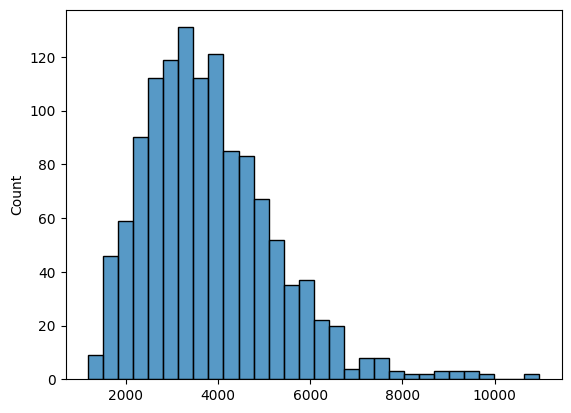

In [21]:
# total number of read per cell
sns.histplot(read_counts.sum(axis=1),bins=30)

<Axes: ylabel='Count'>

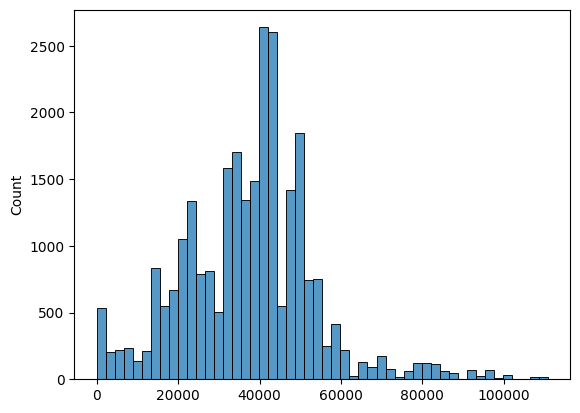

In [248]:
# total coverage per variant 
sns.histplot(covs.sum(axis=0),bins=50)

<Axes: ylabel='Count'>

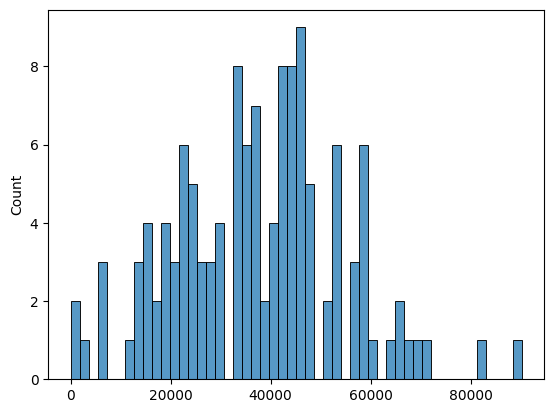

In [6]:
# total coverage per amplicon 
sns.histplot(read_counts.sum(axis=0),bins=50)

First strange thing, some variants have higher coverage than amplicon

### Read count check

In [5]:
amplicons

CHROM    end_pos                         id  r1_counts  r2_counts   
0     b'1'  115256723   b'AML_v2_NRAS_115256512'      43222      43124  \
1     b'1'  115258825   b'AML_v2_NRAS_115258635'      36200      36072   
2     b'2'   25457372  b'AML_v2_DNMT3A_25457166'      25986      25973   
3     b'2'   25458763  b'AML_v2_DNMT3A_25458540'      48517      48463   
4     b'2'   25460046  b'AML_v2_DNMT3A_25459813'      13589      13567   
..     ...        ...                        ...        ...        ...   
122  b'21'   36206913   b'AML_v2_RUNX1_36206703'      41584      41519   
123  b'21'   36231937   b'AML_v2_RUNX1_36231714'      22554      22536   
124  b'21'   36253046   b'AML_v2_RUNX1_36252844'      51341      51276   
125  b'21'   44514808   b'AML_v2_U2AF1_44514570'      65367      65269   
126  b'21'   44524634   b'AML_v2_U2AF1_44524438'      43331      43280   

     start_pos  
0    115256488  
1    115258610  
2     25457144  
3     25458519  
4     25459794  
..         ...  
122   36206684  
123   36231693  
124   36252820  
125   44514550  
126   44524417  

[127 rows x 6 columns]

In [11]:
sum(read_counts.sum(axis=0).values - amplicons.r1_counts) # r1_counts = total read count per ammlicon across all cell

0

In [12]:
sum(read_counts.sum(axis=0).values - amplicons.r2_counts) # r2_counts not total read count per ammlicon across all cell

5192

### Normalization impact

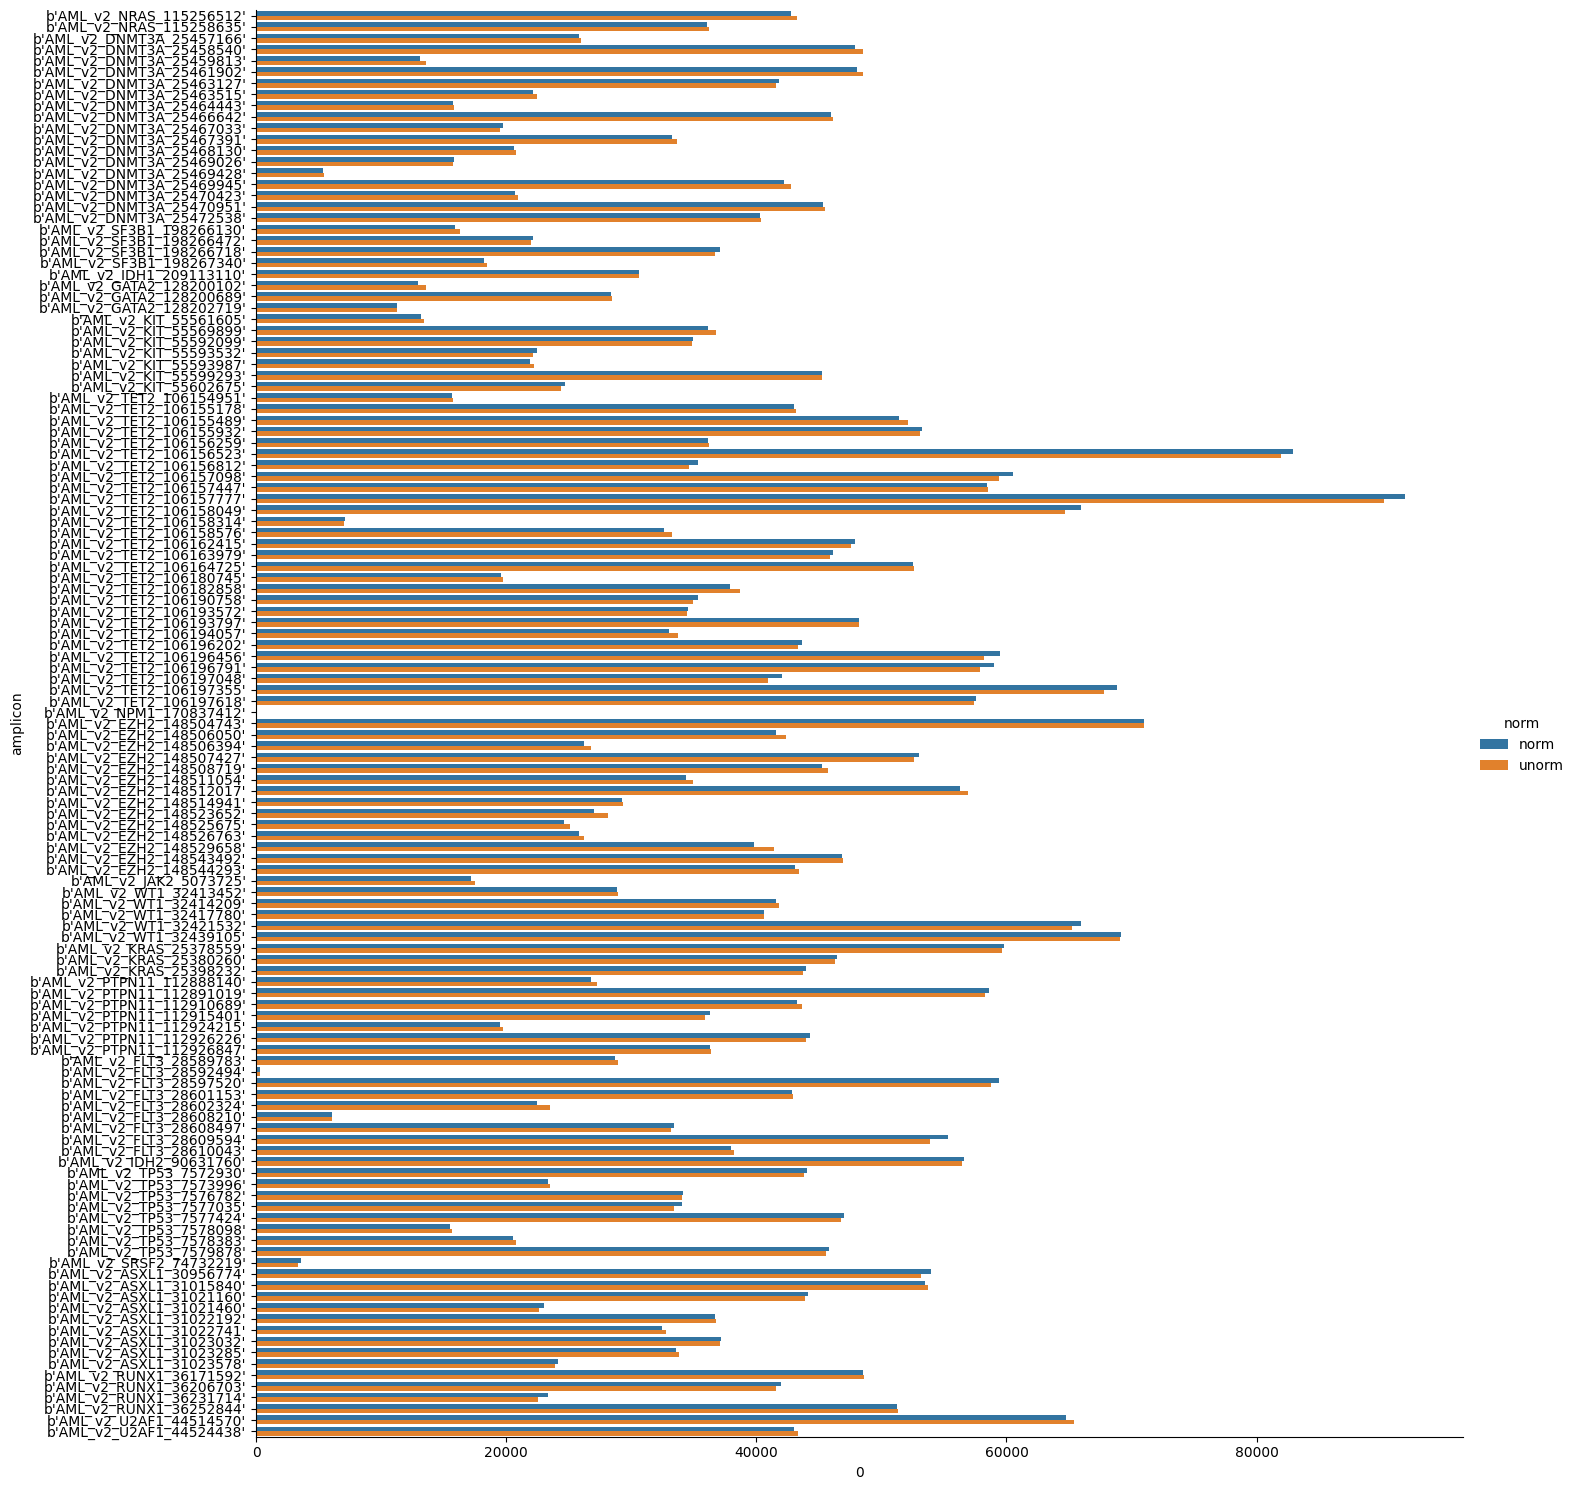

In [4]:
# sum Normalized read count, new read count (prop*sum tot read count cell)

mean_tot_nb_read_cell = read_counts.sum(axis=1).mean()
with_without_norm_read_rank = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).sum(axis=0)*mean_tot_nb_read_cell).values
,'unorm_rank': read_counts.sum(axis=0).values})
with_without_norm_read_rank = with_without_norm_read_rank.set_index('amplicon').stack().reset_index(level=1,drop=True).to_frame()
with_without_norm_read_rank['norm'] = np.array([['norm','unorm'] for _ in range(127)]).flatten()
with_without_norm_read_rank['amplicon'] = with_without_norm_read_rank.index

sns.catplot(
    data=with_without_norm_read_rank, kind="bar",
    x=0, y="amplicon", hue="norm", alpha=1, height=15
)

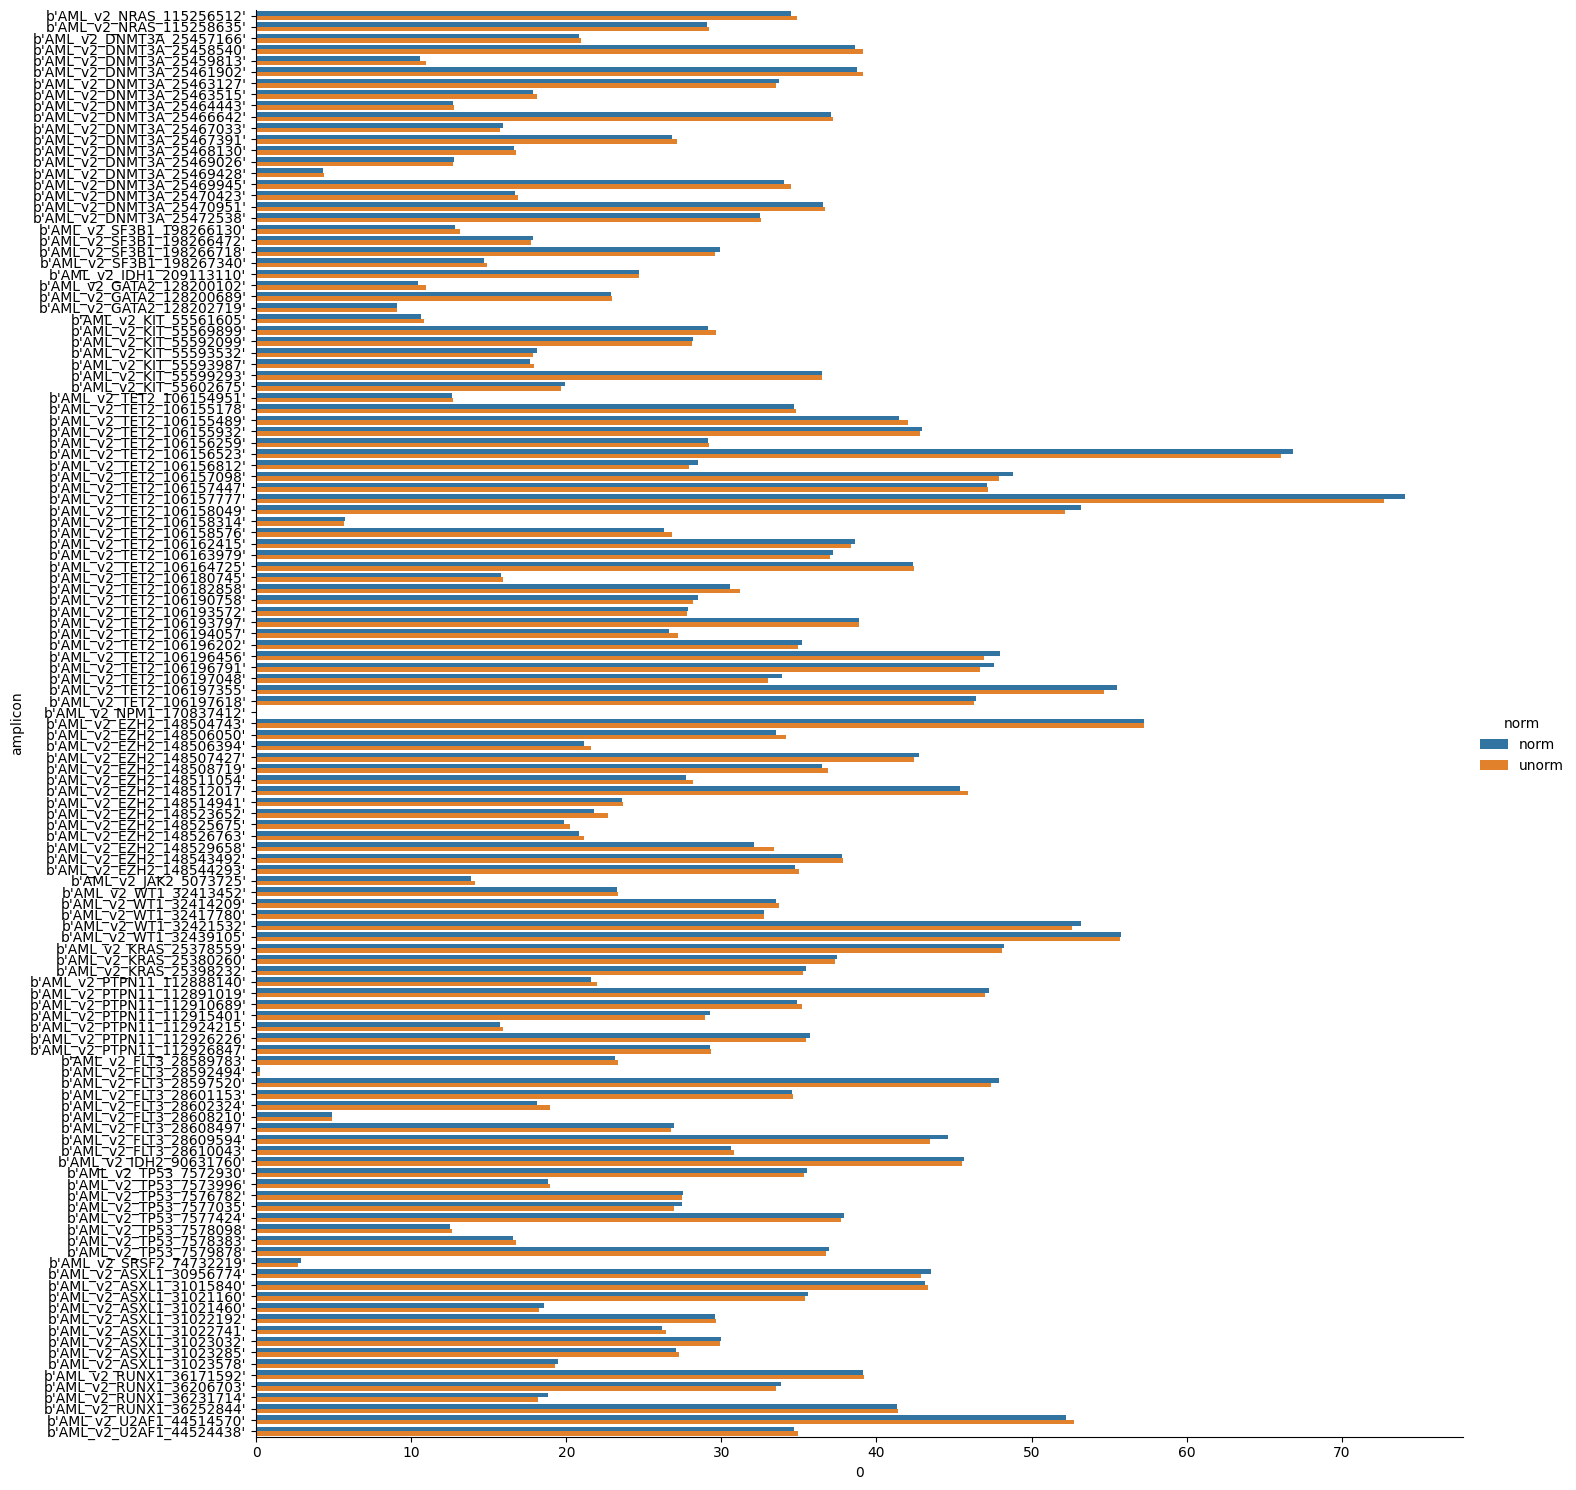

In [64]:
# mean Normalized read count, new read count (prop*mean tot read count cell)

mean_tot_nb_read_cell = read_counts.sum(axis=1).mean()
with_without_norm_read_rank = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).mean(axis=0)*mean_tot_nb_read_cell).values
,'unorm_rank': read_counts.mean(axis=0).values})
with_without_norm_read_rank = with_without_norm_read_rank.set_index('amplicon').stack().reset_index(level=1,drop=True).to_frame()
with_without_norm_read_rank['norm'] = np.array([['norm','unorm'] for _ in range(127)]).flatten()
with_without_norm_read_rank['amplicon'] = with_without_norm_read_rank.index

sns.catplot(
    data=with_without_norm_read_rank, kind="bar",
    x=0, y="amplicon", hue="norm", alpha=1, height=15
)

### Amplicon size influence

<Axes: ylabel='Count'>

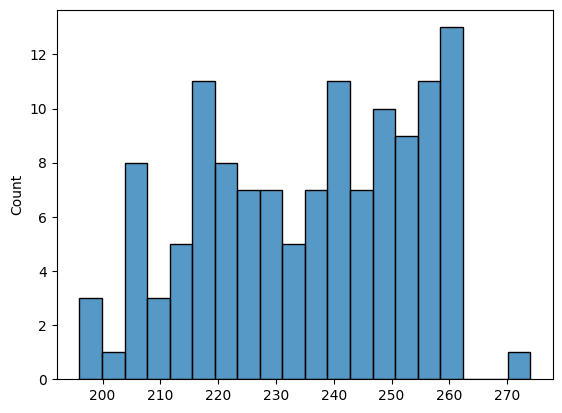

In [15]:
# variance of size of amplicon

sns.histplot(amplicons.end_pos - amplicons.start_pos, bins=20)

<Axes: xlabel='length', ylabel='CHROM'>

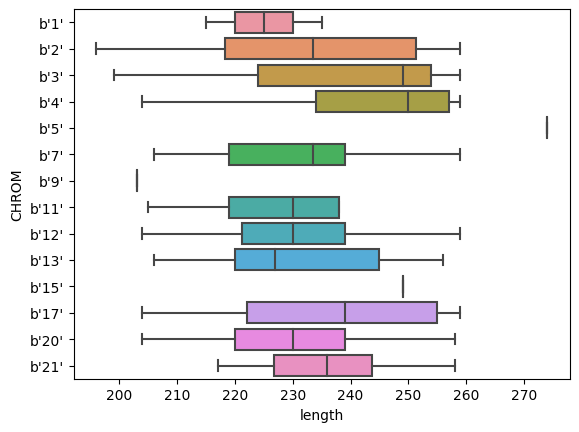

In [66]:
# amplicon size variance in chromosome
sanity_amplicon = amplicons.copy()
sanity_amplicon['length'] = sanity_amplicon.end_pos - sanity_amplicon.start_pos
sanity_amplicon[['CHROM','length']].groupby(['CHROM']).mean()
sns.boxplot(data=sanity_amplicon, x='length',y='CHROM')

<Axes: xlabel='length', ylabel='r1_counts'>

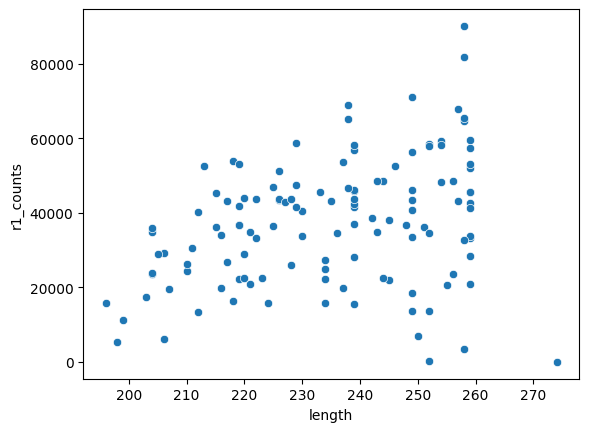

In [73]:
# link between size of amplicon and total read count
sns.scatterplot(data=sanity_amplicon,x='length',y='r1_counts')

In [35]:
# number of amplicon per chomosome
sanity_amplicon.groupby(['CHROM']).count()

end_pos  id  r1_counts  r2_counts  start_pos  length
CHROM                                                      
b'1'         2   2          2          2          2       2
b'11'        5   5          5          5          5       5
b'12'       10  10         10         10         10      10
b'13'        9   9          9          9          9       9
b'15'        1   1          1          1          1       1
b'17'        9   9          9          9          9       9
b'2'        22  22         22         22         22      22
b'20'        9   9          9          9          9       9
b'21'        6   6          6          6          6       6
b'3'         3   3          3          3          3       3
b'4'        35  35         35         35         35      35
b'5'         1   1          1          1          1       1
b'7'        14  14         14         14         14      14
b'9'         1   1          1          1          1       1

### Variants per amplicon

In [95]:
# total read count snv of amplicon, different pos snv 
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
counts = sanity_snv[['sum','amplicon']].groupby(['amplicon']).count().values # nb of variant per amplicon
median_var = sanity_snv[['sum','amplicon']].groupby(['amplicon']).median()
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').sum()
sanity_snv['count'] = counts

sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

sum  count  r1_counts  r2_counts
amplicon                                                       
b'AML_v2_ASXL1_30956774'  11193265    196      53141      53111
b'AML_v2_ASXL1_31015840'  10736037    210      53753      53732
b'AML_v2_ASXL1_31021160'  10078496    215      43869      43155
b'AML_v2_ASXL1_31021460'   5008863    185      22622      23268
b'AML_v2_ASXL1_31022192'   8233281    228      36757      36710
...                            ...    ...        ...        ...
b'AML_v2_WT1_32413452'     6440547    174      28945      28925
b'AML_v2_WT1_32414209'     9164606    196      41840      41799
b'AML_v2_WT1_32417780'     8834845    204      40601      40580
b'AML_v2_WT1_32421532'    13341651    230      65205      65175
b'AML_v2_WT1_32439105'    13526610    225      69072      69013

[127 rows x 4 columns]

In [16]:
# useless
# total read count snv of amplicon, different pos snv 
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv['POS'] = variants.POS.values
sanity_snv = sanity_snv.drop_duplicates('POS')
counts = sanity_snv[['sum','amplicon']].groupby(['amplicon']).count().values # nb of variant per amplicon with different position
median_var = sanity_snv[['sum','amplicon']].groupby(['amplicon']).median()
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').sum()
sanity_snv['count'] = counts

sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

sum  count  r1_counts  r2_counts
amplicon                                                       
b'AML_v2_ASXL1_30956774'  10027490    173      53141      53111
b'AML_v2_ASXL1_31015840'   9690454    189      53753      53732
b'AML_v2_ASXL1_31021160'   8669995    185      43869      43155
b'AML_v2_ASXL1_31021460'   4711682    174      22622      23268
b'AML_v2_ASXL1_31022192'   7383531    204      36757      36710
...                            ...    ...        ...        ...
b'AML_v2_WT1_32413452'     5812236    156      28945      28925
b'AML_v2_WT1_32414209'     8129307    172      41840      41799
b'AML_v2_WT1_32417780'     8092142    185      40601      40580
b'AML_v2_WT1_32421532'    11392642    196      65205      65175
b'AML_v2_WT1_32439105'    11618232    193      69072      69013

[127 rows x 4 columns]

<Axes: xlabel='count', ylabel='Count'>

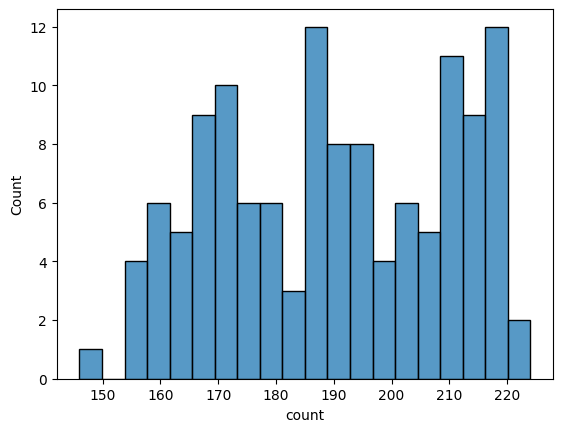

In [17]:
# nb of variant per amplicon
sns.histplot(sanity_snv['count'], bins=20)

<Axes: xlabel='length', ylabel='count'>

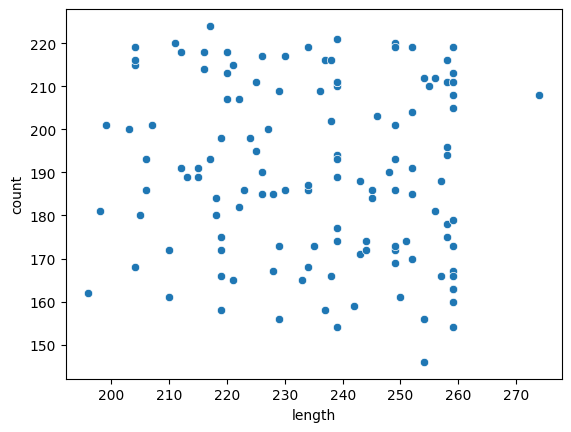

In [256]:
# link between size of amplicon and nb variant
sanity_snv['length'] = (amplicons.end_pos - amplicons.start_pos).values
sns.scatterplot(data=sanity_snv,x='length',y='count')

### Sanity check amplicon read count and variant coverage

Do we have the variant with the max nb of read count accross cells <= total read count of the amplicon it belongs to ? 


In [6]:
covs

b'chr1:115256513:G/A'  b'chr1:115256513:G/T'   
b'AACAACCTACAGAAGTGA-1'                     36                     36  \
b'AACAACCTATCTATGACA-1'                      9                      9   
b'AACAACTGGCAACGCACA-1'                     43                     43   
b'AACACACTCTTACAGTGT-1'                     51                     51   
b'AACAGCAGTCGTCTGCTG-1'                     31                     31   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                      9                      9   
b'TTGGAGAACTGAACTTGC-1'                     51                     51   
b'TTGGTAACTTCTGCGCTG-1'                     46                     46   
b'TTGTCAACCGCAGCAGTG-1'                     50                     50   
b'TTGTTAGAGAATCTCCTA-1'                     49                     49   

                         b'chr1:115256514:G/A'  b'chr1:115256515:C/'   
b'AACAACCTACAGAAGTGA-1'                     36                    36  \
b'AACAACCTATCTATGACA-1'                     11                    11   
b'AACAACTGGCAACGCACA-1'                     43                    43   
b'AACACACTCTTACAGTGT-1'                     51                    51   
b'AACAGCAGTCGTCTGCTG-1'                     31                    31   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'                      9                     9   
b'TTGGAGAACTGAACTTGC-1'                     51                    51   
b'TTGGTAACTTCTGCGCTG-1'                     46                    46   
b'TTGTCAACCGCAGCAGTG-1'                     50                    50   
b'TTGTTAGAGAATCTCCTA-1'                     49                    51   

                         b'chr1:115256516:A/G'  b'chr1:115256516:A/T'   
b'AACAACCTACAGAAGTGA-1'                     36                     36  \
b'AACAACCTATCTATGACA-1'                     11                     11   
b'AACAACTGGCAACGCACA-1'                     43                     43   
b'AACACACTCTTACAGTGT-1'                     51                     51   
b'AACAGCAGTCGTCTGCTG-1'                     31                     31   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                      9                      9   
b'TTGGAGAACTGAACTTGC-1'                     51                     51   
b'TTGGTAACTTCTGCGCTG-1'                     46                     46   
b'TTGTCAACCGCAGCAGTG-1'                     50                     50   
b'TTGTTAGAGAATCTCCTA-1'                     51                     51   

                         b'chr1:115256517:C/'  b'chr1:115256518:T/C'   
b'AACAACCTACAGAAGTGA-1'                    36                     36  \
b'AACAACCTATCTATGACA-1'                    11                     11   
b'AACAACTGGCAACGCACA-1'                    43                     43   
b'AACACACTCTTACAGTGT-1'                    51                     51   
b'AACAGCAGTCGTCTGCTG-1'                    31                     31   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                     9                      9   
b'TTGGAGAACTGAACTTGC-1'                    51                     51   
b'TTGGTAACTTCTGCGCTG-1'                    46                     46   
b'TTGTCAACCGCAGCAGTG-1'                    50                     50   
b'TTGTTAGAGAATCTCCTA-1'                    51                     51   

                         b'chr1:115256518:T/G'  b'chr1:115256519:G/'  ...   
b'AACAACCTACAGAAGTGA-1'                     36                    36  ...  \
b'AACAACCTATCTATGACA-1'                     11                    11  ...   
b'AACAACTGGCAACGCACA-1'                     43                    43  ...   
b'AACACACTCTTACAGTGT-1'                     51                    51  ...   
b'AACAGCAGTCGTCTGCTG-1'                     31                    31  ...   
...                                        ...                   ...  ...   
b'

In [4]:
snv_read_count = covs.copy()

for col in snv_read_count.columns:
    amplicon = variants.amplicon[variants.id == col].values[0]
    snv_read_count[col] = read_counts[amplicon]

# snv_read_count replace values by read count of associated amplicon for each variant

In [5]:
np.unique(snv_read_count.iloc[0].values).shape # unique values (read count variant) need to be < 127

(57,)

In [6]:
np.unique(read_counts.iloc[0].values).shape # unique values (read count amplicon) (equal !)

(57,)

In [7]:
reda_count_snv_amplicon = covs/snv_read_count # expected all values below 1

In [8]:
reda_count_snv_amplicon

b'chr1:115256513:G/A'  b'chr1:115256513:G/T'   
b'AACAACCTACAGAAGTGA-1'               0.972973               0.972973  \
b'AACAACCTATCTATGACA-1'               0.818182               0.818182   
b'AACAACTGGCAACGCACA-1'               0.977273               0.977273   
b'AACACACTCTTACAGTGT-1'               0.864407               0.864407   
b'AACAGCAGTCGTCTGCTG-1'               1.000000               1.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               1.000000               1.000000   
b'TTGGAGAACTGAACTTGC-1'               0.467890               0.467890   
b'TTGGTAACTTCTGCGCTG-1'               1.000000               1.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.724638               0.724638   
b'TTGTTAGAGAATCTCCTA-1'               0.753846               0.753846   

                         b'chr1:115256514:G/A'  b'chr1:115256515:C/'   
b'AACAACCTACAGAAGTGA-1'               0.972973              0.972973  \
b'AACAACCTATCTATGACA-1'               1.000000              1.000000   
b'AACAACTGGCAACGCACA-1'               0.977273              0.977273   
b'AACACACTCTTACAGTGT-1'               0.864407              0.864407   
b'AACAGCAGTCGTCTGCTG-1'               1.000000              1.000000   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'               1.000000              1.000000   
b'TTGGAGAACTGAACTTGC-1'               0.467890              0.467890   
b'TTGGTAACTTCTGCGCTG-1'               1.000000              1.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.724638              0.724638   
b'TTGTTAGAGAATCTCCTA-1'               0.753846              0.784615   

                         b'chr1:115256516:A/G'  b'chr1:115256516:A/T'   
b'AACAACCTACAGAAGTGA-1'               0.972973               0.972973  \
b'AACAACCTATCTATGACA-1'               1.000000               1.000000   
b'AACAACTGGCAACGCACA-1'               0.977273               0.977273   
b'AACACACTCTTACAGTGT-1'               0.864407               0.864407   
b'AACAGCAGTCGTCTGCTG-1'               1.000000               1.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               1.000000               1.000000   
b'TTGGAGAACTGAACTTGC-1'               0.467890               0.467890   
b'TTGGTAACTTCTGCGCTG-1'               1.000000               1.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.724638               0.724638   
b'TTGTTAGAGAATCTCCTA-1'               0.784615               0.784615   

                         b'chr1:115256517:C/'  b'chr1:115256518:T/C'   
b'AACAACCTACAGAAGTGA-1'              0.972973               0.972973  \
b'AACAACCTATCTATGACA-1'              1.000000               1.000000   
b'AACAACTGGCAACGCACA-1'              0.977273               0.977273   
b'AACACACTCTTACAGTGT-1'              0.864407               0.864407   
b'AACAGCAGTCGTCTGCTG-1'              1.000000               1.000000   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'              1.000000               1.000000   
b'TTGGAGAACTGAACTTGC-1'              0.467890               0.467890   
b'TTGGTAACTTCTGCGCTG-1'              1.000000               1.000000   
b'TTGTCAACCGCAGCAGTG-1'              0.724638               0.724638   
b'TTGTTAGAGAATCTCCTA-1'              0.784615               0.784615   

                         b'chr1:115256518:T/G'  b'chr1:115256519:G/'  ...   
b'AACAACCTACAGAAGTGA-1'               0.972973              0.972973  ...  \
b'AACAACCTATCTATGACA-1'               1.000000              1.000000  ...   
b'AACAACTGGCAACGCACA-1'               0.977273              0.977273  ...   
b'AACACACTCTTACAGTGT-1'               0.864407              0.864407  ...   
b'AACAGCAGTCGTCTGCTG-1'               1.000000              1.000000  ...   
...                                        ...                   ...  ...   
b'

In [9]:
unique, counts = np.unique(reda_count_snv_amplicon.round(decimals=1).to_numpy(), return_counts=True)

In [10]:
unique

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 3. , 3.5, 4. , 5. , 6. , inf, nan])

In [11]:
counts

array([  185191,    17170,    16761,    50049,   133920,   312373,
         555776,   844814,  1281701,  2072759, 23506637,   391658,
          88493,    38668,    31703,    46557,    44850,    56564,
         109815,   347034,  2370064,    35619,     9852,     2452,
            705,     2105,      175,      419,      143,     2675,
              5,      913,      321,       17,    11907,   798535],
      dtype=int64)

<Axes: ylabel='Count'>

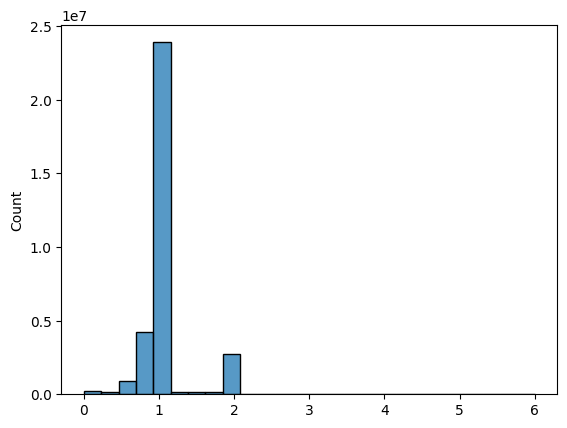

In [12]:
sns.histplot(x=reda_count_snv_amplicon.round(decimals=1).to_numpy().flatten())

In [17]:
unique, counts = np.unique(reda_count_snv_amplicon.replace(np.inf, 0).round(decimals=1).to_numpy(), return_counts=True) # remove inf values

In [18]:
unique, counts

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 3. , 3.5, 4. , 5. , 6. , nan]),
 array([  197098,    17170,    16761,    50049,   133920,   312373,
          555776,   844814,  1281701,  2072759, 23506637,   391658,
           88493,    38668,    31703,    46557,    44850,    56564,
          109815,   347034,  2370064,    35619,     9852,     2452,
             705,     2105,      175,      419,      143,     2675,
               5,      913,      321,       17,   798535], dtype=int64))

In [20]:
unique, counts = np.unique(reda_count_snv_amplicon.replace(np.inf, 0).gt(1).to_numpy(), return_counts=True) # greater than 1 values 

In [21]:
unique, counts

(array([False,  True]), array([29213122,  4155278], dtype=int64))

what is in read count

In [77]:
max_amplicon = covs.T.copy()
max_amplicon['amplicon'] = variants.amplicon.values
max_amplicon = max_amplicon.groupby('amplicon').max()
max_amplicon = max_amplicon.T
max_amplicon[read_counts.columns] # max variant read count for each amplicon and cell (actual read count ?)

amplicon                 b'AML_v2_NRAS_115256512'  b'AML_v2_NRAS_115258635'   
b'AACAACCTACAGAAGTGA-1'                        74                        60  \
b'AACAACCTATCTATGACA-1'                        22                        38   
b'AACAACTGGCAACGCACA-1'                        86                        52   
b'AACACACTCTTACAGTGT-1'                       104                        62   
b'AACAGCAGTCGTCTGCTG-1'                        61                        64   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                        17                         8   
b'TTGGAGAACTGAACTTGC-1'                       108                         2   
b'TTGGTAACTTCTGCGCTG-1'                        92                        92   
b'TTGTCAACCGCAGCAGTG-1'                       102                        83   
b'TTGTTAGAGAATCTCCTA-1'                       115                       108   

amplicon                 b'AML_v2_DNMT3A_25457166'  b'AML_v2_DNMT3A_25458540'   
b'AACAACCTACAGAAGTGA-1'                         46                         80  \
b'AACAACCTATCTATGACA-1'                         50                         44   
b'AACAACTGGCAACGCACA-1'                         20                         46   
b'AACACACTCTTACAGTGT-1'                         44                         88   
b'AACAGCAGTCGTCTGCTG-1'                         84                        107   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         38                         38   
b'TTGGAGAACTGAACTTGC-1'                        100                         94   
b'TTGGTAACTTCTGCGCTG-1'                         40                        103   
b'TTGTCAACCGCAGCAGTG-1'                         40                        104   
b'TTGTTAGAGAATCTCCTA-1'                         64                        106   

amplicon                 b'AML_v2_DNMT3A_25459813'  b'AML_v2_DNMT3A_25461902'   
b'AACAACCTACAGAAGTGA-1'                         20                         51  \
b'AACAACCTATCTATGACA-1'                          5                         26   
b'AACAACTGGCAACGCACA-1'                         50                         54   
b'AACACACTCTTACAGTGT-1'                          8                         32   
b'AACAGCAGTCGTCTGCTG-1'                          9                         52   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         18                         27   
b'TTGGAGAACTGAACTTGC-1'                         38                         50   
b'TTGGTAACTTCTGCGCTG-1'                         62                         51   
b'TTGTCAACCGCAGCAGTG-1'                         11                         62   
b'TTGTTAGAGAATCTCCTA-1'                         17                         54   

amplicon                 b'AML_v2_DNMT3A_25463127'  b'AML_v2_DNMT3A_25463515'   
b'AACAACCTACAGAAGTGA-1'                         80                         31  \
b'AACAACCTATCTATGACA-1'                         32                         30   
b'AACAACTGGCAACGCACA-1'                         58                         12   
b'AACACACTCTTACAGTGT-1'                         48                         24   
b'AACAGCAGTCGTCTGCTG-1'                        102                         48   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         57                         29   
b'TTGGAGAACTGAACTTGC-1'                        107                         76   
b'TTGGTAACTTCTGCGCTG-1'                         80                         40   
b'TTGTCAACCGCAGCAGTG-1'                         93                         38   
b'TTGTTAGAGAATCTCCTA-1'                         99                         78   

amplicon                 b'AML_v2_DNMT3A_25464443'  b'AML_v2_DNMT3A_25466642'   
b'AACAACCTACAGAAGTGA-1'                         48 

In [32]:
read_counts

b'AML_v2_NRAS_115256512'  b'AML_v2_NRAS_115258635'   
b'AACAACCTACAGAAGTGA-1'                        37                        30  \
b'AACAACCTATCTATGACA-1'                        11                        19   
b'AACAACTGGCAACGCACA-1'                        44                        26   
b'AACACACTCTTACAGTGT-1'                        59                        31   
b'AACAGCAGTCGTCTGCTG-1'                        31                        32   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                         9                         4   
b'TTGGAGAACTGAACTTGC-1'                       109                         1   
b'TTGGTAACTTCTGCGCTG-1'                        46                        47   
b'TTGTCAACCGCAGCAGTG-1'                        69                        42   
b'TTGTTAGAGAATCTCCTA-1'                        65                        71   

                         b'AML_v2_DNMT3A_25457166'  b'AML_v2_DNMT3A_25458540'   
b'AACAACCTACAGAAGTGA-1'                         23                         40  \
b'AACAACCTATCTATGACA-1'                         25                         22   
b'AACAACTGGCAACGCACA-1'                         10                         23   
b'AACACACTCTTACAGTGT-1'                         22                         44   
b'AACAGCAGTCGTCTGCTG-1'                         42                         74   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         19                         19   
b'TTGGAGAACTGAACTTGC-1'                         50                        102   
b'TTGGTAACTTCTGCGCTG-1'                         20                         58   
b'TTGTCAACCGCAGCAGTG-1'                         20                         52   
b'TTGTTAGAGAATCTCCTA-1'                         32                         56   

                         b'AML_v2_DNMT3A_25459813'  b'AML_v2_DNMT3A_25461902'   
b'AACAACCTACAGAAGTGA-1'                         20                         58  \
b'AACAACCTATCTATGACA-1'                          5                         26   
b'AACAACTGGCAACGCACA-1'                         25                         52   
b'AACACACTCTTACAGTGT-1'                          7                         32   
b'AACAGCAGTCGTCTGCTG-1'                          9                         77   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                          9                         27   
b'TTGGAGAACTGAACTTGC-1'                         19                         66   
b'TTGGTAACTTCTGCGCTG-1'                         31                         60   
b'TTGTCAACCGCAGCAGTG-1'                         11                         70   
b'TTGTTAGAGAATCTCCTA-1'                         17                         56   

                         b'AML_v2_DNMT3A_25463127'  b'AML_v2_DNMT3A_25463515'   
b'AACAACCTACAGAAGTGA-1'                         40                         16  \
b'AACAACCTATCTATGACA-1'                         16                         15   
b'AACAACTGGCAACGCACA-1'                         29                          6   
b'AACACACTCTTACAGTGT-1'                         24                         12   
b'AACAGCAGTCGTCTGCTG-1'                         55                         24   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         29                         14   
b'TTGGAGAACTGAACTTGC-1'                         54                         38   
b'TTGGTAACTTCTGCGCTG-1'                         40                         20   
b'TTGTCAACCGCAGCAGTG-1'                         47                         19   
b'TTGTTAGAGAATCTCCTA-1'                         50                         39   

                         b'AML_v2_DNMT3A_25464443'  b'AML_v2_DNMT3A_25466642'   
b'AACAACCTACAGAAGTGA-1'                         24                         3

seems that read count / 2 but not always 

In [215]:
max_amplicon = covs.T.copy()
max_amplicon['amplicon'] = variants.amplicon.values
max_amplicon = max_amplicon.groupby('amplicon').max()
max_amplicon = max_amplicon.T

# after filtering variants and cells 
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').max() # variant with max read per amplicon not sum
sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv['max'] = max_amplicon.sum()
sanity_snv['sum_r1_r2'] = sanity_snv['r1_counts'] + sanity_snv['r2_counts']
sanity_snv

sum  r1_counts  r2_counts     max  sum_r1_r2
amplicon                                                                 
b'AML_v2_ASXL1_30956774'   96748      53141      53111   97053     106252
b'AML_v2_ASXL1_31015840'   94131      53753      53732   94397     107485
b'AML_v2_ASXL1_31021160'   82671      43869      43155   83015      87024
b'AML_v2_ASXL1_31021460'   45419      22622      23268   45528      45890
b'AML_v2_ASXL1_31022192'   70378      36757      36710   70526      73467
...                          ...        ...        ...     ...        ...
b'AML_v2_WT1_32413452'     57089      28945      28925   57287      57870
b'AML_v2_WT1_32414209'     79400      41840      41799   79580      83639
b'AML_v2_WT1_32417780'     77764      40601      40580   77966      81181
b'AML_v2_WT1_32421532'    107474      65205      65175  107863     130380
b'AML_v2_WT1_32439105'    110845      69072      69013  111084     138085

[127 rows x 5 columns]

In [64]:
min_amplicon = covs.T.copy()
min_amplicon['amplicon'] = variants.amplicon.values
min_amplicon = min_amplicon.groupby('amplicon').min()
min_amplicon = min_amplicon.T
min_amplicon[read_counts.columns] # min variant read count for each amplicon and cell (actual read count ?)

amplicon                 b'AML_v2_NRAS_115256512'  b'AML_v2_NRAS_115258635'   
b'AACAACCTACAGAAGTGA-1'                        34                        29  \
b'AACAACCTATCTATGACA-1'                         9                        19   
b'AACAACTGGCAACGCACA-1'                        42                        26   
b'AACACACTCTTACAGTGT-1'                        41                        27   
b'AACAGCAGTCGTCTGCTG-1'                        29                        32   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                         9                         4   
b'TTGGAGAACTGAACTTGC-1'                        51                         1   
b'TTGGTAACTTCTGCGCTG-1'                        42                        46   
b'TTGTCAACCGCAGCAGTG-1'                        48                        41   
b'TTGTTAGAGAATCTCCTA-1'                        49                        54   

amplicon                 b'AML_v2_DNMT3A_25457166'  b'AML_v2_DNMT3A_25458540'   
b'AACAACCTACAGAAGTGA-1'                         23                         40  \
b'AACAACCTATCTATGACA-1'                         25                         22   
b'AACAACTGGCAACGCACA-1'                          9                         23   
b'AACACACTCTTACAGTGT-1'                         22                         43   
b'AACAGCAGTCGTCTGCTG-1'                         41                         49   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         19                         16   
b'TTGGAGAACTGAACTTGC-1'                         50                         47   
b'TTGGTAACTTCTGCGCTG-1'                         20                         48   
b'TTGTCAACCGCAGCAGTG-1'                         20                         44   
b'TTGTTAGAGAATCTCCTA-1'                         32                         53   

amplicon                 b'AML_v2_DNMT3A_25459813'  b'AML_v2_DNMT3A_25461902'   
b'AACAACCTACAGAAGTGA-1'                          1                          0  \
b'AACAACCTATCTATGACA-1'                          0                          0   
b'AACAACTGGCAACGCACA-1'                         25                          2   
b'AACACACTCTTACAGTGT-1'                          7                          0   
b'AACAGCAGTCGTCTGCTG-1'                          2                          0   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                          9                          1   
b'TTGGAGAACTGAACTTGC-1'                         19                          0   
b'TTGGTAACTTCTGCGCTG-1'                         30                          0   
b'TTGTCAACCGCAGCAGTG-1'                         11                          0   
b'TTGTTAGAGAATCTCCTA-1'                          1                          0   

amplicon                 b'AML_v2_DNMT3A_25463127'  b'AML_v2_DNMT3A_25463515'   
b'AACAACCTACAGAAGTGA-1'                         40                         15  \
b'AACAACCTATCTATGACA-1'                         16                         15   
b'AACAACTGGCAACGCACA-1'                         29                          6   
b'AACACACTCTTACAGTGT-1'                         23                         12   
b'AACAGCAGTCGTCTGCTG-1'                         50                         24   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         28                         14   
b'TTGGAGAACTGAACTTGC-1'                         53                         38   
b'TTGGTAACTTCTGCGCTG-1'                         35                         20   
b'TTGTCAACCGCAGCAGTG-1'                         44                         19   
b'TTGTTAGAGAATCTCCTA-1'                         44                         39   

amplicon                 b'AML_v2_DNMT3A_25464443'  b'AML_v2_DNMT3A_25466642'   
b'AACAACCTACAGAAGTGA-1'                         24 

In [65]:
read_counts

b'AML_v2_NRAS_115256512'  b'AML_v2_NRAS_115258635'   
b'AACAACCTACAGAAGTGA-1'                        37                        30  \
b'AACAACCTATCTATGACA-1'                        11                        19   
b'AACAACTGGCAACGCACA-1'                        44                        26   
b'AACACACTCTTACAGTGT-1'                        59                        31   
b'AACAGCAGTCGTCTGCTG-1'                        31                        32   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                         9                         4   
b'TTGGAGAACTGAACTTGC-1'                       109                         1   
b'TTGGTAACTTCTGCGCTG-1'                        46                        47   
b'TTGTCAACCGCAGCAGTG-1'                        69                        42   
b'TTGTTAGAGAATCTCCTA-1'                        65                        71   

                         b'AML_v2_DNMT3A_25457166'  b'AML_v2_DNMT3A_25458540'   
b'AACAACCTACAGAAGTGA-1'                         23                         40  \
b'AACAACCTATCTATGACA-1'                         25                         22   
b'AACAACTGGCAACGCACA-1'                         10                         23   
b'AACACACTCTTACAGTGT-1'                         22                         44   
b'AACAGCAGTCGTCTGCTG-1'                         42                         74   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         19                         19   
b'TTGGAGAACTGAACTTGC-1'                         50                        102   
b'TTGGTAACTTCTGCGCTG-1'                         20                         58   
b'TTGTCAACCGCAGCAGTG-1'                         20                         52   
b'TTGTTAGAGAATCTCCTA-1'                         32                         56   

                         b'AML_v2_DNMT3A_25459813'  b'AML_v2_DNMT3A_25461902'   
b'AACAACCTACAGAAGTGA-1'                         20                         58  \
b'AACAACCTATCTATGACA-1'                          5                         26   
b'AACAACTGGCAACGCACA-1'                         25                         52   
b'AACACACTCTTACAGTGT-1'                          7                         32   
b'AACAGCAGTCGTCTGCTG-1'                          9                         77   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                          9                         27   
b'TTGGAGAACTGAACTTGC-1'                         19                         66   
b'TTGGTAACTTCTGCGCTG-1'                         31                         60   
b'TTGTCAACCGCAGCAGTG-1'                         11                         70   
b'TTGTTAGAGAATCTCCTA-1'                         17                         56   

                         b'AML_v2_DNMT3A_25463127'  b'AML_v2_DNMT3A_25463515'   
b'AACAACCTACAGAAGTGA-1'                         40                         16  \
b'AACAACCTATCTATGACA-1'                         16                         15   
b'AACAACTGGCAACGCACA-1'                         29                          6   
b'AACACACTCTTACAGTGT-1'                         24                         12   
b'AACAGCAGTCGTCTGCTG-1'                         55                         24   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         29                         14   
b'TTGGAGAACTGAACTTGC-1'                         54                         38   
b'TTGGTAACTTCTGCGCTG-1'                         40                         20   
b'TTGTCAACCGCAGCAGTG-1'                         47                         19   
b'TTGTTAGAGAATCTCCTA-1'                         50                         39   

                         b'AML_v2_DNMT3A_25464443'  b'AML_v2_DNMT3A_25466642'   
b'AACAACCTACAGAAGTGA-1'                         24                         3

In [69]:
mean_amplicon = covs.T.copy()
mean_amplicon['amplicon'] = variants.amplicon.values
mean_amplicon = mean_amplicon.groupby('amplicon').mean()
mean_amplicon = mean_amplicon.T
mean_amplicon[read_counts.columns] # mean variant read count for each amplicon and cell (actual read count ?)

amplicon                 b'AML_v2_NRAS_115256512'  b'AML_v2_NRAS_115258635'   
b'AACAACCTACAGAAGTGA-1'                 39.346847                 36.280423  \
b'AACAACCTATCTATGACA-1'                 11.855856                 22.920635   
b'AACAACTGGCAACGCACA-1'                 46.657658                 31.650794   
b'AACACACTCTTACAGTGT-1'                 56.031532                 36.582011   
b'AACAGCAGTCGTCTGCTG-1'                 33.018018                 38.560847   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                  9.761261                  4.867725   
b'TTGGAGAACTGAACTTGC-1'                 58.409910                  1.216931   
b'TTGGTAACTTCTGCGCTG-1'                 49.747748                 56.190476   
b'TTGTCAACCGCAGCAGTG-1'                 54.630631                 50.656085   
b'TTGTTAGAGAATCTCCTA-1'                 61.112613                 64.867725   

amplicon                 b'AML_v2_DNMT3A_25457166'  b'AML_v2_DNMT3A_25458540'   
b'AACAACCTACAGAAGTGA-1'                  25.653266                  41.203390  \
b'AACAACCTATCTATGACA-1'                  27.869347                  22.656780   
b'AACAACTGGCAACGCACA-1'                  11.442211                  23.978814   
b'AACACACTCTTACAGTGT-1'                  24.577889                  45.283898   
b'AACAGCAGTCGTCTGCTG-1'                  46.949749                  55.398305   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                  21.336683                  19.834746   
b'TTGGAGAACTGAACTTGC-1'                  56.266332                  54.932203   
b'TTGGTAACTTCTGCGCTG-1'                  22.608040                  53.851695   
b'TTGTCAACCGCAGCAGTG-1'                  22.467337                  53.754237   
b'TTGTTAGAGAATCTCCTA-1'                  35.633166                  54.601695   

amplicon                 b'AML_v2_DNMT3A_25459813'  b'AML_v2_DNMT3A_25461902'   
b'AACAACCTACAGAAGTGA-1'                  19.918367                  49.646825  \
b'AACAACCTATCTATGACA-1'                   4.979592                  25.488095   
b'AACAACTGGCAACGCACA-1'                  25.102041                  51.408730   
b'AACACACTCTTACAGTGT-1'                   7.004082                  31.440476   
b'AACAGCAGTCGTCTGCTG-1'                   8.955102                  50.277778   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                   9.036735                  26.702381   
b'TTGGAGAACTGAACTTGC-1'                  19.077551                  49.408730   
b'TTGGTAACTTCTGCGCTG-1'                  31.142857                  50.238095   
b'TTGTCAACCGCAGCAGTG-1'                  11.000000                  56.111111   
b'TTGTTAGAGAATCTCCTA-1'                  16.934694                  50.198413   

amplicon                 b'AML_v2_DNMT3A_25463127'  b'AML_v2_DNMT3A_25463515'   
b'AACAACCTACAGAAGTGA-1'                  42.306667                  18.112821  \
b'AACAACCTATCTATGACA-1'                  16.920000                  17.220513   
b'AACAACTGGCAACGCACA-1'                  30.915556                   6.958974   
b'AACACACTCTTACAGTGT-1'                  25.302222                  13.841026   
b'AACAGCAGTCGTCTGCTG-1'                  54.208889                  27.584615   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                  30.288889                  16.948718   
b'TTGGAGAACTGAACTTGC-1'                  57.293333                  44.010256   
b'TTGGTAACTTCTGCGCTG-1'                  42.804444                  23.276923   
b'TTGTCAACCGCAGCAGTG-1'                  49.804444                  21.917949   
b'TTGTTAGAGAATCTCCTA-1'                  52.257778                  44.774359   

amplicon                 b'AML_v2_DNMT3A_25464443'  b'AML_v2_DNMT3A_25466642'   
b'AACAACCTACAGAAGTGA-1'                  32.526316 

In [67]:
read_counts

b'AML_v2_NRAS_115256512'  b'AML_v2_NRAS_115258635'   
b'AACAACCTACAGAAGTGA-1'                        37                        30  \
b'AACAACCTATCTATGACA-1'                        11                        19   
b'AACAACTGGCAACGCACA-1'                        44                        26   
b'AACACACTCTTACAGTGT-1'                        59                        31   
b'AACAGCAGTCGTCTGCTG-1'                        31                        32   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                         9                         4   
b'TTGGAGAACTGAACTTGC-1'                       109                         1   
b'TTGGTAACTTCTGCGCTG-1'                        46                        47   
b'TTGTCAACCGCAGCAGTG-1'                        69                        42   
b'TTGTTAGAGAATCTCCTA-1'                        65                        71   

                         b'AML_v2_DNMT3A_25457166'  b'AML_v2_DNMT3A_25458540'   
b'AACAACCTACAGAAGTGA-1'                         23                         40  \
b'AACAACCTATCTATGACA-1'                         25                         22   
b'AACAACTGGCAACGCACA-1'                         10                         23   
b'AACACACTCTTACAGTGT-1'                         22                         44   
b'AACAGCAGTCGTCTGCTG-1'                         42                         74   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         19                         19   
b'TTGGAGAACTGAACTTGC-1'                         50                        102   
b'TTGGTAACTTCTGCGCTG-1'                         20                         58   
b'TTGTCAACCGCAGCAGTG-1'                         20                         52   
b'TTGTTAGAGAATCTCCTA-1'                         32                         56   

                         b'AML_v2_DNMT3A_25459813'  b'AML_v2_DNMT3A_25461902'   
b'AACAACCTACAGAAGTGA-1'                         20                         58  \
b'AACAACCTATCTATGACA-1'                          5                         26   
b'AACAACTGGCAACGCACA-1'                         25                         52   
b'AACACACTCTTACAGTGT-1'                          7                         32   
b'AACAGCAGTCGTCTGCTG-1'                          9                         77   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                          9                         27   
b'TTGGAGAACTGAACTTGC-1'                         19                         66   
b'TTGGTAACTTCTGCGCTG-1'                         31                         60   
b'TTGTCAACCGCAGCAGTG-1'                         11                         70   
b'TTGTTAGAGAATCTCCTA-1'                         17                         56   

                         b'AML_v2_DNMT3A_25463127'  b'AML_v2_DNMT3A_25463515'   
b'AACAACCTACAGAAGTGA-1'                         40                         16  \
b'AACAACCTATCTATGACA-1'                         16                         15   
b'AACAACTGGCAACGCACA-1'                         29                          6   
b'AACACACTCTTACAGTGT-1'                         24                         12   
b'AACAGCAGTCGTCTGCTG-1'                         55                         24   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                         29                         14   
b'TTGGAGAACTGAACTTGC-1'                         54                         38   
b'TTGGTAACTTCTGCGCTG-1'                         40                         20   
b'TTGTCAACCGCAGCAGTG-1'                         47                         19   
b'TTGTTAGAGAATCTCCTA-1'                         50                         39   

                         b'AML_v2_DNMT3A_25464443'  b'AML_v2_DNMT3A_25466642'   
b'AACAACCTACAGAAGTGA-1'                         24                         3

In [74]:
abs(mean_amplicon[read_counts.columns].round(decimals=0) - read_counts).sum().sum()

693990.0

In [75]:
abs(min_amplicon[read_counts.columns] - read_counts).sum().sum()

1645791

In [78]:
abs(max_amplicon[read_counts.columns] - read_counts).sum().sum()

3116088

In [94]:
quantile_amplicon = covs.T.copy()
quantile_amplicon['amplicon'] = variants.amplicon.values
quantile_amplicon = quantile_amplicon.groupby('amplicon').quantile(q=0.6)
quantile_amplicon = quantile_amplicon.T
quantile_amplicon[read_counts.columns] # mean variant read count for each amplicon and cell (actual read count ?)

print("total error :", abs(quantile_amplicon[read_counts.columns].round(decimals=0) - read_counts).sum().sum())
print("mean error per value :", abs(quantile_amplicon[read_counts.columns].round(decimals=0) - read_counts).sum().sum()//quantile_amplicon.size)

total error : 386933.0
mean error per value : 2.0


In [96]:
abs(quantile_amplicon[read_counts.columns].round(decimals=0) - read_counts)

amplicon                 b'AML_v2_NRAS_115256512'  b'AML_v2_NRAS_115258635'   
b'AACAACCTACAGAAGTGA-1'                       0.0                       1.0  \
b'AACAACCTATCTATGACA-1'                       0.0                       0.0   
b'AACAACTGGCAACGCACA-1'                       1.0                       0.0   
b'AACACACTCTTACAGTGT-1'                       6.0                       1.0   
b'AACAGCAGTCGTCTGCTG-1'                       0.0                       0.0   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                       0.0                       0.0   
b'TTGGAGAACTGAACTTGC-1'                      52.0                       0.0   
b'TTGGTAACTTCTGCGCTG-1'                       0.0                       1.0   
b'TTGTCAACCGCAGCAGTG-1'                      17.0                       0.0   
b'TTGTTAGAGAATCTCCTA-1'                       8.0                      17.0   

amplicon                 b'AML_v2_DNMT3A_25457166'  b'AML_v2_DNMT3A_25458540'   
b'AACAACCTACAGAAGTGA-1'                        0.0                        0.0  \
b'AACAACCTATCTATGACA-1'                        0.0                        0.0   
b'AACAACTGGCAACGCACA-1'                        0.0                        0.0   
b'AACACACTCTTACAGTGT-1'                        0.0                        0.0   
b'AACAGCAGTCGTCTGCTG-1'                        0.0                       18.0   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                        0.0                        0.0   
b'TTGGAGAACTGAACTTGC-1'                        0.0                       45.0   
b'TTGGTAACTTCTGCGCTG-1'                        0.0                        6.0   
b'TTGTCAACCGCAGCAGTG-1'                        0.0                        0.0   
b'TTGTTAGAGAATCTCCTA-1'                        0.0                        3.0   

amplicon                 b'AML_v2_DNMT3A_25459813'  b'AML_v2_DNMT3A_25461902'   
b'AACAACCTACAGAAGTGA-1'                        0.0                        7.0  \
b'AACAACCTATCTATGACA-1'                        0.0                        0.0   
b'AACAACTGGCAACGCACA-1'                        0.0                        0.0   
b'AACACACTCTTACAGTGT-1'                        0.0                        0.0   
b'AACAGCAGTCGTCTGCTG-1'                        0.0                       25.0   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                        0.0                        0.0   
b'TTGGAGAACTGAACTTGC-1'                        0.0                       16.0   
b'TTGGTAACTTCTGCGCTG-1'                        0.0                        9.0   
b'TTGTCAACCGCAGCAGTG-1'                        0.0                       11.0   
b'TTGTTAGAGAATCTCCTA-1'                        0.0                        5.0   

amplicon                 b'AML_v2_DNMT3A_25463127'  b'AML_v2_DNMT3A_25463515'   
b'AACAACCTACAGAAGTGA-1'                        0.0                        0.0  \
b'AACAACCTATCTATGACA-1'                        0.0                        0.0   
b'AACAACTGGCAACGCACA-1'                        0.0                        0.0   
b'AACACACTCTTACAGTGT-1'                        0.0                        0.0   
b'AACAGCAGTCGTCTGCTG-1'                        3.0                        0.0   
...                                            ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                        0.0                        1.0   
b'TTGGAGAACTGAACTTGC-1'                        0.0                        0.0   
b'TTGGTAACTTCTGCGCTG-1'                        0.0                        0.0   
b'TTGTCAACCGCAGCAGTG-1'                        0.0                        0.0   
b'TTGTTAGAGAATCTCCTA-1'                        1.0                        0.0   

amplicon                 b'AML_v2_DNMT3A_25464443'  b'AML_v2_DNMT3A_25466642'   
b'AACAACCTACAGAAGTGA-1'                        0.0 

In [126]:
print(variants[['POS','amplicon']].drop_duplicates().shape) # 24110 positions, unique position id (drop only if same amplicon same position)
print(variants.drop_duplicates('POS').shape) # drop only if same pos 

(24110, 2)
(24110, 10)


There are 24110 different variant positions, we need to check is variant in same position have different coverage values 

In [218]:
# total read count snv of amplicon, different pos snv 
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv['POS'] = variants.POS.values
#sanity_snv = sanity_snv.drop_duplicates('POS')

"""counts = sanity_snv[['sum','amplicon']].groupby(['amplicon']).count().values
median_var = sanity_snv[['sum','amplicon']].groupby(['amplicon']).median()
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').sum()
sanity_snv['count'] = counts

sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv"""

print("Size of different rows so unique variants value combinations:",sanity_snv.drop_duplicates().shape) # so same positions implies same coverages 

Size of different rows so unique variants value combinations: (24110, 1243)


<Axes: xlabel='POS', ylabel="b'AACAACCTATCTATGACA-1'">

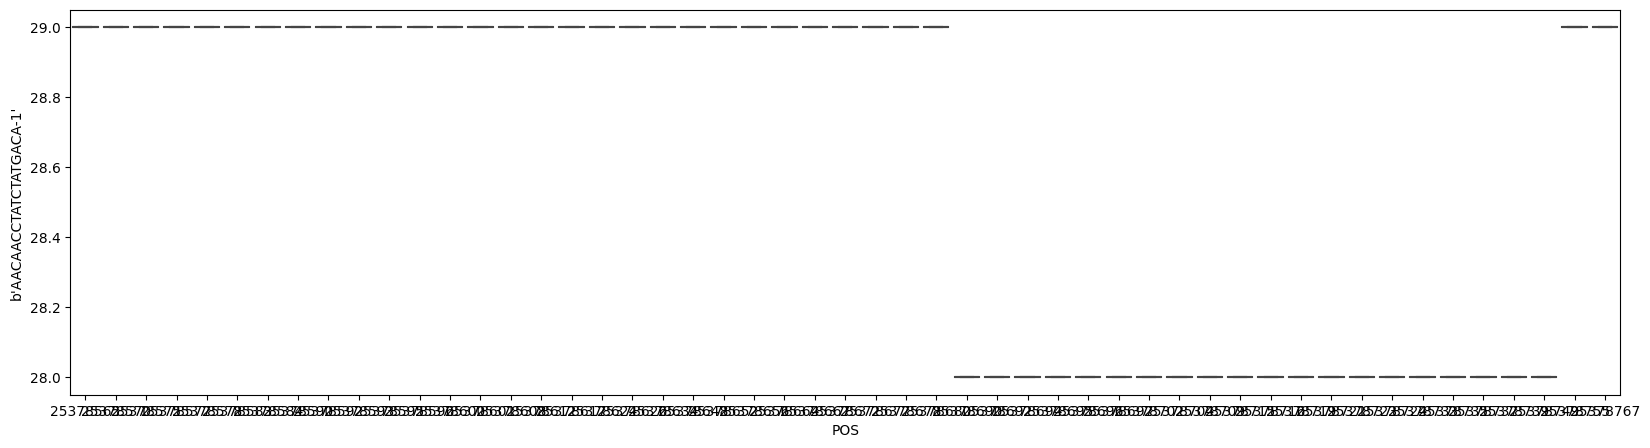

In [190]:
rd_var_same_pos = sanity_snv.copy()
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.duplicated(keep=False)]
amplicon_with_max_var_same_pos = rd_var_same_pos.groupby('amplicon').count().sort_values('sum',ascending=False).index[0]
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.amplicon == amplicon_with_max_var_same_pos].drop(['sum','amplicon'],axis=1)
rd_var_same_pos['POS'] = rd_var_same_pos['POS'].apply(str)

cell = b'AACAACCTATCTATGACA-1'# b'AACAACCTACAGAAGTGA-1' 
plt.figure(figsize=(20,5))
sns.boxplot(data = rd_var_same_pos[[cell,'POS']], x='POS', y=cell)

In [195]:
rd_var_same_pos.groupby('POS').count().head()

b'AACAACCTACAGAAGTGA-1'  b'AACAACCTATCTATGACA-1'   
POS                                                          
25378565                        2                        2  \
25378570                        2                        2   
25378575                        2                        2   
25378577                        2                        2   
25378578                        2                        2   

          b'AACAACTGGCAACGCACA-1'  b'AACACACTCTTACAGTGT-1'   
POS                                                          
25378565                        2                        2  \
25378570                        2                        2   
25378575                        2                        2   
25378577                        2                        2   
25378578                        2                        2   

          b'AACAGCAGTCGTCTGCTG-1'  b'AACAGCAGTGATGCTCCT-1'   
POS                                                          
25378565                        2                        2  \
25378570                        2                        2   
25378575                        2                        2   
25378577                        2                        2   
25378578                        2                        2   

          b'AACCGCTGAAACAACCTA-1'  b'AACCGCTGAACCACGCTA-1'   
POS                                                          
25378565                        2                        2  \
25378570                        2                        2   
25378575                        2                        2   
25378577                        2                        2   
25378578                        2                        2   

          b'AACGCATTGCGTTAATGG-1'  b'AACGCCTACACCATACTT-1'  ...   
POS                                                         ...   
25378565                        2                        2  ...  \
25378570                        2                        2  ...   
25378575                        2                        2  ...   
25378577                        2                        2  ...   
25378578                        2                        2  ...   

          b'TTGCAGTCATGCTATGAA-1'  b'TTGCCAGATATGGACGTT-1'   
POS                                                          
25378565                        2                        2  \
25378570                        2                        2   
25378575                        2                        2   
25378577                        2                        2   
25378578                        2                        2   

          b'TTGCCAGATTCCTTCGTA-1'  b'TTGCCGTAGAGATGAGAT-1'   
POS                                                          
25378565                        2                        2  \
25378570                        2                        2   
25378575                        2                        2   
25378577                        2                        2   
25378578                        2                        2   

          b'TTGCCGTAGGAGGTGAGC-1'  b'TTGGACTTCCGCTTATGA-1'   
POS                                                          
25378565                        2                        2  \
25378570                        2                        2   
25378575                        2                        2   
25378577                        2                        2   
25378578                        2                        2   

          b'TTGGAGAACTGAACTTGC-1'  b'TTGGTAACTTCTGCGCTG-1'   
POS                                                          
25378565                        2                        2  \
25378570                        2                        2   
25378575                        2                        2   
25378577                        2                        2   
25378578                        2                        2   

          b'TTGTCAACCGCAGCAGTG-1'  b'TTGTTAGAGAATCTCCTA-1'  

We were expected for one region covered by the panel that all positions have the same coverage( perfect mappability) but some variabilities for the coverage of variant in the same position

<Axes: xlabel='POS', ylabel="b'AACAACCTACAGAAGTGA-1'">

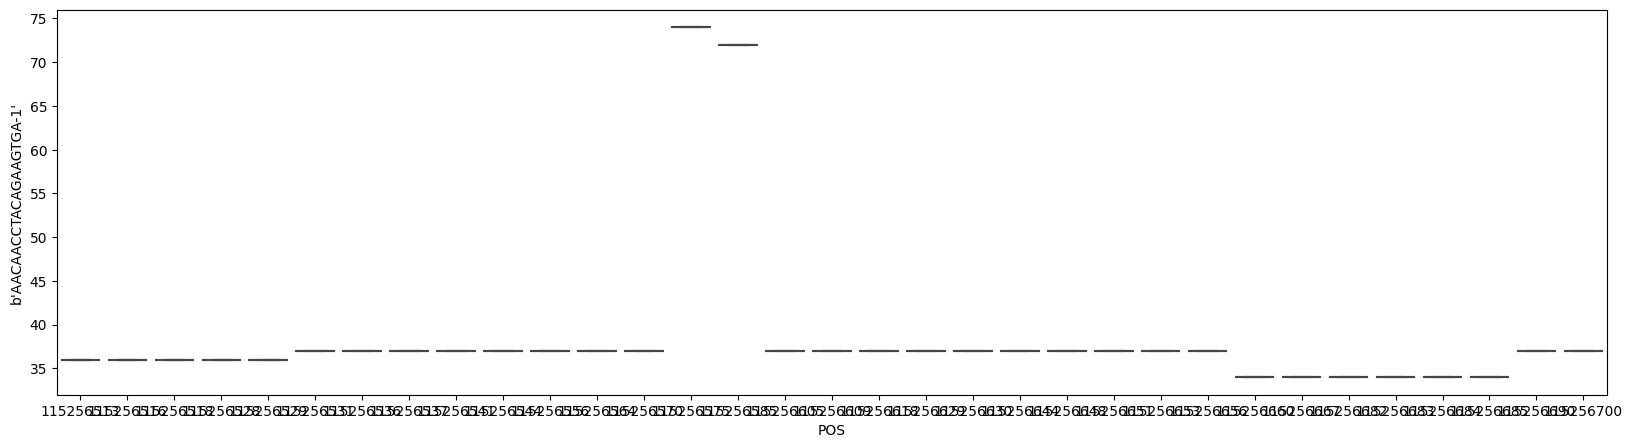

In [235]:
rd_var_same_pos = sanity_snv.copy()
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.duplicated(keep=False)]
amplicon_check = b'AML_v2_NRAS_115256512'
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.amplicon == amplicon_check].drop(['sum','amplicon'],axis=1)
rd_var_same_pos['POS'] = rd_var_same_pos['POS'].apply(str)

cell = b'AACAACCTACAGAAGTGA-1'# b'AACAACCTATCTATGACA-1'# b'AACAACCTACAGAAGTGA-1' 
plt.figure(figsize=(20,5))
sns.boxplot(data = rd_var_same_pos[[cell,'POS']].sort_values('POS'), x='POS', y=cell)

<Axes: xlabel='POS', ylabel="b'AACAACCTACAGAAGTGA-1'">

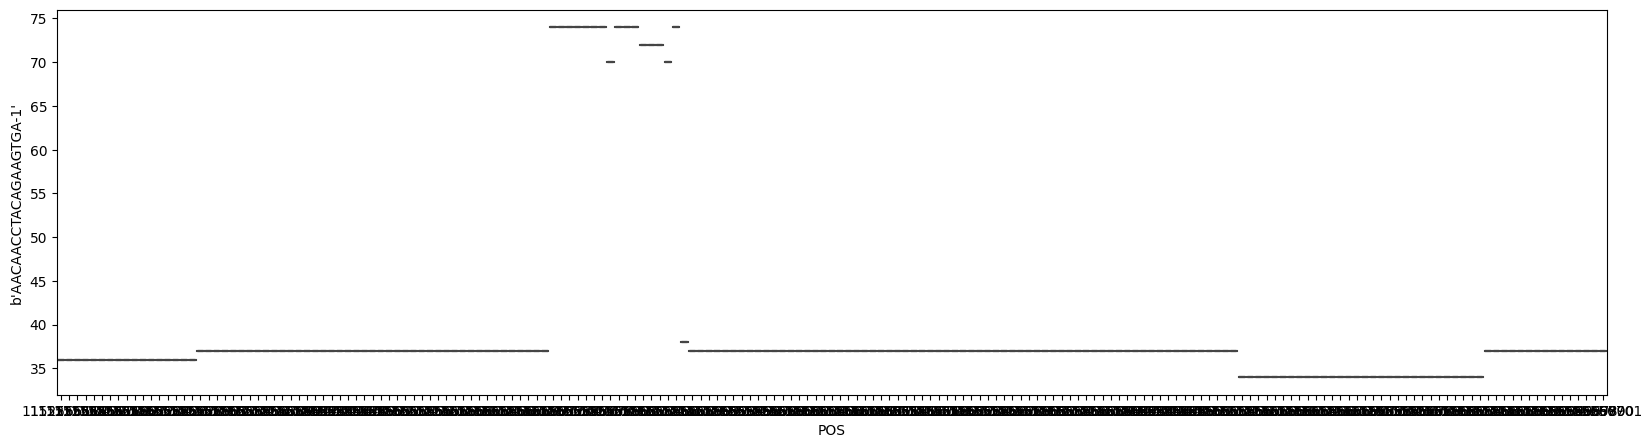

In [229]:
rd_var_same_pos = sanity_snv.copy()
#rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.duplicated(keep=False)]
amplicon_check = b'AML_v2_NRAS_115256512'
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.amplicon == amplicon_check].drop(['sum','amplicon'],axis=1)
rd_var_same_pos['POS'] = rd_var_same_pos['POS'].apply(str)

cell = b'AACAACCTACAGAAGTGA-1'# b'AACAACCTATCTATGACA-1'# b'AACAACCTACAGAAGTGA-1' 
plt.figure(figsize=(20,5))
sns.boxplot(data = rd_var_same_pos[[cell,'POS']].sort_values('POS'), x='POS', y=cell)

<Axes: xlabel='sum', ylabel='Count'>

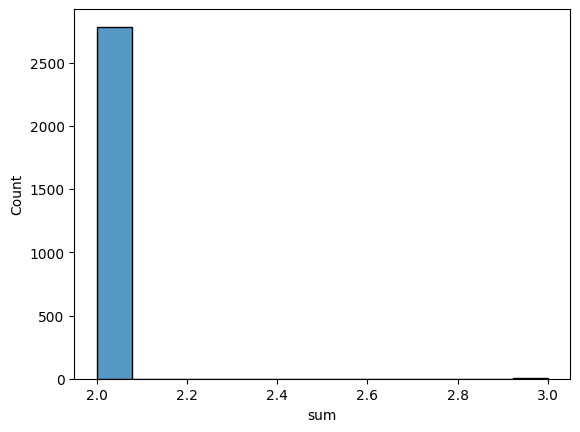

In [236]:
rd_var_same_pos = sanity_snv.copy()
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.duplicated(keep=False)]
"""amplicon_with_max_var_same_pos = rd_var_same_pos.groupby('amplicon').count().sort_values('sum',ascending=False).index[0]
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.amplicon == amplicon_with_max_var_same_pos].drop(['sum','amplicon'],axis=1)
rd_var_same_pos['POS'] = rd_var_same_pos['POS'].apply(str)"""
rd_var_same_pos

# nb of different variant at same position
sns.histplot(rd_var_same_pos.groupby(['POS']).count()['sum'])

In [214]:
(rd_var_same_pos.drop(columns='amplicon').groupby('POS').max() - rd_var_same_pos.drop(columns='amplicon').groupby('POS').min()).sum().sum() # all variants in same position has same coverages (max = min)

0

In [134]:
sanity_snv.drop_duplicates().groupby('amplicon').sum()

b'AACAACCTACAGAAGTGA-1'  b'AACAACCTATCTATGACA-1'   
amplicon                                                                     
b'AML_v2_ASXL1_30956774'                     7797                     9224  \
b'AML_v2_ASXL1_31015840'                     8496                     7503   
b'AML_v2_ASXL1_31021160'                     8115                     6441   
b'AML_v2_ASXL1_31021460'                     3485                     1435   
b'AML_v2_ASXL1_31022192'                     6008                     2484   
...                                           ...                      ...   
b'AML_v2_WT1_32413452'                       7352                     4589   
b'AML_v2_WT1_32414209'                       5684                    10276   
b'AML_v2_WT1_32417780'                       6384                     7227   
b'AML_v2_WT1_32421532'                      10583                     6256   
b'AML_v2_WT1_32439105'                      10480                    10940   

                          b'AACAACTGGCAACGCACA-1'  b'AACACACTCTTACAGTGT-1'   
amplicon                                                                     
b'AML_v2_ASXL1_30956774'                     8697                    10489  \
b'AML_v2_ASXL1_31015840'                     9639                    10811   
b'AML_v2_ASXL1_31021160'                     8369                     8343   
b'AML_v2_ASXL1_31021460'                     4562                     5557   
b'AML_v2_ASXL1_31022192'                     5435                     5611   
...                                           ...                      ...   
b'AML_v2_WT1_32413452'                       3007                     3453   
b'AML_v2_WT1_32414209'                       6781                    10712   
b'AML_v2_WT1_32417780'                       5436                     7450   
b'AML_v2_WT1_32421532'                      11801                    10804   
b'AML_v2_WT1_32439105'                       9782                    10644   

                          b'AACAGCAGTCGTCTGCTG-1'  b'AACAGCAGTGATGCTCCT-1'   
amplicon                                                                     
b'AML_v2_ASXL1_30956774'                    10580                    11099  \
b'AML_v2_ASXL1_31015840'                    10338                    10374   
b'AML_v2_ASXL1_31021160'                    10473                     7353   
b'AML_v2_ASXL1_31021460'                     6573                     2993   
b'AML_v2_ASXL1_31022192'                     7865                    10350   
...                                           ...                      ...   
b'AML_v2_WT1_32413452'                       5458                     8884   
b'AML_v2_WT1_32414209'                       6495                     9949   
b'AML_v2_WT1_32417780'                       8656                    10499   
b'AML_v2_WT1_32421532'                      10867                    10560   
b'AML_v2_WT1_32439105'                      11410                    11021   

                          b'AACCGCTGAAACAACCTA-1'  b'AACCGCTGAACCACGCTA-1'   
amplicon                                                                     
b'AML_v2_ASXL1_30956774'                     7414                     9417  \
b'AML_v2_ASXL1_31015840'                     7751                    10194   
b'AML_v2_ASXL1_31021160'                     7306                    10401   
b'AML_v2_ASXL1_31021460'                     4942                     4530   
b'AML_v2_ASXL1_31022192'                     4784                     6031   
...                                           ...                      ...   
b'AML_v2_WT1_32413452'                       4650                     9539   
b'AML_v2_WT1_32414209'                       5709                    10163   
b'AML_v2_WT1_32417780'                       6824                     8477   
b'AML_v2_WT1_32421532'                       8818                    11270   
b'AML_v2_WT1_32439105'                       

<Axes: xlabel='amplicon', ylabel="b'AACAACCTACAGAAGTGA-1'">

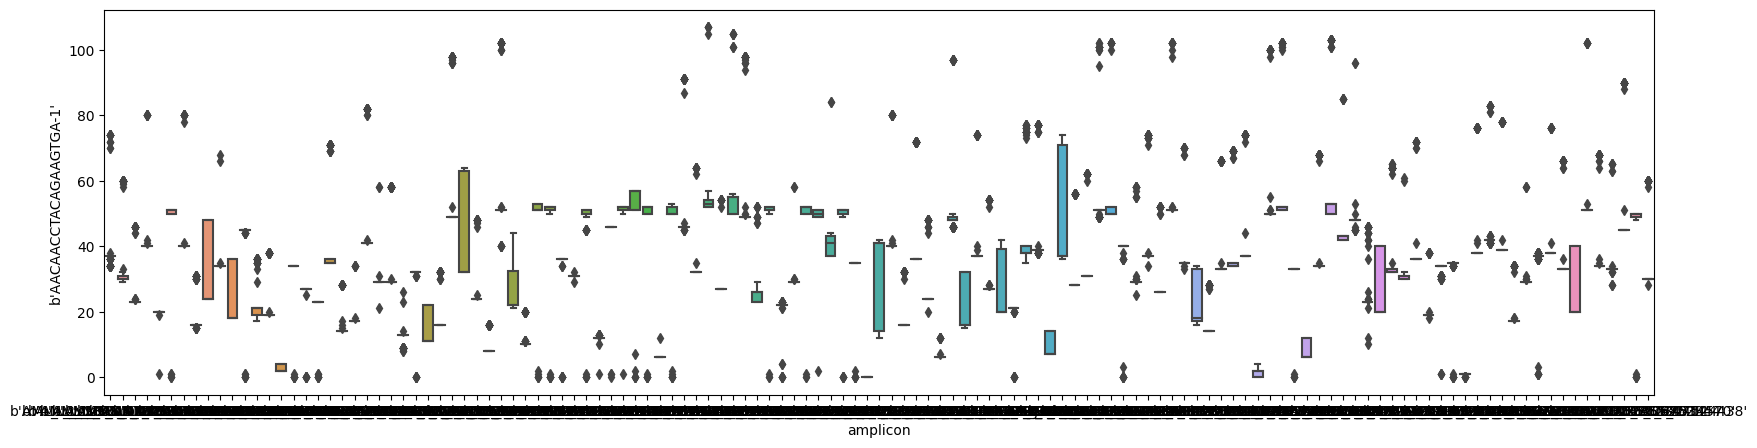

In [151]:
cell = b'AACAACCTACAGAAGTGA-1'
data = sanity_snv.drop_duplicates()[[cell,'amplicon']]  #.groupby('amplicon').min() #- sanity_snv.drop_duplicates().groupby('amplicon').min()
plt.figure(figsize=(20,5))
sns.boxplot(data = data, x="amplicon", y = cell	) # no normalization

In [114]:
variants.groupby(['amplicon','POS']).count()

ALT  CHROM  QUAL  REF  ado_gt_cells   
amplicon                 POS                                             
b'AML_v2_ASXL1_30956774' 30956775    1      1     1    1             1  \
                         30956776    1      1     1    1             1   
                         30956777    1      1     1    1             1   
                         30956778    2      2     2    2             2   
                         30956779    1      1     1    1             1   
...                                ...    ...   ...  ...           ...   
b'AML_v2_WT1_32439105'   32439294    1      1     1    1             1   
                         32439295    1      1     1    1             1   
                         32439296    1      1     1    1             1   
                         32439297    1      1     1    1             1   
                         32439298    2      2     2    2             2   

                                   ado_rate  filtered  id  
amplicon                 POS                               
b'AML_v2_ASXL1_30956774' 30956775         1         1   1  
                         30956776         1         1   1  
                         30956777         1         1   1  
                         30956778         2         2   2  
                         30956779         1         1   1  
...                                     ...       ...  ..  
b'AML_v2_WT1_32439105'   32439294         1         1   1  
                         32439295         1         1   1  
                         32439296         1         1   1  
                         32439297         1         1   1  
                         32439298         2         2   2  

[24110 rows x 8 columns]

In [4]:
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv['POS'] = variants.POS.values
sanity_snv.groupby('amplicon').nunique()

b'AACAACCTACAGAAGTGA-1'  b'AACAACCTATCTATGACA-1'   
amplicon                                                                     
b'AML_v2_ASXL1_30956774'                        4                        5  \
b'AML_v2_ASXL1_31015840'                        5                        5   
b'AML_v2_ASXL1_31021160'                        3                        4   
b'AML_v2_ASXL1_31021460'                        4                        2   
b'AML_v2_ASXL1_31022192'                        4                        2   
...                                           ...                      ...   
b'AML_v2_WT1_32413452'                          5                        6   
b'AML_v2_WT1_32414209'                          2                        4   
b'AML_v2_WT1_32417780'                          3                        4   
b'AML_v2_WT1_32421532'                          7                        5   
b'AML_v2_WT1_32439105'                          4                        8   

                          b'AACAACTGGCAACGCACA-1'  b'AACACACTCTTACAGTGT-1'   
amplicon                                                                     
b'AML_v2_ASXL1_30956774'                        4                        6  \
b'AML_v2_ASXL1_31015840'                        5                        7   
b'AML_v2_ASXL1_31021160'                        7                        5   
b'AML_v2_ASXL1_31021460'                        7                        4   
b'AML_v2_ASXL1_31022192'                        3                        6   
...                                           ...                      ...   
b'AML_v2_WT1_32413452'                          6                        3   
b'AML_v2_WT1_32414209'                          7                        7   
b'AML_v2_WT1_32417780'                          6                        3   
b'AML_v2_WT1_32421532'                          6                        7   
b'AML_v2_WT1_32439105'                          5                        5   

                          b'AACAGCAGTCGTCTGCTG-1'  b'AACAGCAGTGATGCTCCT-1'   
amplicon                                                                     
b'AML_v2_ASXL1_30956774'                        6                        5  \
b'AML_v2_ASXL1_31015840'                        6                        6   
b'AML_v2_ASXL1_31021160'                        5                        5   
b'AML_v2_ASXL1_31021460'                        4                        5   
b'AML_v2_ASXL1_31022192'                        4                        2   
...                                           ...                      ...   
b'AML_v2_WT1_32413452'                          4                        5   
b'AML_v2_WT1_32414209'                          5                        5   
b'AML_v2_WT1_32417780'                          5                        6   
b'AML_v2_WT1_32421532'                          6                        5   
b'AML_v2_WT1_32439105'                          7                        5   

                          b'AACCGCTGAAACAACCTA-1'  b'AACCGCTGAACCACGCTA-1'   
amplicon                                                                     
b'AML_v2_ASXL1_30956774'                        4                        7  \
b'AML_v2_ASXL1_31015840'                        4                        5   
b'AML_v2_ASXL1_31021160'                        4                        7   
b'AML_v2_ASXL1_31021460'                        3                        5   
b'AML_v2_ASXL1_31022192'                        2                        4   
...                                           ...                      ...   
b'AML_v2_WT1_32413452'                          4                        4   
b'AML_v2_WT1_32414209'                          5                        6   
b'AML_v2_WT1_32417780'                          4                        3   
b'AML_v2_WT1_32421532'                          6                        8   
b'AML_v2_WT1_32439105'                       

<Axes: xlabel='amplicon'>

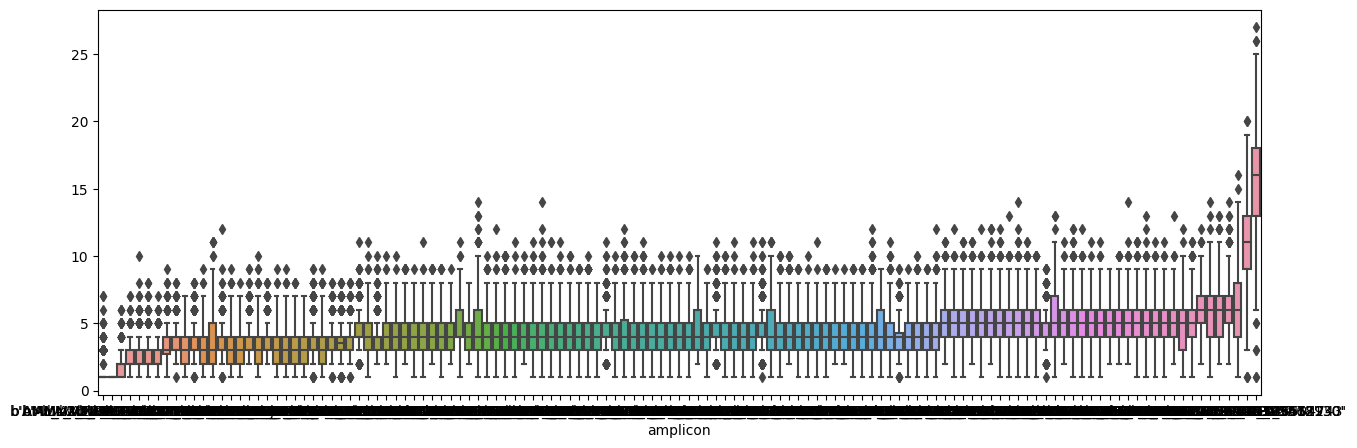

In [13]:
diff_rc_amplicon = sanity_snv.groupby('amplicon').nunique().drop(['sum','POS'], axis=1).T
plt.figure(figsize=(15,5))
sns.boxplot(data = diff_rc_amplicon[diff_rc_amplicon.median().sort_values().index]) 

## CNA amplicon

## read count and mean cov/ amplicon comparison

#### read count norm + cluster

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


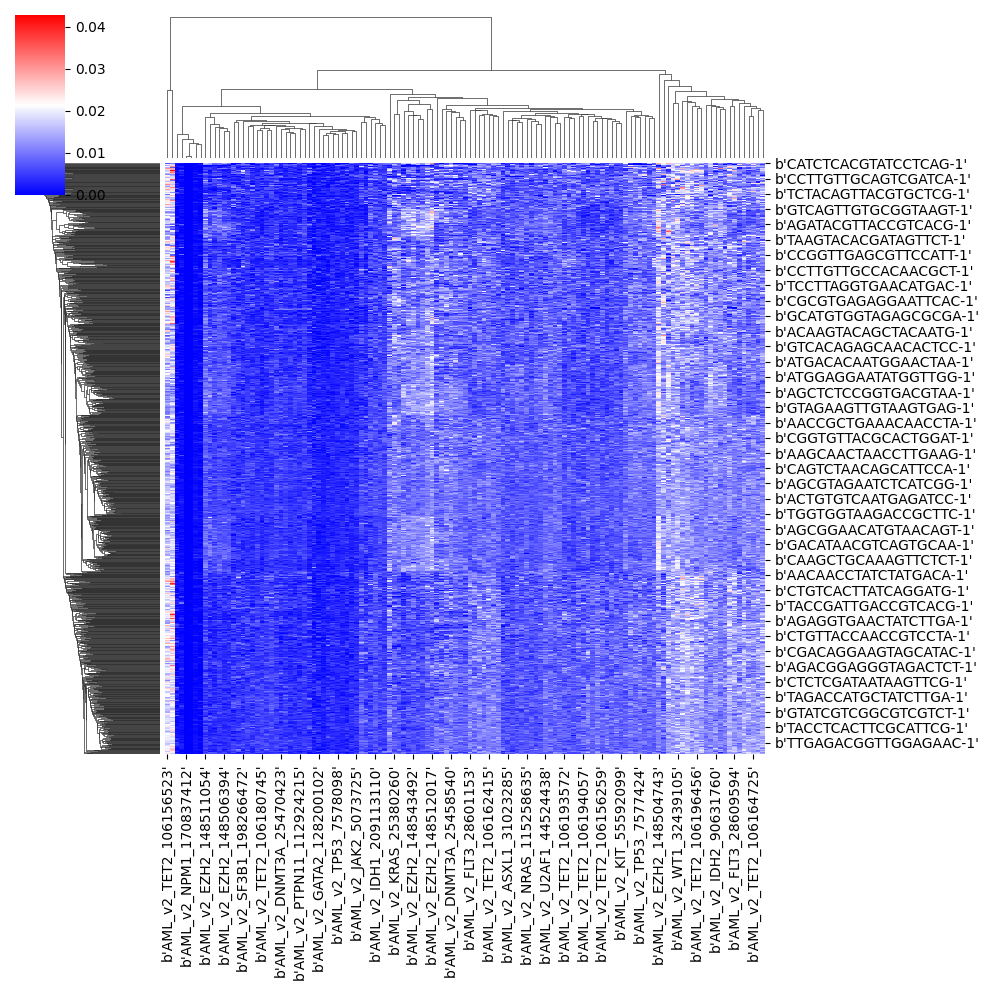

In [25]:
#mean_tot_nb_read_cell = read_counts.sum(axis=1).mean()
read_cluster = sns.clustermap((read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)), col_cluster=True, cmap="bwr") # cluster after normalization*
read_cluster

#### mean coverage / amplicon

In [26]:
variants[['id','amplicon']].drop_duplicates().set_index('id').amplicon

id
b'chr1:115256513:G/A'    b'AML_v2_NRAS_115256512'
b'chr1:115256513:G/T'    b'AML_v2_NRAS_115256512'
b'chr1:115256514:G/A'    b'AML_v2_NRAS_115256512'
b'chr1:115256515:C/'     b'AML_v2_NRAS_115256512'
b'chr1:115256516:A/G'    b'AML_v2_NRAS_115256512'
                                   ...           
b'chr21:44524605:T/C'    b'AML_v2_U2AF1_44524438'
b'chr21:44524606:T/C'    b'AML_v2_U2AF1_44524438'
b'chr21:44524607:A/'     b'AML_v2_U2AF1_44524438'
b'chr21:44524608:A/G'    b'AML_v2_U2AF1_44524438'
b'chr21:44524609:C/'     b'AML_v2_U2AF1_44524438'
Name: amplicon, Length: 26910, dtype: object

In [27]:
covs_df= covs.unstack().reset_index().rename(columns = {'level_0':'variant','level_1':'cell',0:"counts"})
covs_df['amplicon'] = covs_df.variant.map(variants[['id','amplicon']].drop_duplicates().set_index('id').amplicon)
covs_df = covs_df.groupby(['cell','amplicon']).counts.mean().reset_index()

#### mean coverage / amplicon + norm + cmuster

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


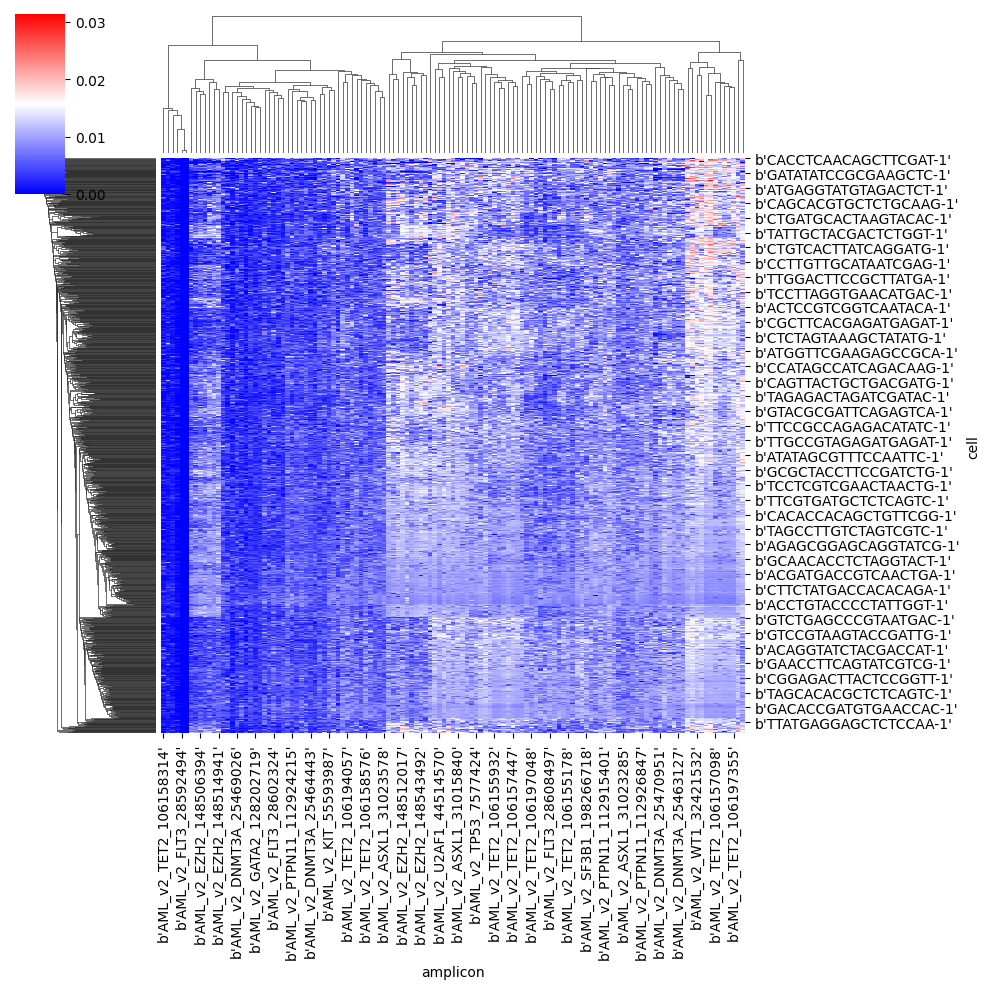

In [28]:
covs_table = covs_df.pivot_table(index='cell',columns = 'amplicon',values = 'counts',aggfunc = 'first')
sns.clustermap(covs_table.apply(lambda x : x/covs_table.sum(axis=1), axis=0),cmap="bwr")

#### read count + norm + cluster  heatmap

<Axes: >

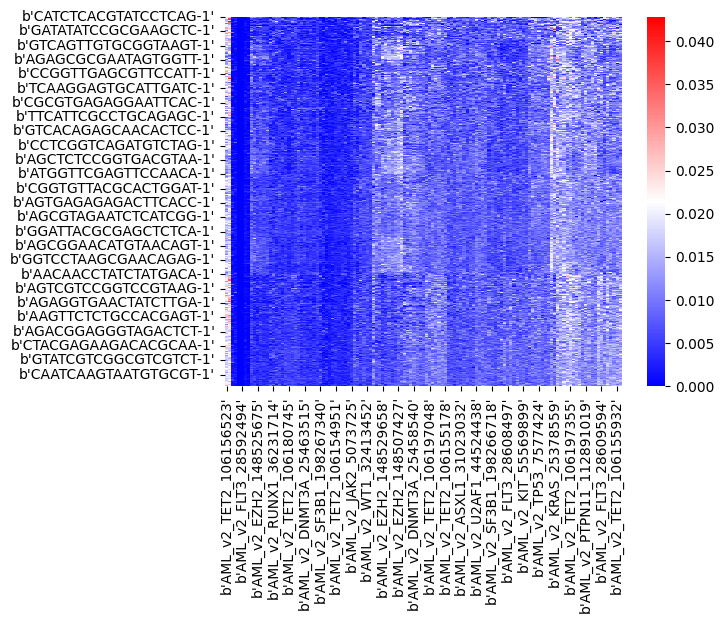

In [29]:
read_counts_reorder = read_counts.copy()
read_counts_reorder = read_counts_reorder[read_counts_reorder.columns.values[read_cluster.dendrogram_col.reordered_ind]]
read_counts_reorder = read_counts_reorder.reindex(read_counts_reorder.index.values[read_cluster.dendrogram_row.reordered_ind])
sns.heatmap(read_counts_reorder.apply(lambda x : x/read_counts_reorder.sum(axis=1), axis=0),cmap="bwr")

#### mean cov / amplicon + norm + reorder by cluster read count norm + heatmap

<Axes: xlabel='amplicon', ylabel='cell'>

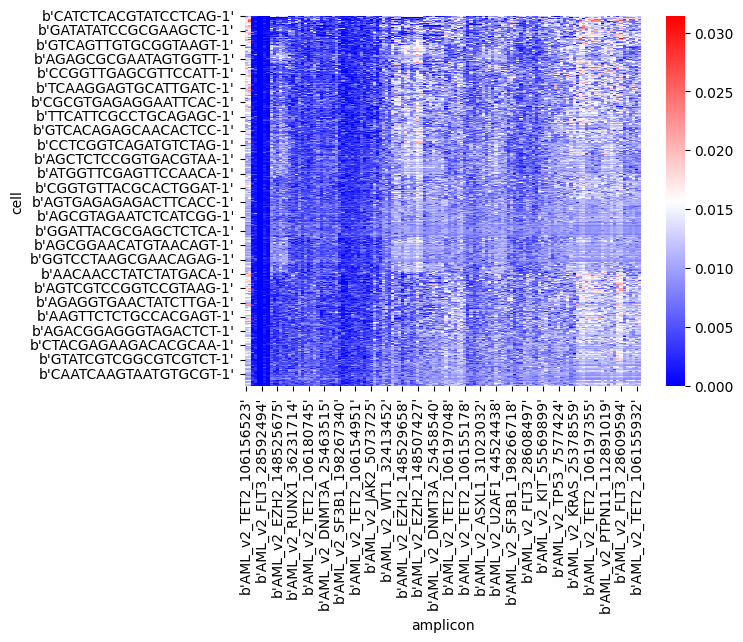

In [35]:
covs_table_reorder = covs_table.copy()
covs_table_reorder = covs_table_reorder[read_counts.columns.values[read_cluster.dendrogram_col.reordered_ind]]
covs_table_reorder = covs_table_reorder.reindex(read_counts.index.values[read_cluster.dendrogram_row.reordered_ind])
sns.heatmap(covs_table_reorder.apply(lambda x : x/covs_table_reorder.sum(axis=1), axis=0),cmap="bwr")

# Other clustermap

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


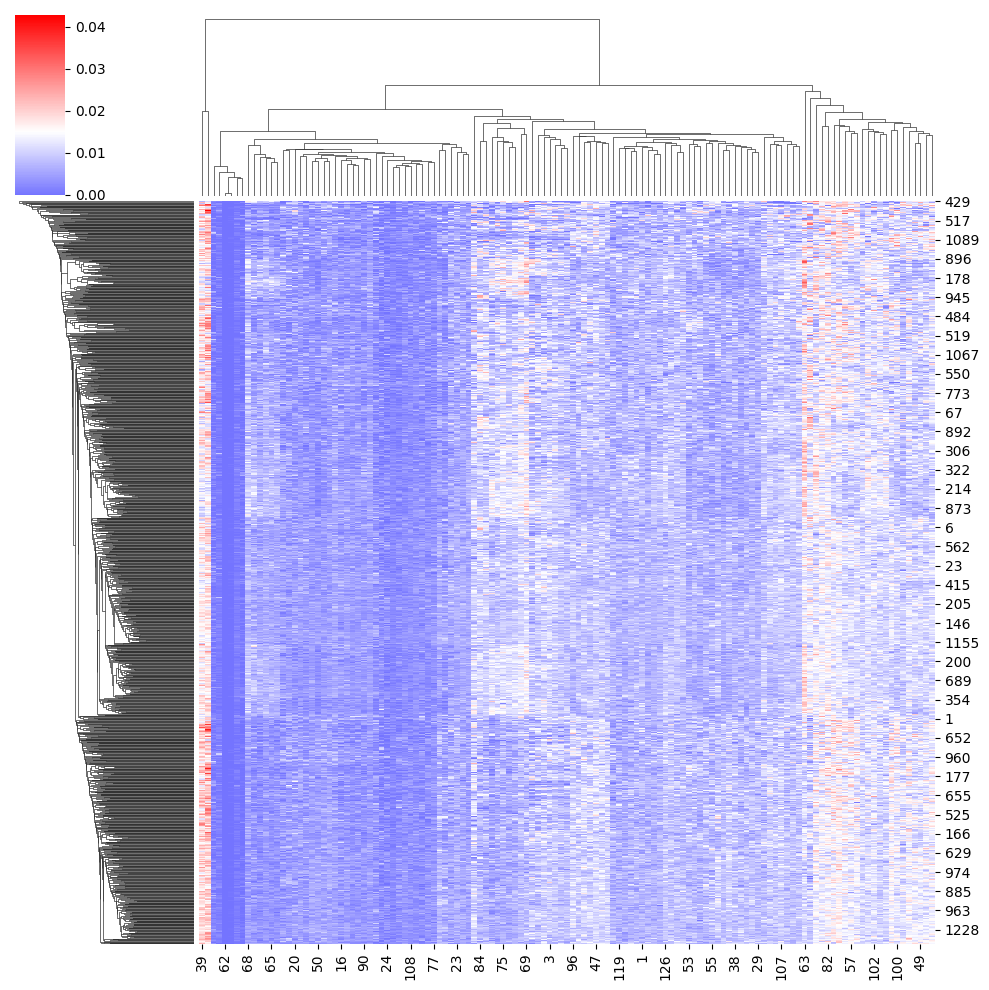

In [10]:
sns.clustermap((read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy(), col_cluster=True, cmap="bwr", center = 0.015) # cluster after normalization

In [9]:
read_counts.unstack().reset_index()

level_0                  level_1   0
0       b'AML_v2_NRAS_115256512'  b'AACAACCTACAGAAGTGA-1'  37
1       b'AML_v2_NRAS_115256512'  b'AACAACCTATCTATGACA-1'  11
2       b'AML_v2_NRAS_115256512'  b'AACAACTGGCAACGCACA-1'  44
3       b'AML_v2_NRAS_115256512'  b'AACACACTCTTACAGTGT-1'  59
4       b'AML_v2_NRAS_115256512'  b'AACAGCAGTCGTCTGCTG-1'  31
...                          ...                      ...  ..
157475  b'AML_v2_U2AF1_44524438'  b'TTGGACTTCCGCTTATGA-1'  16
157476  b'AML_v2_U2AF1_44524438'  b'TTGGAGAACTGAACTTGC-1'  92
157477  b'AML_v2_U2AF1_44524438'  b'TTGGTAACTTCTGCGCTG-1'  45
157478  b'AML_v2_U2AF1_44524438'  b'TTGTCAACCGCAGCAGTG-1'  48
157479  b'AML_v2_U2AF1_44524438'  b'TTGTTAGAGAATCTCCTA-1'  63

[157480 rows x 3 columns]

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


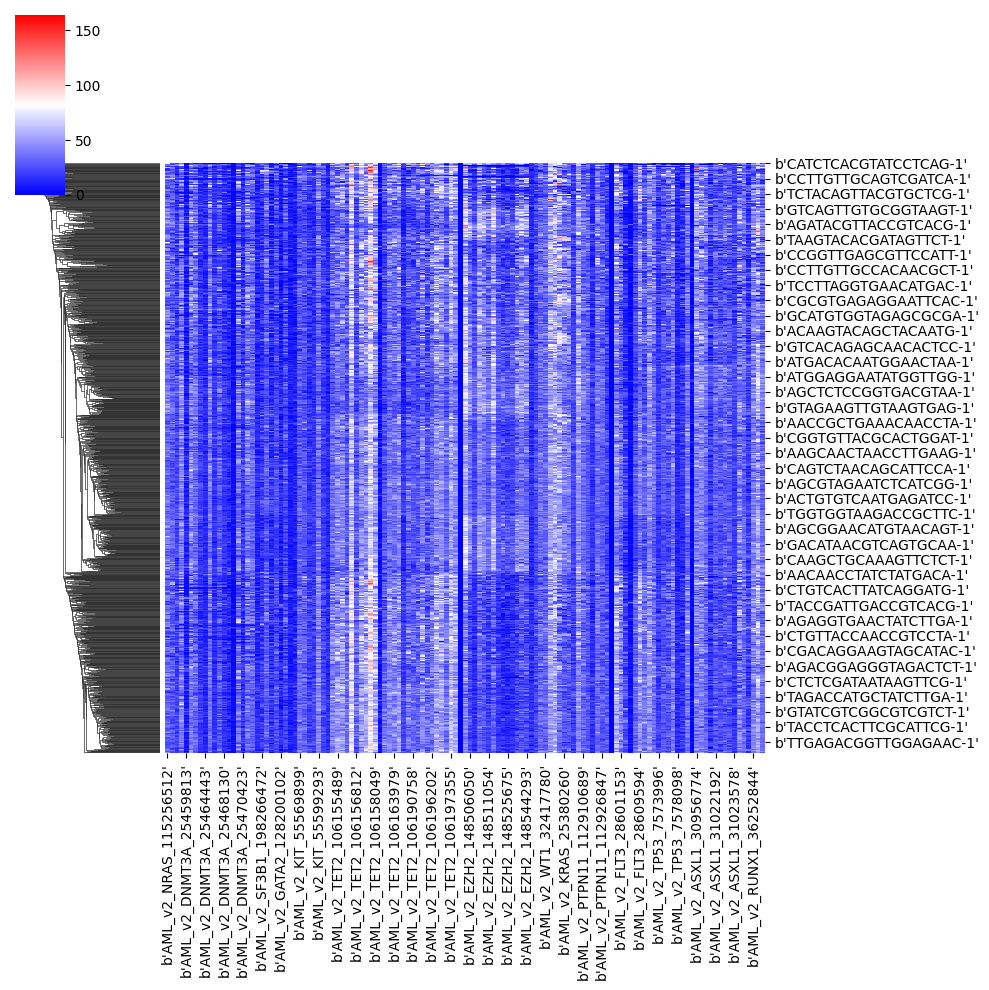

In [79]:
mean_tot_nb_read_cell = read_counts.sum(axis=1).mean()
sns.clustermap(read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)*mean_tot_nb_read_cell, col_cluster=False, cmap="bwr") # cluster after normalization and new magnitude

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


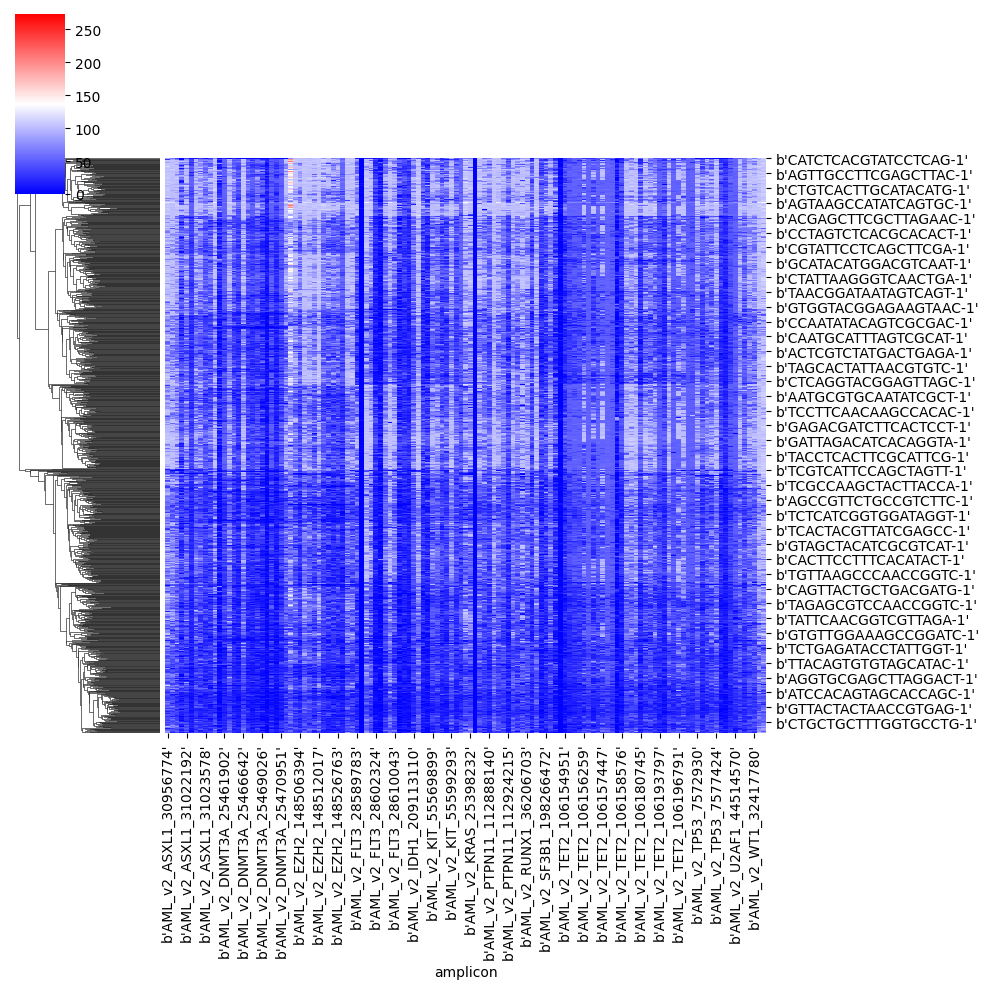

In [36]:
sns.clustermap(max_amplicon, col_cluster=False, cmap="bwr") # cluster when read count = max read count of variant for amplicon and cell

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


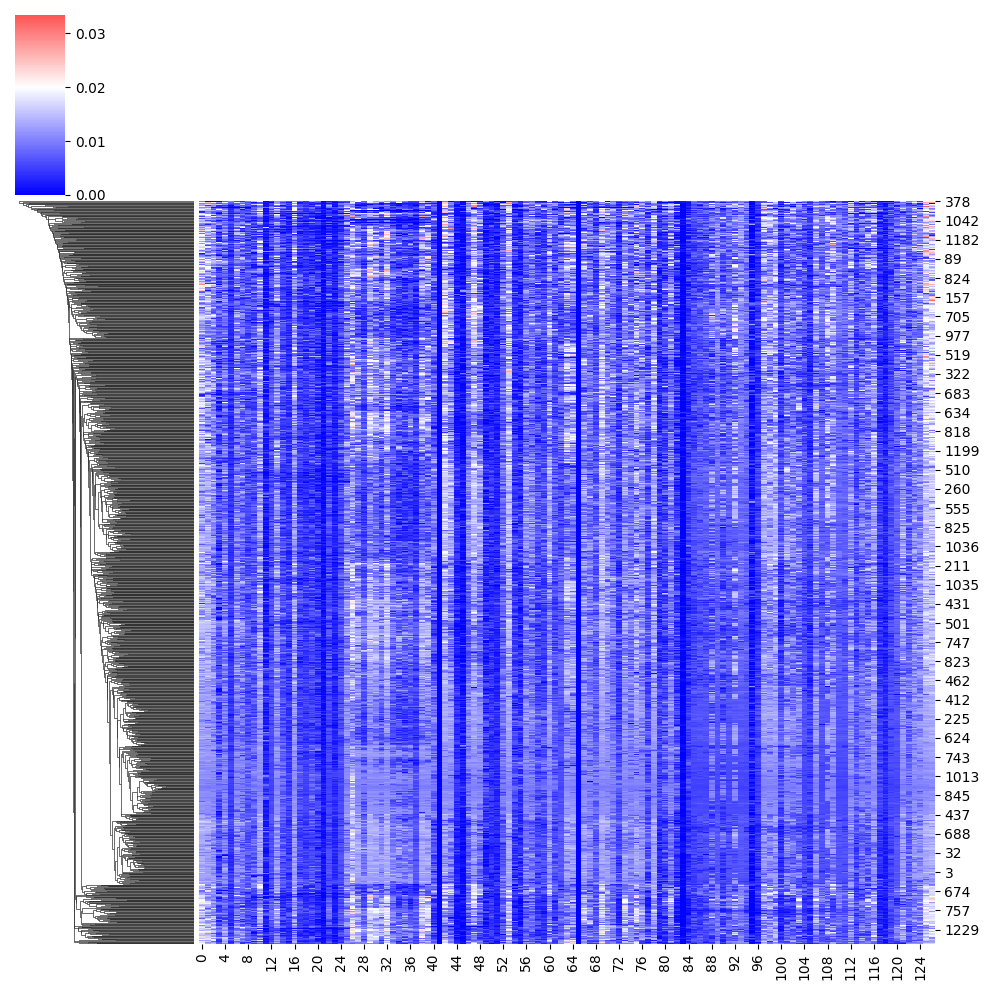

In [37]:
sns.clustermap((max_amplicon.apply(lambda x : x/max_amplicon.sum(axis=1), axis=0)).to_numpy(), col_cluster=False, cmap="bwr",center = 0.02) # same but after normalization

looks closer to thnormalized read count table

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


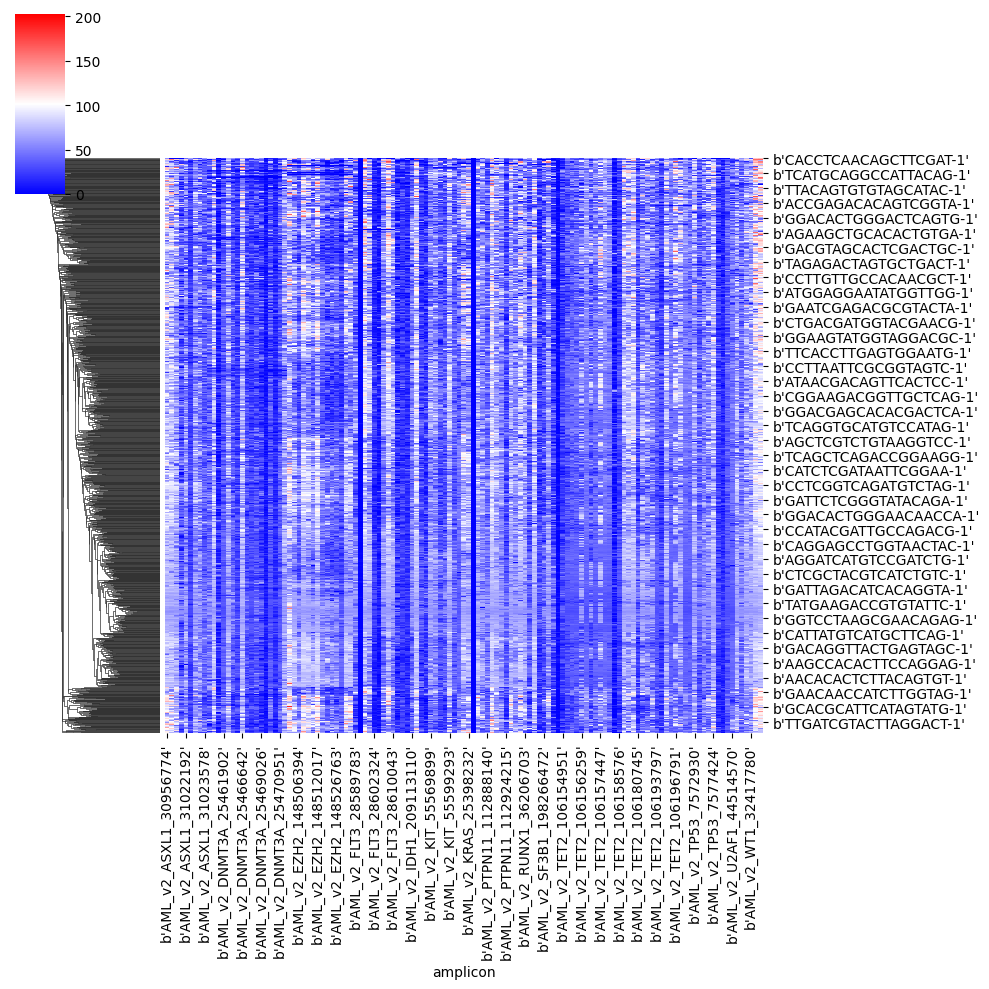

In [81]:
mean_tot_nb_read_cell = max_amplicon.sum(axis=1).mean()
sns.clustermap(max_amplicon.apply(lambda x : x/max_amplicon.sum(axis=1), axis=0)*mean_tot_nb_read_cell, col_cluster=False, cmap="bwr") # same after change in magnitude

### Amplicon distribution : search for outliers

<Axes: >

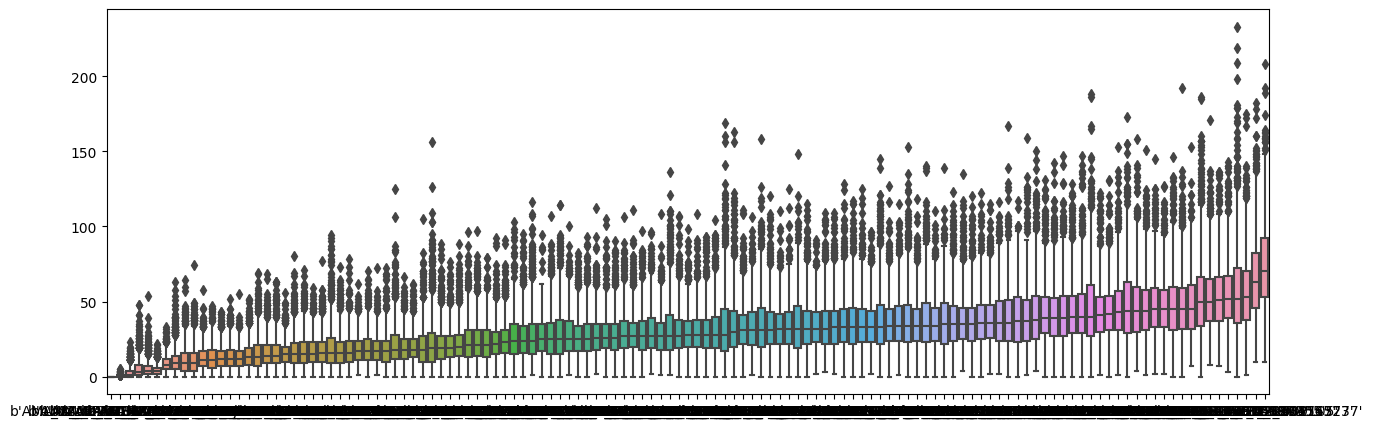

In [55]:
plt.figure(figsize=(15,5))
sns.boxplot(data = read_counts[read_counts.median().sort_values().index]) # no normalization

In [33]:
normalized_read_counts = read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)

<Axes: >

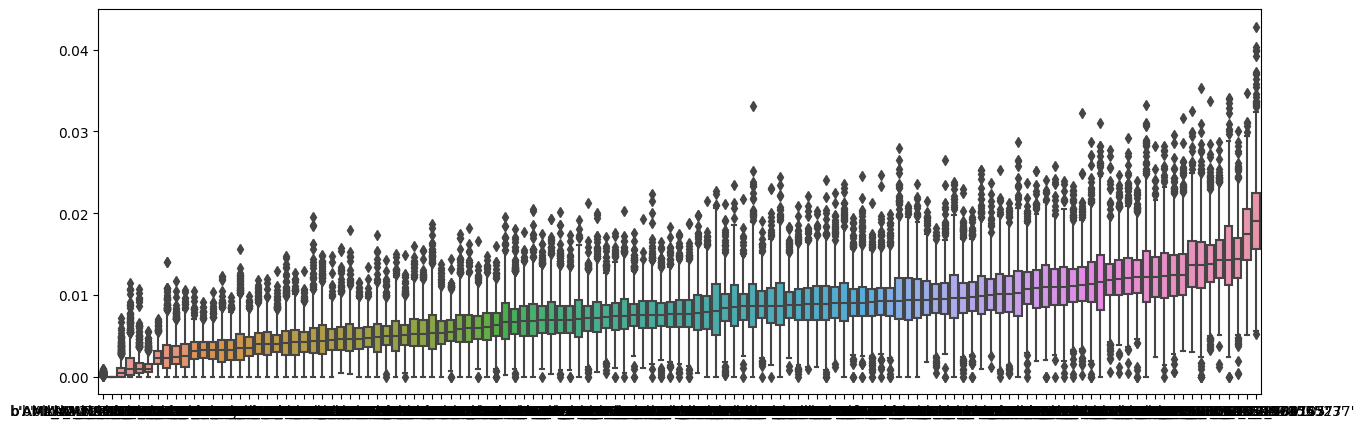

In [60]:
plt.figure(figsize=(15,5))
sns.boxplot(data = normalized_read_counts[normalized_read_counts.median().sort_values().index]) # normalized

<Axes: >

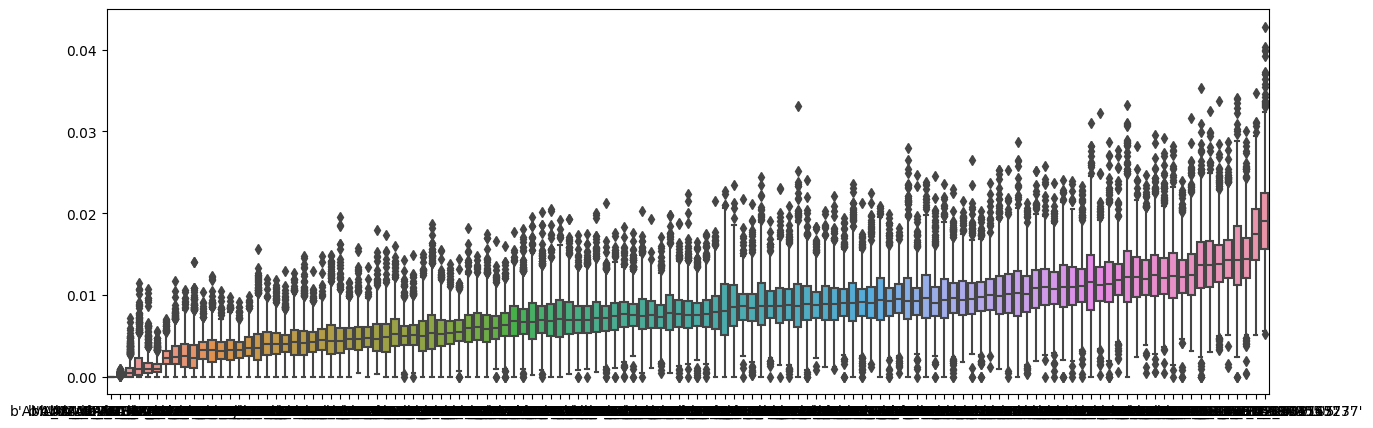

In [61]:
plt.figure(figsize=(15,5))
sns.boxplot(data = normalized_read_counts[read_counts.median().sort_values().index]) # normalized but ordered before normalization

In [58]:
read_counts.sum().sort_values() # one amplicon as 0 read

b'AML_v2_NPM1_170837412'         0
b'AML_v2_FLT3_28592494'        309
b'AML_v2_SRSF2_74732219'      3348
b'AML_v2_DNMT3A_25469428'     5437
b'AML_v2_FLT3_28608210'       6102
                             ...  
b'AML_v2_TET2_106197355'     67824
b'AML_v2_WT1_32439105'       69072
b'AML_v2_EZH2_148504743'     71033
b'AML_v2_TET2_106156523'     81980
b'AML_v2_TET2_106157777'     90216
Length: 127, dtype: int64

In [151]:
df = amplicons[['id','CHROM']].set_index('id').reindex(normalized_read_counts.median().sort_values().index)
a, unique = pd.factorize(df.stack())
palette = sns.color_palette(None, len(unique)).as_hex()
chrom_amplicon = pd.DataFrame(a.reshape(df.shape),
                         index=df.index, columns=df.columns).CHROM.values

In [150]:
palette = sns.husl_palette(14)

In [153]:
chrom_amplicon

array([ 0,  1,  2,  3,  0,  4,  5,  4,  3,  5,  2,  4,  3,  4,  4,  4,  6,
        7,  3,  4,  2,  4,  4,  4,  0,  3,  3,  8,  4,  2,  9,  9, 10,  3,
       10, 10, 10,  4,  7,  5,  0, 11, 10,  4,  3,  9,  3,  4,  9,  3,  2,
        0, 10,  2,  3,  3,  3,  3,  7,  3,  4,  7, 12,  9,  9,  3,  0, 10,
        4, 10, 11,  4, 11,  3, 10,  8,  4, 12,  3,  0,  3,  7,  7,  7,  8,
        9,  2,  7, 10,  4,  3,  3,  2, 10,  4,  2,  3,  3,  4,  4,  8,  8,
        3, 10,  3,  3,  9,  9,  0, 10, 13,  3,  3,  7,  7,  3,  0,  3,  3,
        3,  8, 11,  3, 10, 11,  3,  3], dtype=int64)

In [155]:
df.to_numpy()

array([[b'13'],
       [b'5'],
       [b'17'],
       [b'4'],
       [b'13'],
       [b'2'],
       [b'3'],
       [b'2'],
       [b'4'],
       [b'3'],
       [b'17'],
       [b'2'],
       [b'4'],
       [b'2'],
       [b'2'],
       [b'2'],
       [b'9'],
       [b'12'],
       [b'4'],
       [b'2'],
       [b'17'],
       [b'2'],
       [b'2'],
       [b'2'],
       [b'13'],
       [b'4'],
       [b'4'],
       [b'21'],
       [b'2'],
       [b'17'],
       [b'20'],
       [b'20'],
       [b'7'],
       [b'4'],
       [b'7'],
       [b'7'],
       [b'7'],
       [b'2'],
       [b'12'],
       [b'3'],
       [b'13'],
       [b'11'],
       [b'7'],
       [b'2'],
       [b'4'],
       [b'20'],
       [b'4'],
       [b'2'],
       [b'20'],
       [b'4'],
       [b'17'],
       [b'13'],
       [b'7'],
       [b'17'],
       [b'4'],
       [b'4'],
       [b'4'],
       [b'4'],
       [b'12'],
       [b'4'],
       [b'2'],
       [b'12'],
       [b'1'],
       [b'20'],
       [b'20'],
  

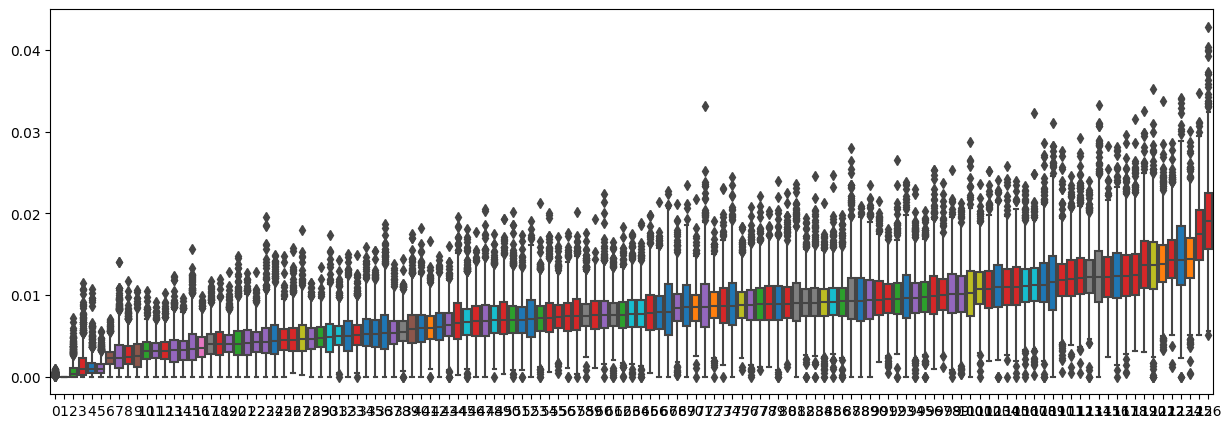

In [152]:

plt.figure(figsize=(15,5))
ax = sns.boxplot( list(normalized_read_counts[normalized_read_counts.median().sort_values().index].T.to_numpy()))
for i,box in enumerate(ax.patches):
    color = palette[chrom_amplicon[i]]
    box.set_facecolor(color)

### Cell search for outliers

In [77]:
read_counts.sum(axis=1).sort_values()

b'TATCAGTGCGAGGTCACG-1'     1180
b'CTCTGCAAGGTCTCCAGG-1'     1372
b'TAGTCAGACGGAATTGGA-1'     1398
b'CTCTGCAAGCCGATCTCT-1'     1404
b'GAGTATCGCGCAACTCGC-1'     1417
                           ...  
b'CCAACGGAATCAGAGCGT-1'     9592
b'CAGCAGTACTGATCTCGG-1'     9759
b'GAGTCACCAGGATTACGC-1'     9896
b'ACCTGTACCCCTATTGGT-1'    10642
b'CGTGCAAGGGACGTCAAT-1'    10967
Length: 1240, dtype: int64

<Axes: >

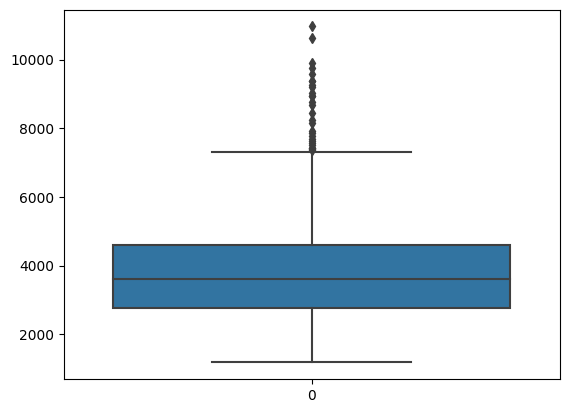

In [23]:
sns.boxplot(read_counts.sum(axis=1))

In [41]:
read_counts.loc[[read_counts.sum(axis=1).sort_values().index[0]]].values # cell with the smallest coverage 

array([[ 9, 11, 14, 11, 10, 19, 11, 10,  5,  6,  7,  6,  3,  5,  4, 12,
         6,  7,  6,  6,  8,  9,  4,  4,  0,  8,  6,  7,  6,  8,  3, 10,
         8,  7,  4,  7, 16, 13,  3, 11,  2, 12, 17, 22, 16,  5,  5,  9,
        11,  8,  2, 10,  8,  5,  6,  9, 15, 15, 11, 11, 16, 13,  0, 20,
        14, 13, 14, 16,  9, 23,  7,  9, 12, 11, 12, 20, 15,  4, 11, 11,
        19, 19, 14,  9, 18, 11, 13,  6, 10, 10, 13,  9,  5,  9,  0, 14,
         3,  1,  1,  7, 16,  7, 17,  3,  1,  3,  2,  8,  3,  6,  8,  0,
         4, 20, 11,  8, 16,  7,  9,  6,  6, 11,  8,  5, 17, 16, 12]],
      dtype=int64)

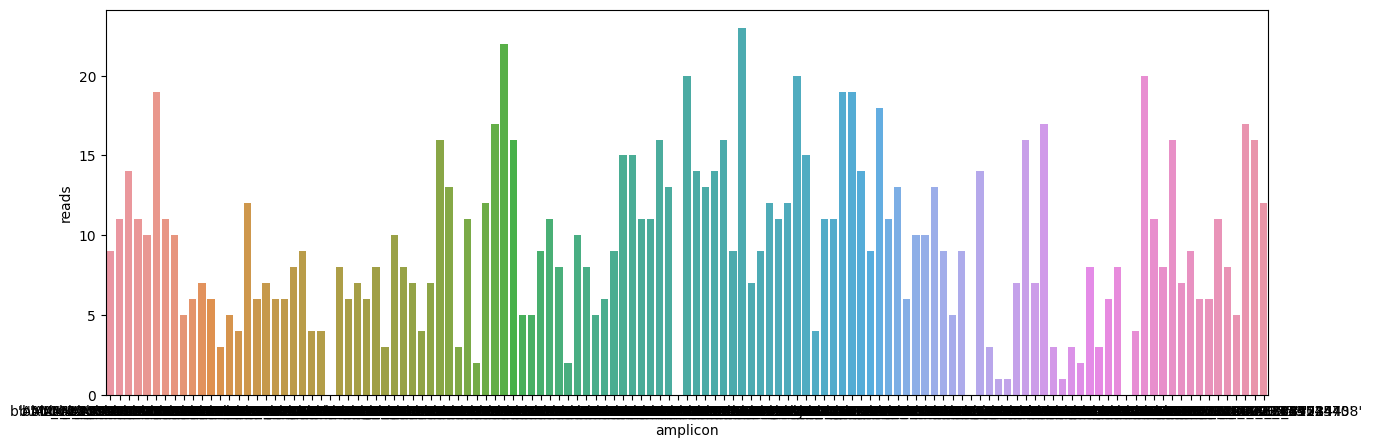

In [58]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data = read_counts.loc[[read_counts.sum(axis=1).sort_values().index[0]]].T.reset_index().rename(columns={"index": "amplicon", b'TATCAGTGCGAGGTCACG-1': "reads"}), x="amplicon",y="reads" )

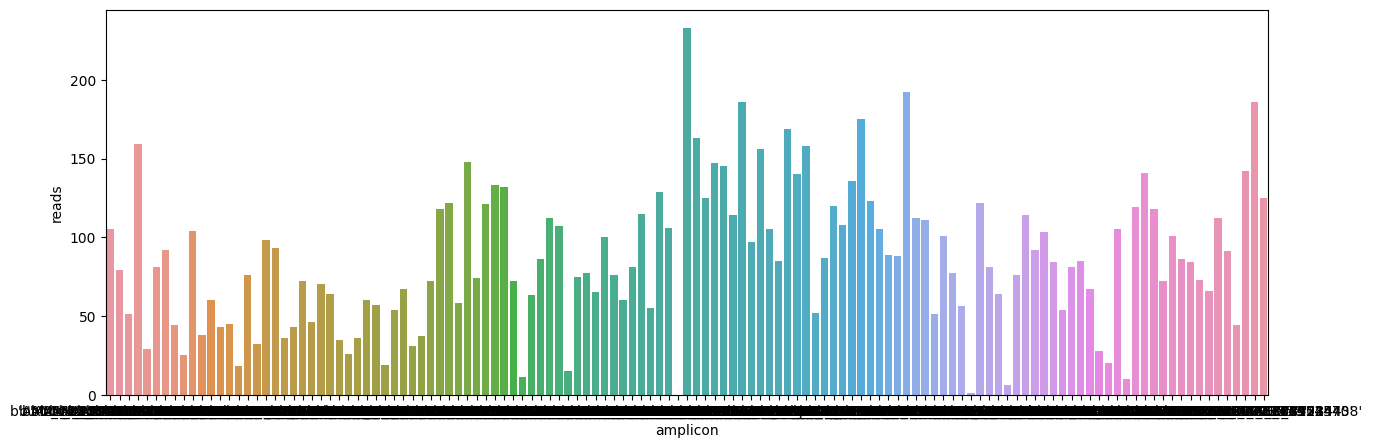

In [62]:
# cell with the highest coverage
plt.figure(figsize=(15,5))
ax = sns.barplot(data = read_counts.loc[[read_counts.sum(axis=1).sort_values().index[-1]]].T.reset_index().rename(columns={"index": "amplicon", b'CGTGCAAGGGACGTCAAT-1': "reads"}), x="amplicon",y="reads" )

# VAF computation

In [240]:
vafs

b'chr1:115256513:G/A'  b'chr1:115256513:G/T'   
b'AACAACCTACAGAAGTGA-1'               0.111111               0.000000  \
b'AACAACCTATCTATGACA-1'               0.222222               0.000000   
b'AACAACTGGCAACGCACA-1'               0.023256               0.023256   
b'AACACACTCTTACAGTGT-1'               0.019608               0.019608   
b'AACAGCAGTCGTCTGCTG-1'               0.000000               0.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000               0.000000   
b'TTGGAGAACTGAACTTGC-1'               0.000000               0.000000   
b'TTGGTAACTTCTGCGCTG-1'               0.021739               0.021739   
b'TTGTCAACCGCAGCAGTG-1'               0.000000               0.000000   
b'TTGTTAGAGAATCTCCTA-1'               0.183673               0.000000   

                         b'chr1:115256514:G/A'  b'chr1:115256515:C/'   
b'AACAACCTACAGAAGTGA-1'               0.000000                   0.0  \
b'AACAACCTATCTATGACA-1'               0.000000                   0.0   
b'AACAACTGGCAACGCACA-1'               0.000000                   0.0   
b'AACACACTCTTACAGTGT-1'               0.000000                   0.0   
b'AACAGCAGTCGTCTGCTG-1'               0.000000                   0.0   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000                   0.0   
b'TTGGAGAACTGAACTTGC-1'               0.000000                   0.0   
b'TTGGTAACTTCTGCGCTG-1'               0.000000                   0.0   
b'TTGTCAACCGCAGCAGTG-1'               0.000000                   0.0   
b'TTGTTAGAGAATCTCCTA-1'               0.040816                   0.0   

                         b'chr1:115256516:A/G'  b'chr1:115256516:A/T'   
b'AACAACCTACAGAAGTGA-1'               0.000000               0.000000  \
b'AACAACCTATCTATGACA-1'               0.090909               0.090909   
b'AACAACTGGCAACGCACA-1'               0.023256               0.023256   
b'AACACACTCTTACAGTGT-1'               0.000000               0.000000   
b'AACAGCAGTCGTCTGCTG-1'               0.032258               0.032258   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000               0.000000   
b'TTGGAGAACTGAACTTGC-1'               0.000000               0.000000   
b'TTGGTAACTTCTGCGCTG-1'               0.000000               0.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.000000               0.000000   
b'TTGTTAGAGAATCTCCTA-1'               0.000000               0.000000   

                         b'chr1:115256517:C/'  b'chr1:115256518:T/C'   
b'AACAACCTACAGAAGTGA-1'                   0.0               0.000000  \
b'AACAACCTATCTATGACA-1'                   0.0               0.000000   
b'AACAACTGGCAACGCACA-1'                   0.0               0.000000   
b'AACACACTCTTACAGTGT-1'                   0.0               0.019608   
b'AACAGCAGTCGTCTGCTG-1'                   0.0               0.000000   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                   0.0               0.111111   
b'TTGGAGAACTGAACTTGC-1'                   0.0               0.019608   
b'TTGGTAACTTCTGCGCTG-1'                   0.0               0.000000   
b'TTGTCAACCGCAGCAGTG-1'                   0.0               0.000000   
b'TTGTTAGAGAATCTCCTA-1'                   0.0               0.000000   

                         b'chr1:115256518:T/G'  b'chr1:115256519:G/'  ...   
b'AACAACCTACAGAAGTGA-1'               0.000000                   0.0  ...  \
b'AACAACCTATCTATGACA-1'               0.000000                   0.0  ...   
b'AACAACTGGCAACGCACA-1'               0.000000                   0.0  ...   
b'AACACACTCTTACAGTGT-1'               0.019608                   0.0  ...   
b'AACAGCAGTCGTCTGCTG-1'               0.000000                   0.0  ...   
...                                        ...                   ...  ...   
b'

In [283]:
cov_pos = covs.T.copy()
cov_pos['POS'] = variants.POS.values
cov_pos = cov_pos.reset_index().groupby('POS').sum().drop("index",axis=1)

In [297]:
vafs_by_hand = covs.copy()

for col in vafs_by_hand.columns: # col = variant
    position = variants.POS[variants.id == col].values[0]
    vafs_by_hand[col] = vafs_by_hand[col] /cov_pos.loc[[position]].values[0]

# cov_pos replace values by read count of associated amplicon for each variant

In [298]:
vafs_by_hand

b'chr1:115256513:G/A'  b'chr1:115256513:G/T'   
b'AACAACCTACAGAAGTGA-1'                    0.5                    0.5  \
b'AACAACCTATCTATGACA-1'                    0.5                    0.5   
b'AACAACTGGCAACGCACA-1'                    0.5                    0.5   
b'AACACACTCTTACAGTGT-1'                    0.5                    0.5   
b'AACAGCAGTCGTCTGCTG-1'                    0.5                    0.5   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                    0.5                    0.5   
b'TTGGAGAACTGAACTTGC-1'                    0.5                    0.5   
b'TTGGTAACTTCTGCGCTG-1'                    0.5                    0.5   
b'TTGTCAACCGCAGCAGTG-1'                    0.5                    0.5   
b'TTGTTAGAGAATCTCCTA-1'                    0.5                    0.5   

                         b'chr1:115256514:G/A'  b'chr1:115256515:C/'   
b'AACAACCTACAGAAGTGA-1'                    1.0                   1.0  \
b'AACAACCTATCTATGACA-1'                    1.0                   1.0   
b'AACAACTGGCAACGCACA-1'                    1.0                   1.0   
b'AACACACTCTTACAGTGT-1'                    1.0                   1.0   
b'AACAGCAGTCGTCTGCTG-1'                    1.0                   1.0   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'                    1.0                   1.0   
b'TTGGAGAACTGAACTTGC-1'                    1.0                   1.0   
b'TTGGTAACTTCTGCGCTG-1'                    1.0                   1.0   
b'TTGTCAACCGCAGCAGTG-1'                    1.0                   1.0   
b'TTGTTAGAGAATCTCCTA-1'                    1.0                   1.0   

                         b'chr1:115256516:A/G'  b'chr1:115256516:A/T'   
b'AACAACCTACAGAAGTGA-1'                    0.5                    0.5  \
b'AACAACCTATCTATGACA-1'                    0.5                    0.5   
b'AACAACTGGCAACGCACA-1'                    0.5                    0.5   
b'AACACACTCTTACAGTGT-1'                    0.5                    0.5   
b'AACAGCAGTCGTCTGCTG-1'                    0.5                    0.5   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                    0.5                    0.5   
b'TTGGAGAACTGAACTTGC-1'                    0.5                    0.5   
b'TTGGTAACTTCTGCGCTG-1'                    0.5                    0.5   
b'TTGTCAACCGCAGCAGTG-1'                    0.5                    0.5   
b'TTGTTAGAGAATCTCCTA-1'                    0.5                    0.5   

                         b'chr1:115256517:C/'  b'chr1:115256518:T/C'   
b'AACAACCTACAGAAGTGA-1'                   1.0                    0.5  \
b'AACAACCTATCTATGACA-1'                   1.0                    0.5   
b'AACAACTGGCAACGCACA-1'                   1.0                    0.5   
b'AACACACTCTTACAGTGT-1'                   1.0                    0.5   
b'AACAGCAGTCGTCTGCTG-1'                   1.0                    0.5   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                   1.0                    0.5   
b'TTGGAGAACTGAACTTGC-1'                   1.0                    0.5   
b'TTGGTAACTTCTGCGCTG-1'                   1.0                    0.5   
b'TTGTCAACCGCAGCAGTG-1'                   1.0                    0.5   
b'TTGTTAGAGAATCTCCTA-1'                   1.0                    0.5   

                         b'chr1:115256518:T/G'  b'chr1:115256519:G/'  ...   
b'AACAACCTACAGAAGTGA-1'                    0.5                   1.0  ...  \
b'AACAACCTATCTATGACA-1'                    0.5                   1.0  ...   
b'AACAACTGGCAACGCACA-1'                    0.5                   1.0  ...   
b'AACACACTCTTACAGTGT-1'                    0.5                   1.0  ...   
b'AACAGCAGTCGTCTGCTG-1'                    0.5                   1.0  ...   
...                                        ...                   ...  ...   
b'

In [300]:
unique, counts = np.unique(vafs_by_hand.round(decimals=1).to_numpy(), return_counts=True) # greater than 1 values 

In [301]:
unique,counts

(array([0.3, 0.5, 1. , nan]),
 array([   28980,  6862310, 25525388,   951722], dtype=int64))

perfect mappability

In [4]:
snv_read_count = vafs.copy()

for col in snv_read_count.columns:
    amplicon = variants.amplicon[variants.id == col].values[0]
    snv_read_count[col] = read_counts[amplicon]

# snv_read_count replace vafs by read count of associated amplicon for each variant

In [5]:
vaf_perf_map = covs/snv_read_count

In [6]:
vaf_perf_map

b'chr1:115256513:G/A'  b'chr1:115256513:G/T'   
b'AACAACCTACAGAAGTGA-1'               0.972973               0.972973  \
b'AACAACCTATCTATGACA-1'               0.818182               0.818182   
b'AACAACTGGCAACGCACA-1'               0.977273               0.977273   
b'AACACACTCTTACAGTGT-1'               0.864407               0.864407   
b'AACAGCAGTCGTCTGCTG-1'               1.000000               1.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               1.000000               1.000000   
b'TTGGAGAACTGAACTTGC-1'               0.467890               0.467890   
b'TTGGTAACTTCTGCGCTG-1'               1.000000               1.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.724638               0.724638   
b'TTGTTAGAGAATCTCCTA-1'               0.753846               0.753846   

                         b'chr1:115256514:G/A'  b'chr1:115256515:C/'   
b'AACAACCTACAGAAGTGA-1'               0.972973              0.972973  \
b'AACAACCTATCTATGACA-1'               1.000000              1.000000   
b'AACAACTGGCAACGCACA-1'               0.977273              0.977273   
b'AACACACTCTTACAGTGT-1'               0.864407              0.864407   
b'AACAGCAGTCGTCTGCTG-1'               1.000000              1.000000   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'               1.000000              1.000000   
b'TTGGAGAACTGAACTTGC-1'               0.467890              0.467890   
b'TTGGTAACTTCTGCGCTG-1'               1.000000              1.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.724638              0.724638   
b'TTGTTAGAGAATCTCCTA-1'               0.753846              0.784615   

                         b'chr1:115256516:A/G'  b'chr1:115256516:A/T'   
b'AACAACCTACAGAAGTGA-1'               0.972973               0.972973  \
b'AACAACCTATCTATGACA-1'               1.000000               1.000000   
b'AACAACTGGCAACGCACA-1'               0.977273               0.977273   
b'AACACACTCTTACAGTGT-1'               0.864407               0.864407   
b'AACAGCAGTCGTCTGCTG-1'               1.000000               1.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               1.000000               1.000000   
b'TTGGAGAACTGAACTTGC-1'               0.467890               0.467890   
b'TTGGTAACTTCTGCGCTG-1'               1.000000               1.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.724638               0.724638   
b'TTGTTAGAGAATCTCCTA-1'               0.784615               0.784615   

                         b'chr1:115256517:C/'  b'chr1:115256518:T/C'   
b'AACAACCTACAGAAGTGA-1'              0.972973               0.972973  \
b'AACAACCTATCTATGACA-1'              1.000000               1.000000   
b'AACAACTGGCAACGCACA-1'              0.977273               0.977273   
b'AACACACTCTTACAGTGT-1'              0.864407               0.864407   
b'AACAGCAGTCGTCTGCTG-1'              1.000000               1.000000   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'              1.000000               1.000000   
b'TTGGAGAACTGAACTTGC-1'              0.467890               0.467890   
b'TTGGTAACTTCTGCGCTG-1'              1.000000               1.000000   
b'TTGTCAACCGCAGCAGTG-1'              0.724638               0.724638   
b'TTGTTAGAGAATCTCCTA-1'              0.784615               0.784615   

                         b'chr1:115256518:T/G'  b'chr1:115256519:G/'  ...   
b'AACAACCTACAGAAGTGA-1'               0.972973              0.972973  ...  \
b'AACAACCTATCTATGACA-1'               1.000000              1.000000  ...   
b'AACAACTGGCAACGCACA-1'               0.977273              0.977273  ...   
b'AACACACTCTTACAGTGT-1'               0.864407              0.864407  ...   
b'AACAGCAGTCGTCTGCTG-1'               1.000000              1.000000  ...   
...                                        ...                   ...  ...   
b'

# VAF distribution

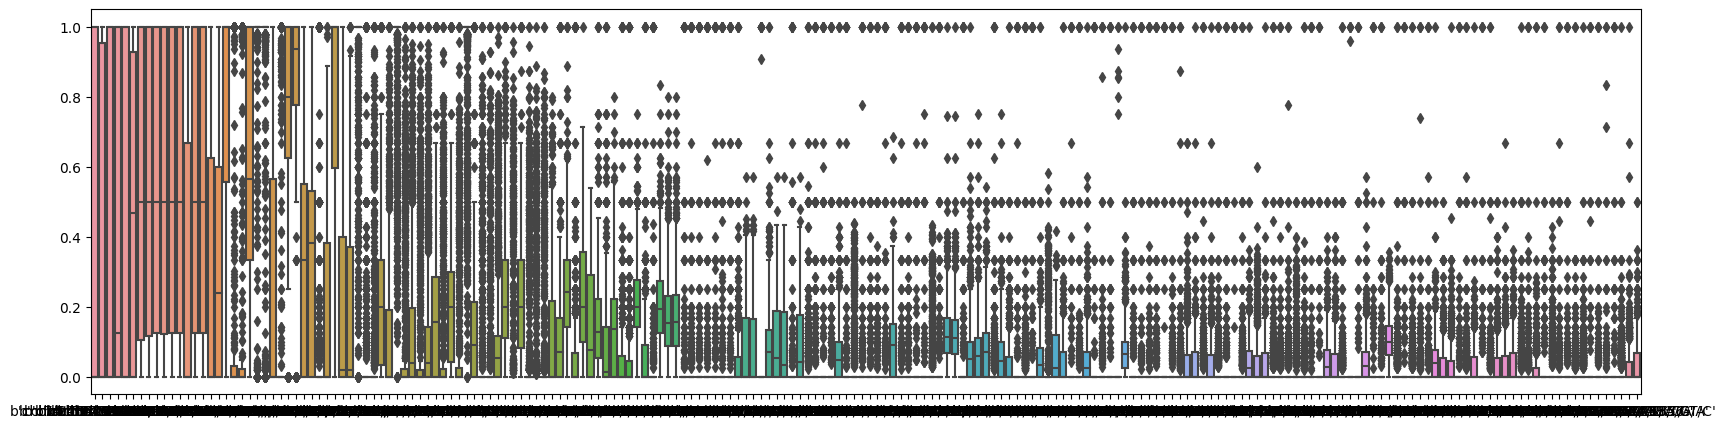

In [13]:
plt.figure(figsize=(20,5))
ax = sns.boxplot( vafs[vafs.std().sort_values(ascending=False).iloc[:200].index])

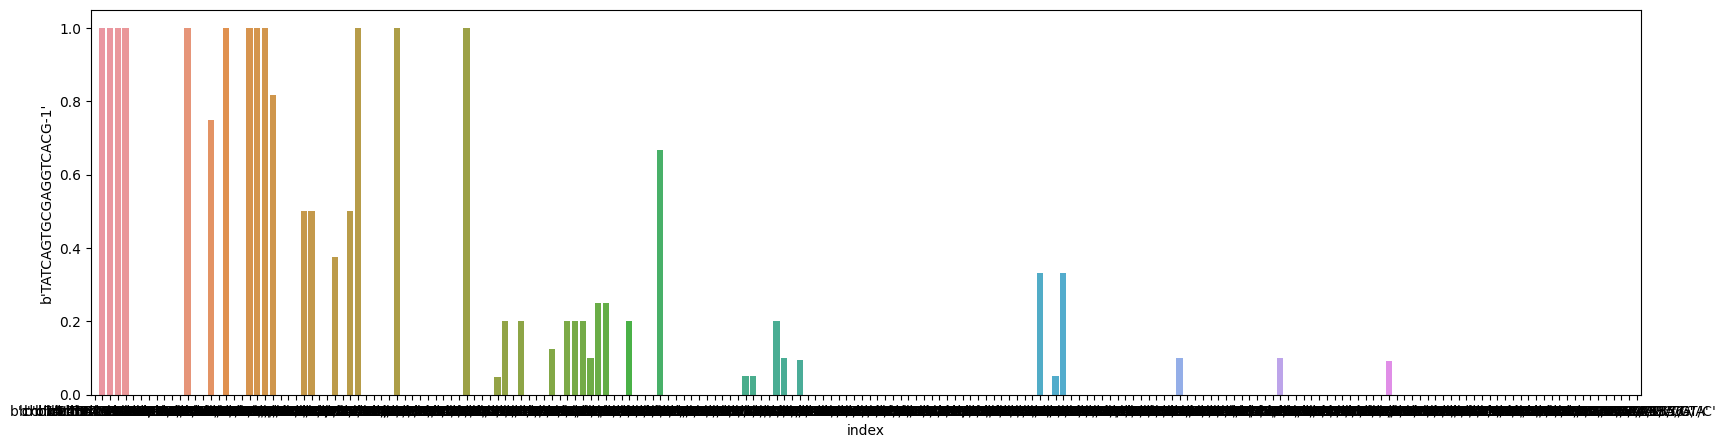

In [19]:
cell = b'TATCAGTGCGAGGTCACG-1'
plt.figure(figsize=(20,5))
ax = sns.barplot(data = vafs[vafs.std().sort_values(ascending=False).iloc[:200].index].loc[[cell]].T.reset_index(), x="index",y=cell )

# Understanding filtering

In [29]:
cell_filters

barcode  filtered              sample_name
0     b'AACAACCTACAGAAGTGA-1'         0  b'4-cell-lines-AML-CNV'
1     b'AACAACCTATCTATGACA-1'         0  b'4-cell-lines-AML-CNV'
2     b'AACAACTGGCAACGCACA-1'         0  b'4-cell-lines-AML-CNV'
3     b'AACACACTCTTACAGTGT-1'         0  b'4-cell-lines-AML-CNV'
4     b'AACAGCAGTCGTCTGCTG-1'         0  b'4-cell-lines-AML-CNV'
...                       ...       ...                      ...
1235  b'TTGGACTTCCGCTTATGA-1'         0  b'4-cell-lines-AML-CNV'
1236  b'TTGGAGAACTGAACTTGC-1'         0  b'4-cell-lines-AML-CNV'
1237  b'TTGGTAACTTCTGCGCTG-1'         0  b'4-cell-lines-AML-CNV'
1238  b'TTGTCAACCGCAGCAGTG-1'         0  b'4-cell-lines-AML-CNV'
1239  b'TTGTTAGAGAATCTCCTA-1'         0  b'4-cell-lines-AML-CNV'

[1240 rows x 3 columns]

### Cell filtering

In [26]:
cell_filters.filtered.value_counts()

filtered
0    1201
1      39
Name: count, dtype: int64

<Axes: ylabel='Count'>

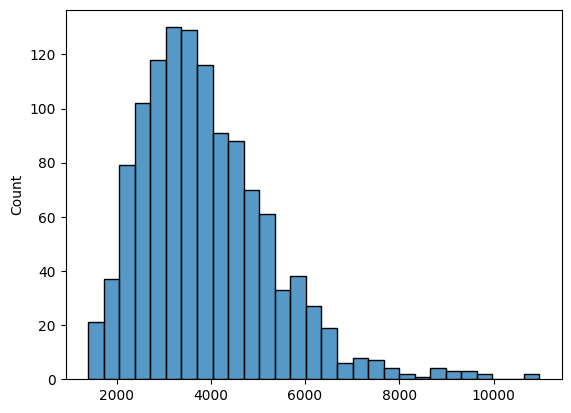

In [43]:
sns.histplot(read_counts.loc[cell_filters[cell_filters.filtered == 0].barcode.values].sum(axis=1))

<Axes: ylabel='Count'>

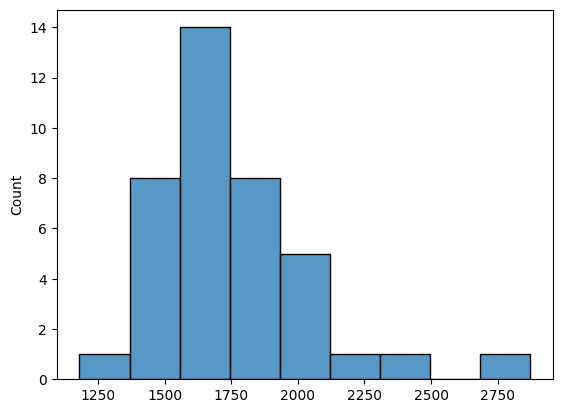

In [44]:
sns.histplot(read_counts.loc[cell_filters[cell_filters.filtered == 1].barcode.values].sum(axis=1))

<Axes: >

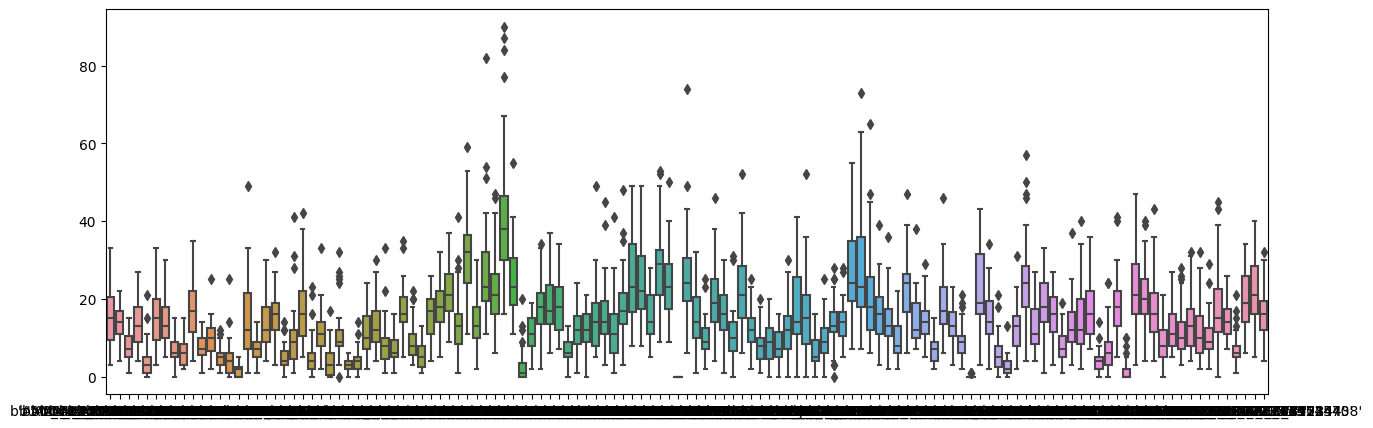

In [46]:
plt.figure(figsize=(15,5))
sns.boxplot(data = read_counts.loc[cell_filters[cell_filters.filtered == 1].barcode.values])

<Axes: >

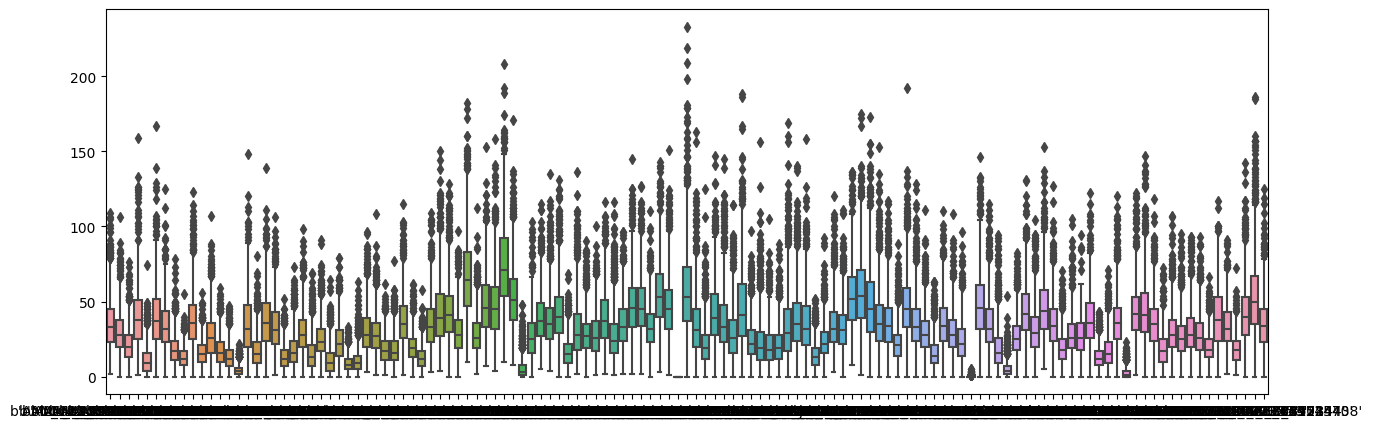

In [47]:
plt.figure(figsize=(15,5))
sns.boxplot(data = read_counts.loc[cell_filters[cell_filters.filtered == 0].barcode.values]) 

The read count is way smaller for cells with 1 value filter

### Variants filtering

In [48]:
variants.filtered.value_counts()

filtered
1    26866
0       44
Name: count, dtype: int64

<Axes: >

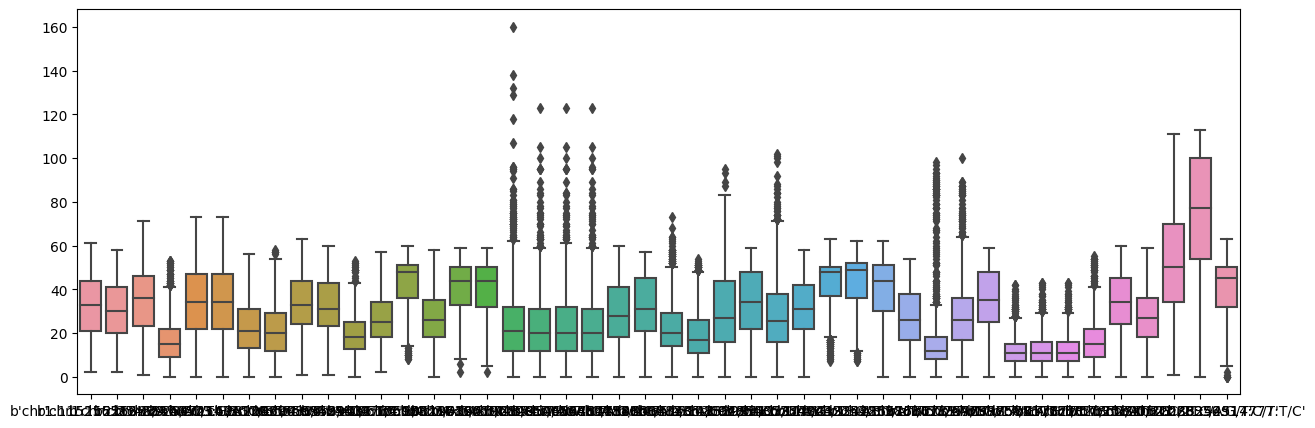

In [56]:
plt.figure(figsize=(15,5))
sns.boxplot(data = covs[variants[variants.filtered == 0].id.values]) 

<Axes: >

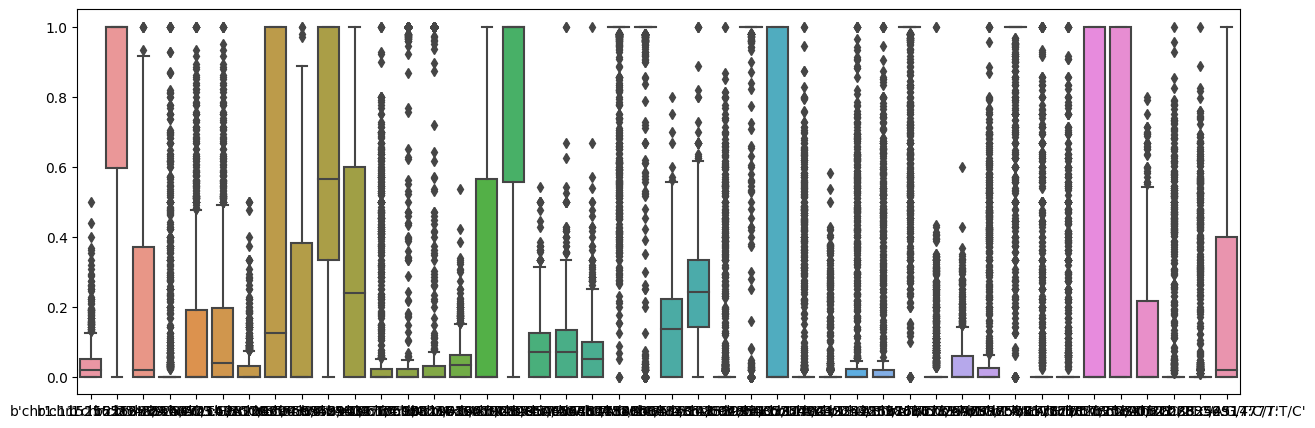

In [57]:
plt.figure(figsize=(15,5))
sns.boxplot(data = vafs[variants[variants.filtered == 0].id.values]) 

<Axes: ylabel='Count'>

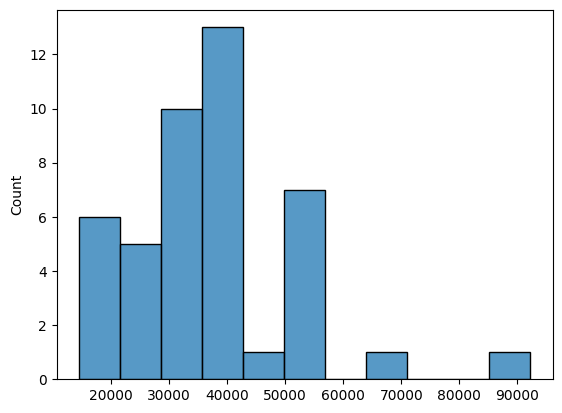

In [66]:
sns.histplot(covs[variants[variants.filtered == 0].id.values].sum())

<Axes: ylabel='Count'>

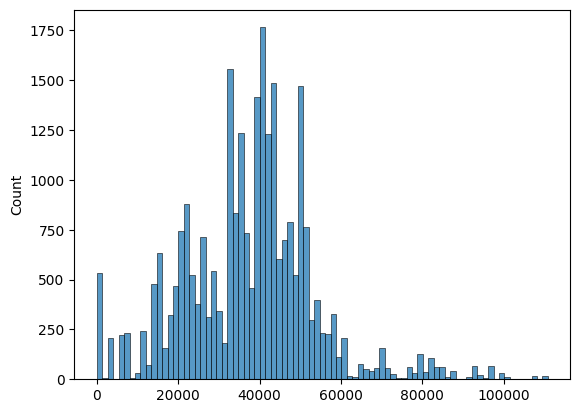

In [67]:
sns.histplot(covs[variants[variants.filtered == 1].id.values].sum())

<Axes: ylabel='Count'>

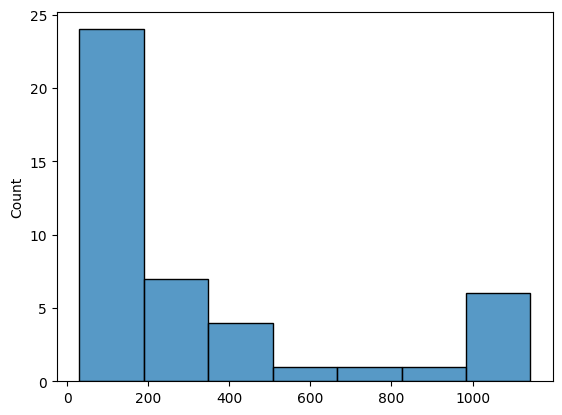

In [70]:
sns.histplot(vafs[variants[variants.filtered == 0].id.values].sum()) # basically the number of variants and number of cells with the variant 

[(0.0, 1500.0)]

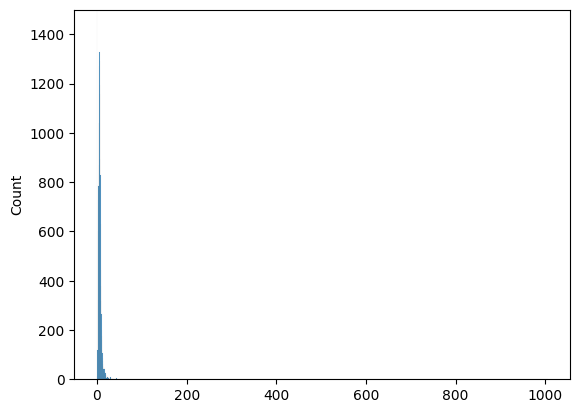

In [74]:
sns.histplot(vafs[variants[variants.filtered == 1].id.values].sum()).set(ylim=(0,1500)) # basically the number of variants and number of cells with the variant 

[(0.0, 1500.0), (0.0, 100.0)]

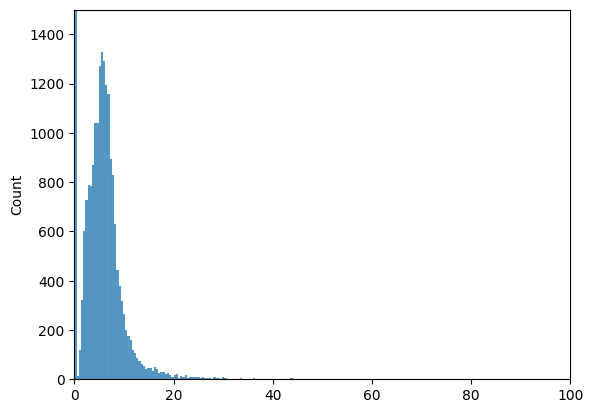

In [75]:
sns.histplot(vafs[variants[variants.filtered == 1].id.values].sum()).set(ylim=(0,1500),xlim=(0,100))

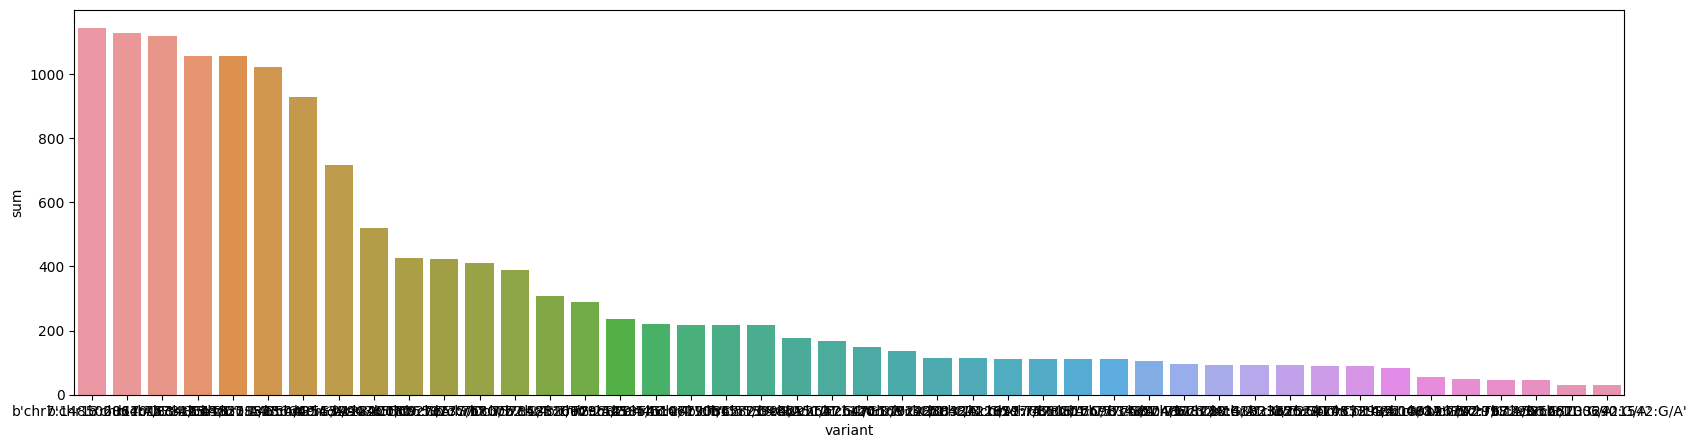

In [13]:
data = vafs[variants[variants.filtered == 0].id.values].sum().to_frame().reset_index().rename(columns = {"index":"variant",0:"sum"}).sort_values(by="sum",ascending=False).iloc[:100]
plt.figure(figsize=(20,5))
ax = sns.barplot(data = data, x="variant",y="sum")

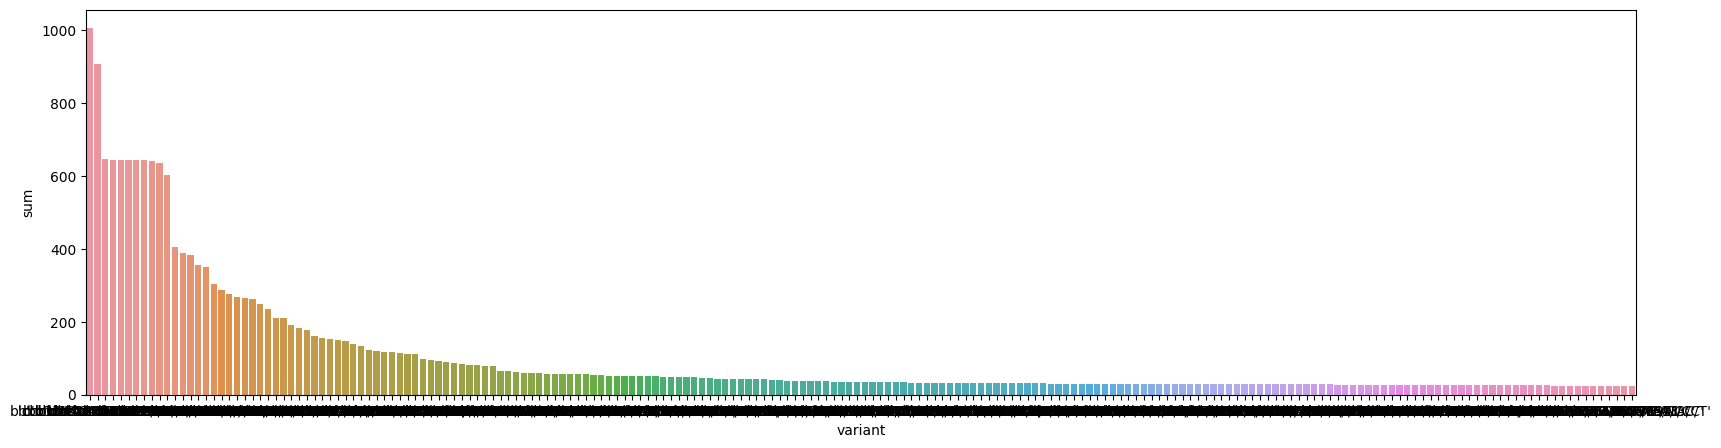

In [15]:
data = vafs[variants[variants.filtered == 1].id.values].sum().to_frame().reset_index().rename(columns = {"index":"variant",0:"sum"}).sort_values(by="sum",ascending=False).iloc[:200]
plt.figure(figsize=(20,5))
ax = sns.barplot(data = data, x="variant",y="sum")

Seems that variants with 1 as filter value are present in less cell

### Values filtering

In [99]:
print("number of 1 :",filtermask.sum().sum())
print("number of 0:", filtermask.size - filtermask.sum().sum())

number of 1 : 87765
number of 0: 33280635


According to previous filtering analysis we should keep cells with 0 and variants with 0 so 1201 cells and 44 variants so 52844 values

In [26]:
print("cells 0 and variants 0 filter:",filtermask.loc[cell_filters[cell_filters.filtered == 0].barcode.values][variants[variants.filtered == 0].id.values].sum().sum())
print("cells 0 and variants 1 filter:",filtermask.loc[cell_filters[cell_filters.filtered == 0].barcode.values][variants[variants.filtered == 1].id.values].sum().sum())
print("cells 1 and variants 0 filter:",filtermask.loc[cell_filters[cell_filters.filtered == 1].barcode.values][variants[variants.filtered == 0].id.values].sum().sum())
print("cells 1 and variants 1 filter:",filtermask.loc[cell_filters[cell_filters.filtered == 1].barcode.values][variants[variants.filtered == 1].id.values].sum().sum())


cells 0 and varianst 0 filter: 9984
cells 0 and varianst 1 filter: 72874
cells 1 and varianst 0 filter: 807
cells 1 and varianst 1 filter: 4100


Genotype filtering can explain the difference

Mission Bio advanced filtering

- Remove genotype in cell with quality < X
- Remove genotype in cell with read depth < X
- Remove genotype in cell with alternate allele freq < X
- Remove variants genotyped in < X% of cell (low-quality variants filter)
- Remove cells with < X% of genotypes present (low-quality cells filter)
- Remove variants mutated in < X% of cells (low-frequency variants filter)

Before filtering

<Axes: xlabel='POS', ylabel="b'AACAACCTACAGAAGTGA-1'">

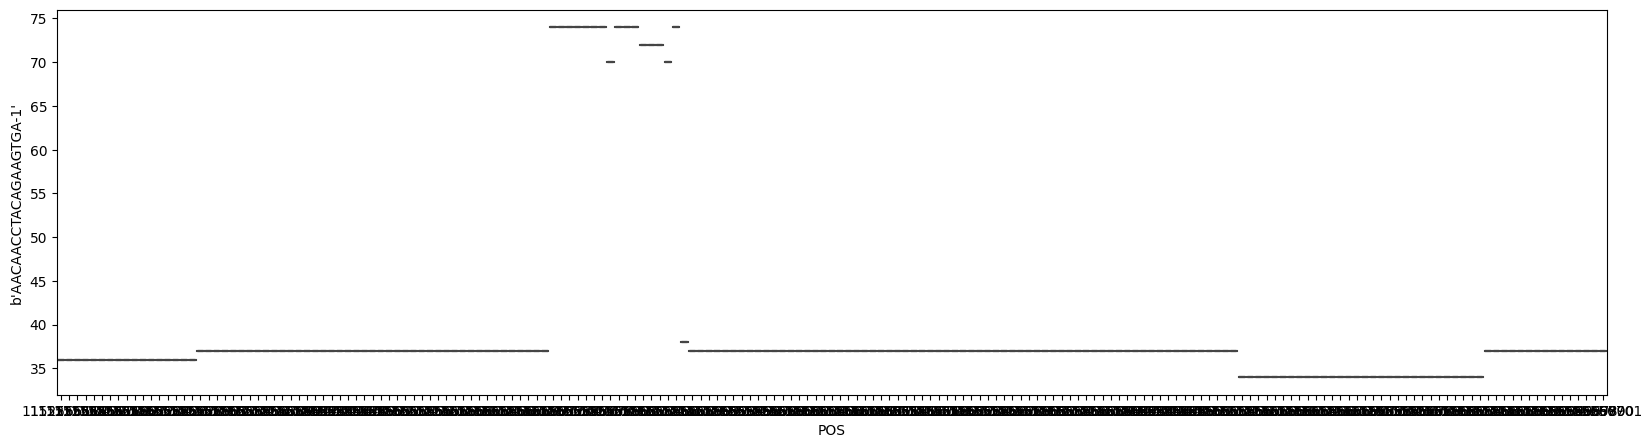

In [14]:
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv['POS'] = variants.POS.values
rd_var_same_pos = sanity_snv.copy()
#rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.duplicated(keep=False)]
amplicon_check = b'AML_v2_NRAS_115256512'
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.amplicon == amplicon_check].drop(['sum','amplicon'],axis=1)
rd_var_same_pos['POS'] = rd_var_same_pos['POS'].apply(str)

cell = b'AACAACCTACAGAAGTGA-1'# b'AACAACCTATCTATGACA-1'# b'AACAACCTACAGAAGTGA-1' 
plt.figure(figsize=(20,5))
sns.boxplot(data = rd_var_same_pos[[cell,'POS']].sort_values('POS'), x='POS', y=cell)

<Axes: xlabel='amplicon', ylabel="b'AACAACCTACAGAAGTGA-1'">

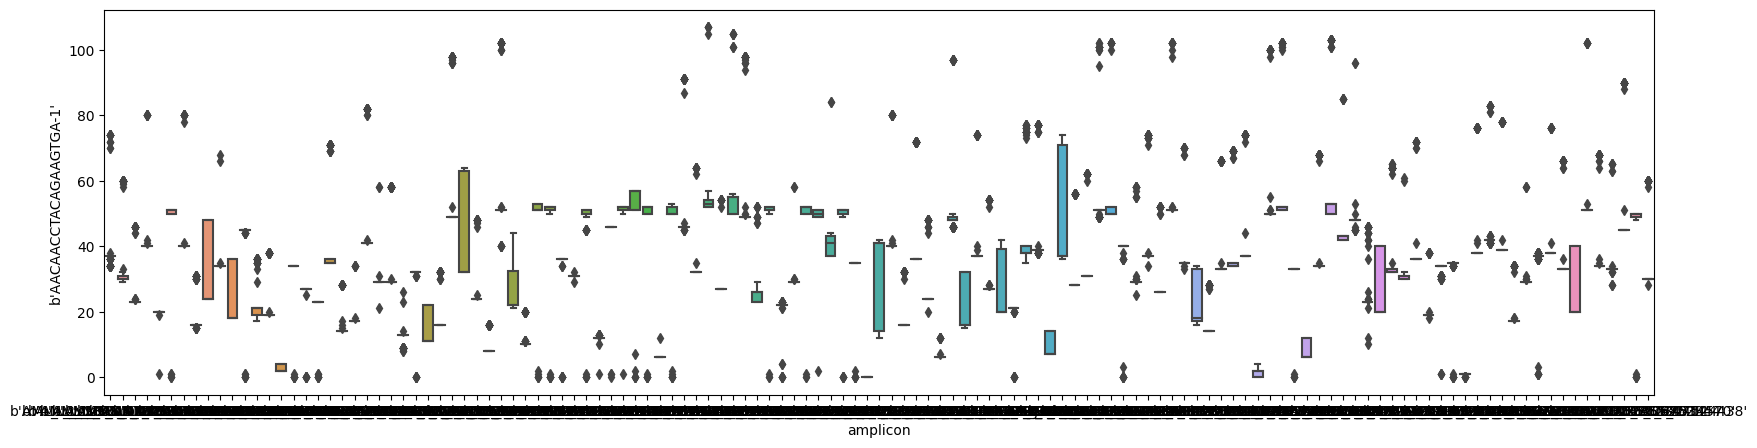

In [48]:
cell = b'AACAACCTACAGAAGTGA-1'
data = sanity_snv.drop_duplicates()[[cell,'amplicon']]  #.groupby('amplicon').min() #- sanity_snv.drop_duplicates().groupby('amplicon').min()
plt.figure(figsize=(20,5))
sns.boxplot(data = data, x="amplicon", y = cell	) # no normalization

<Axes: xlabel='amplicon'>

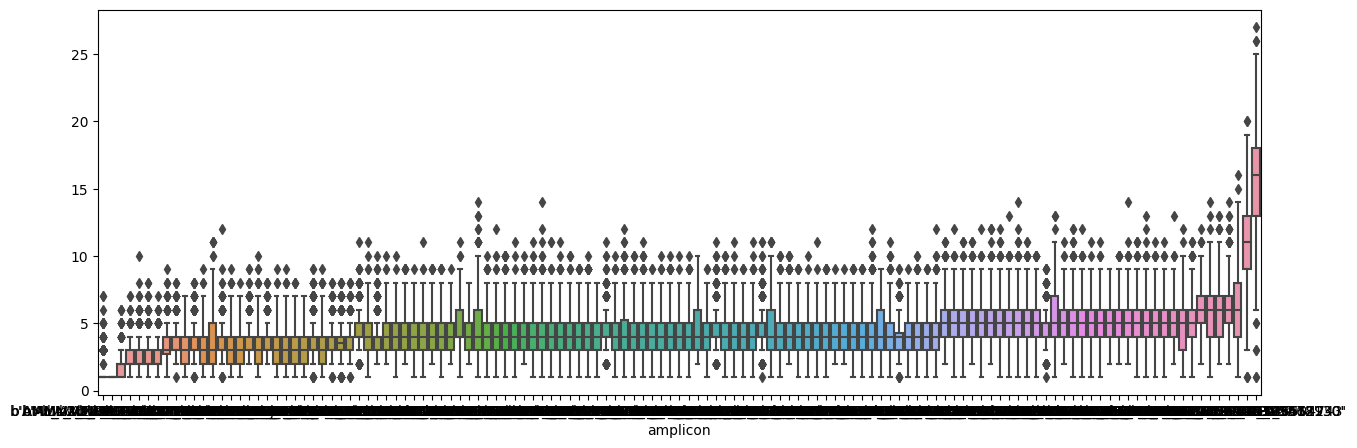

In [15]:
diff_rc_amplicon = sanity_snv.groupby('amplicon').nunique().drop(['sum','POS'], axis=1).T
plt.figure(figsize=(15,5))
sns.boxplot(data = diff_rc_amplicon[diff_rc_amplicon.median().sort_values().index]) 

After filtering

In [16]:
filtermask_rev = filtermask.copy()
filtermask_rev[filtermask_rev ==0] =2 
filtermask_rev[filtermask_rev == 1] = 0
filtermask_rev = filtermask_rev/2

In [17]:
sanity_snv = covs.T.copy()*filtermask_rev.T
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv['POS'] = variants.POS.values

<Axes: xlabel='POS', ylabel="b'AACAACCTACAGAAGTGA-1'">

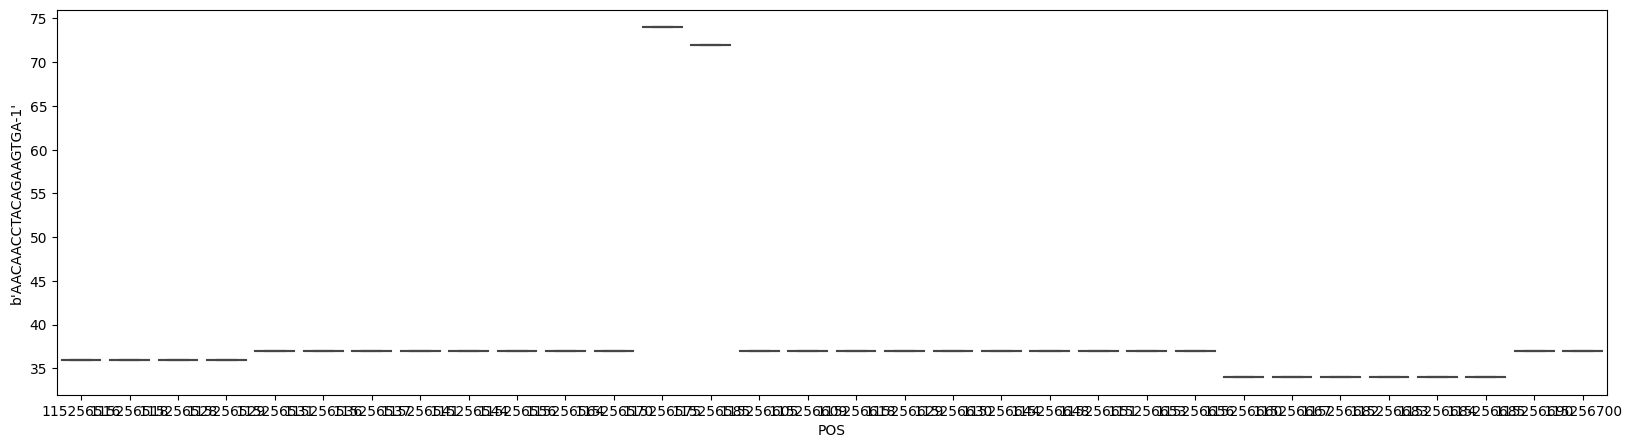

In [50]:
rd_var_same_pos = sanity_snv.copy()
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.duplicated(keep=False)]
amplicon_check = b'AML_v2_NRAS_115256512'
rd_var_same_pos = rd_var_same_pos[rd_var_same_pos.amplicon == amplicon_check].drop(['sum','amplicon'],axis=1)
rd_var_same_pos['POS'] = rd_var_same_pos['POS'].apply(str)

cell = b'AACAACCTACAGAAGTGA-1'# b'AACAACCTATCTATGACA-1'# b'AACAACCTACAGAAGTGA-1' 
plt.figure(figsize=(20,5))
sns.boxplot(data = rd_var_same_pos[[cell,'POS']].sort_values('POS'), x='POS', y=cell)

<Axes: xlabel='amplicon', ylabel="b'AACAACCTACAGAAGTGA-1'">

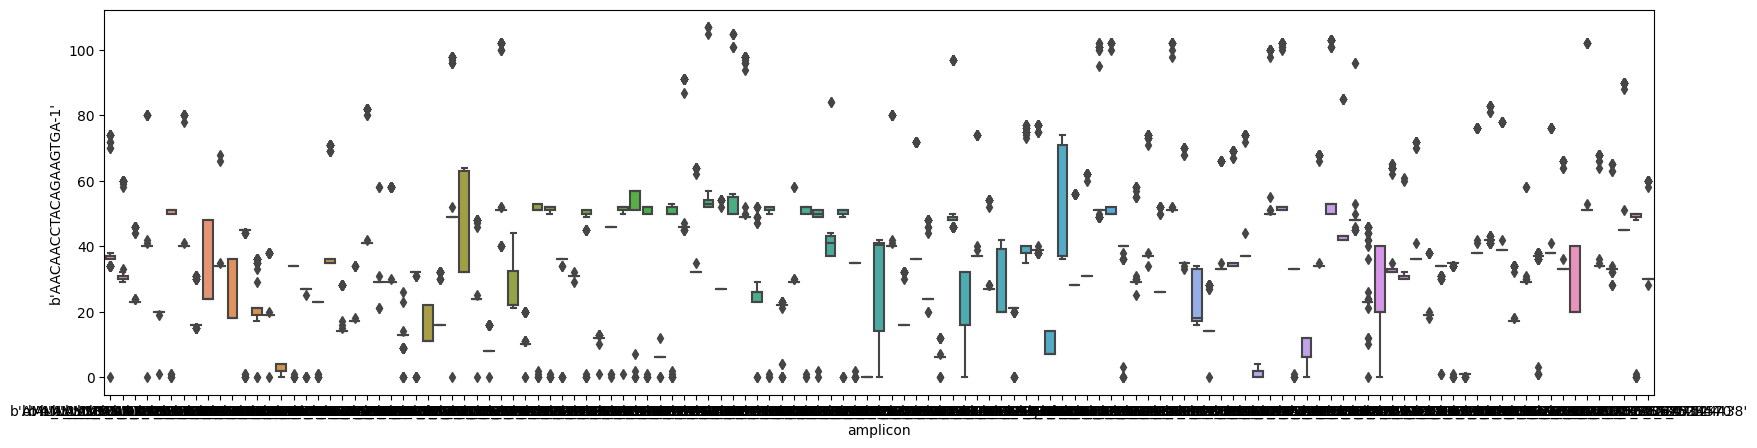

In [51]:
cell = b'AACAACCTACAGAAGTGA-1'
data = sanity_snv.drop_duplicates()[[cell,'amplicon']]  #.groupby('amplicon').min() #- sanity_snv.drop_duplicates().groupby('amplicon').min()
plt.figure(figsize=(20,5))
sns.boxplot(data = data, x="amplicon", y = cell	) # no normalization

In [57]:
cell_filters[cell_filters.barcode == b'AACAACCTACAGAAGTGA-1']

barcode  filtered              sample_name
0  b'AACAACCTACAGAAGTGA-1'         0  b'4-cell-lines-AML-CNV'

<Axes: xlabel='amplicon'>

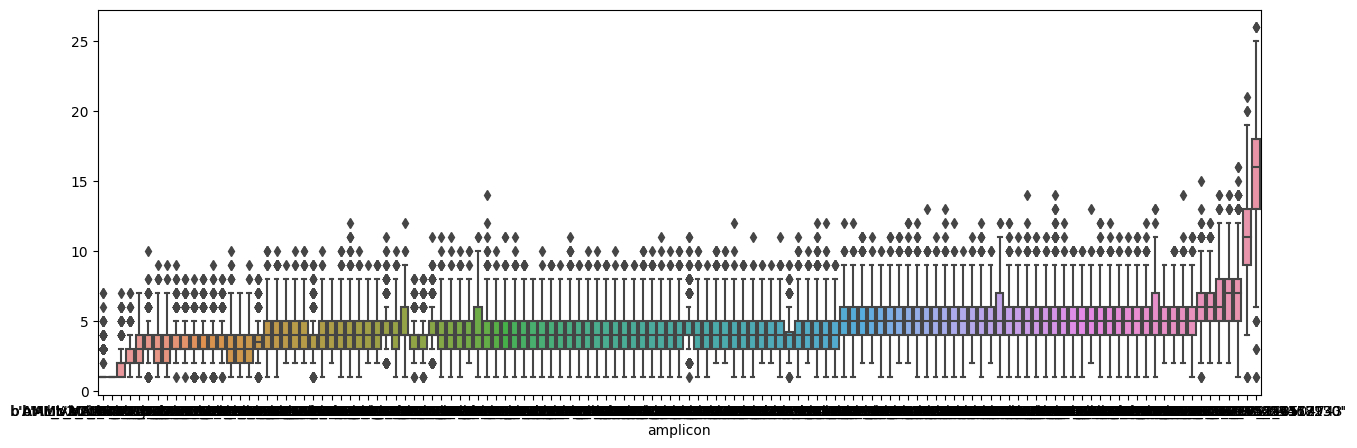

In [18]:
diff_rc_amplicon = sanity_snv.groupby('amplicon').nunique().drop(['sum','POS'], axis=1).T
plt.figure(figsize=(15,5))
sns.boxplot(data = diff_rc_amplicon[diff_rc_amplicon.median().sort_values().index]) 

# Presence / absence mutation matrix

In [54]:
covs_filter = covs.copy()
covs_filter = covs_filter[variants.id[variants.filtered == 0].values]
covs_filter = covs_filter.loc[cell_filters.barcode[cell_filters.filtered == 0].values]
covs_filter

b'chr1:115256513:G/A'  b'chr1:115256669:G/A'   
b'AACAACCTACAGAAGTGA-1'                     36                     34  \
b'AACAACCTATCTATGACA-1'                      9                     11   
b'AACAACTGGCAACGCACA-1'                     43                     43   
b'AACACACTCTTACAGTGT-1'                     51                     41   
b'AACAGCAGTCGTCTGCTG-1'                     31                     30   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                      9                      9   
b'TTGGAGAACTGAACTTGC-1'                     51                     52   
b'TTGGTAACTTCTGCGCTG-1'                     46                     42   
b'TTGTCAACCGCAGCAGTG-1'                     50                     48   
b'TTGTTAGAGAATCTCCTA-1'                     49                     57   

                         b'chr2:25458546:C/T'  b'chr2:25470573:G/A'   
b'AACAACCTACAGAAGTGA-1'                    40                    27  \
b'AACAACCTATCTATGACA-1'                    22                    17   
b'AACAACTGGCAACGCACA-1'                    23                    14   
b'AACACACTCTTACAGTGT-1'                    43                    34   
b'AACAGCAGTCGTCTGCTG-1'                    49                    17   
...                                       ...                   ...   
b'TTGGACTTCCGCTTATGA-1'                    16                     9   
b'TTGGAGAACTGAACTTGC-1'                    47                    23   
b'TTGGTAACTTCTGCGCTG-1'                    51                    20   
b'TTGTCAACCGCAGCAGTG-1'                    44                    12   
b'TTGTTAGAGAATCTCCTA-1'                    53                    31   

                         b'chr2:25471169:GC/G'  b'chr2:25471170:C/*'   
b'AACAACCTACAGAAGTGA-1'                     23                    23  \
b'AACAACCTATCTATGACA-1'                     29                    29   
b'AACAACTGGCAACGCACA-1'                     43                    43   
b'AACACACTCTTACAGTGT-1'                     34                    34   
b'AACAGCAGTCGTCTGCTG-1'                     52                    48   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'                     32                    32   
b'TTGGAGAACTGAACTTGC-1'                     41                    41   
b'TTGGTAACTTCTGCGCTG-1'                     53                    53   
b'TTGTCAACCGCAGCAGTG-1'                     51                    51   
b'TTGTTAGAGAATCTCCTA-1'                     56                    56   

                         b'chr3:128200690:G/A'  b'chr3:128200806:G/A'   
b'AACAACCTACAGAAGTGA-1'                     32                     32  \
b'AACAACCTATCTATGACA-1'                     24                     24   
b'AACAACTGGCAACGCACA-1'                     35                     35   
b'AACACACTCTTACAGTGT-1'                     31                     30   
b'AACAGCAGTCGTCTGCTG-1'                     27                     27   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                     14                     14   
b'TTGGAGAACTGAACTTGC-1'                     18                     16   
b'TTGGTAACTTCTGCGCTG-1'                     38                     35   
b'TTGTCAACCGCAGCAGTG-1'                     30                     25   
b'TTGTTAGAGAATCTCCTA-1'                     26                     23   

                         b'chr4:55599429:C/T'  b'chr4:55599436:T/C'  ...   
b'AACAACCTACAGAAGTGA-1'                    40                    40  ...  \
b'AACAACCTATCTATGACA-1'                    24                    24  ...   
b'AACAACTGGCAACGCACA-1'                    41                    41  ...   
b'AACACACTCTTACAGTGT-1'                    41                    37  ...   
b'AACAGCAGTCGTCTGCTG-1'                    26                    26  ...   
...                                       ...                   ...  ...   
b'TTGGACTTCCGCTTATGA-

In [72]:
thresh = 0
mutation_matrix = covs_filter.applymap(lambda x : 1 if x > thresh else 0)

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


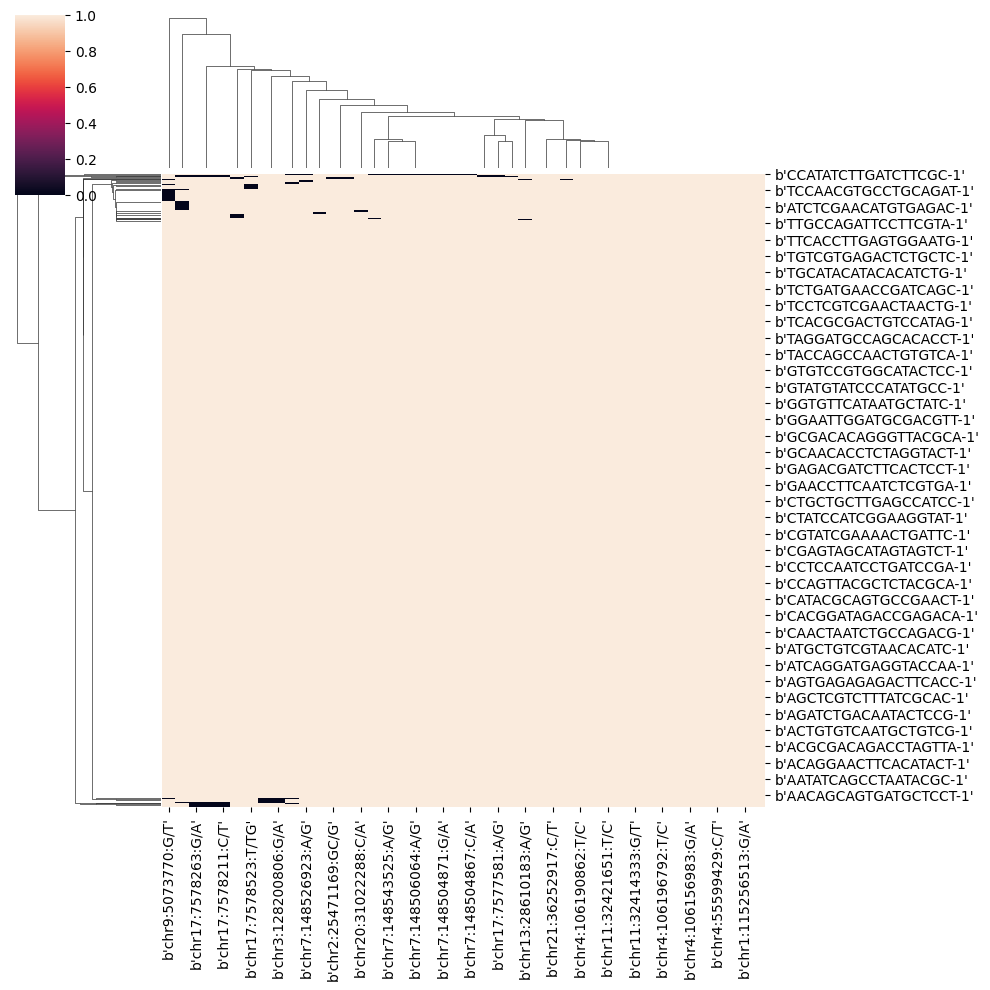

In [73]:
sns.clustermap(mutation_matrix)

In [89]:
covs_filter_mean = covs_filter.join(covs_filter.mean(axis=1).rename('mean'))
mutation_matrix = covs_filter_mean.apply(lambda x : x/covs_filter_mean['mean']).drop(columns='mean')
mutation_matrix = mutation_matrix.applymap(lambda x : 1 if x > 1 else 0)

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


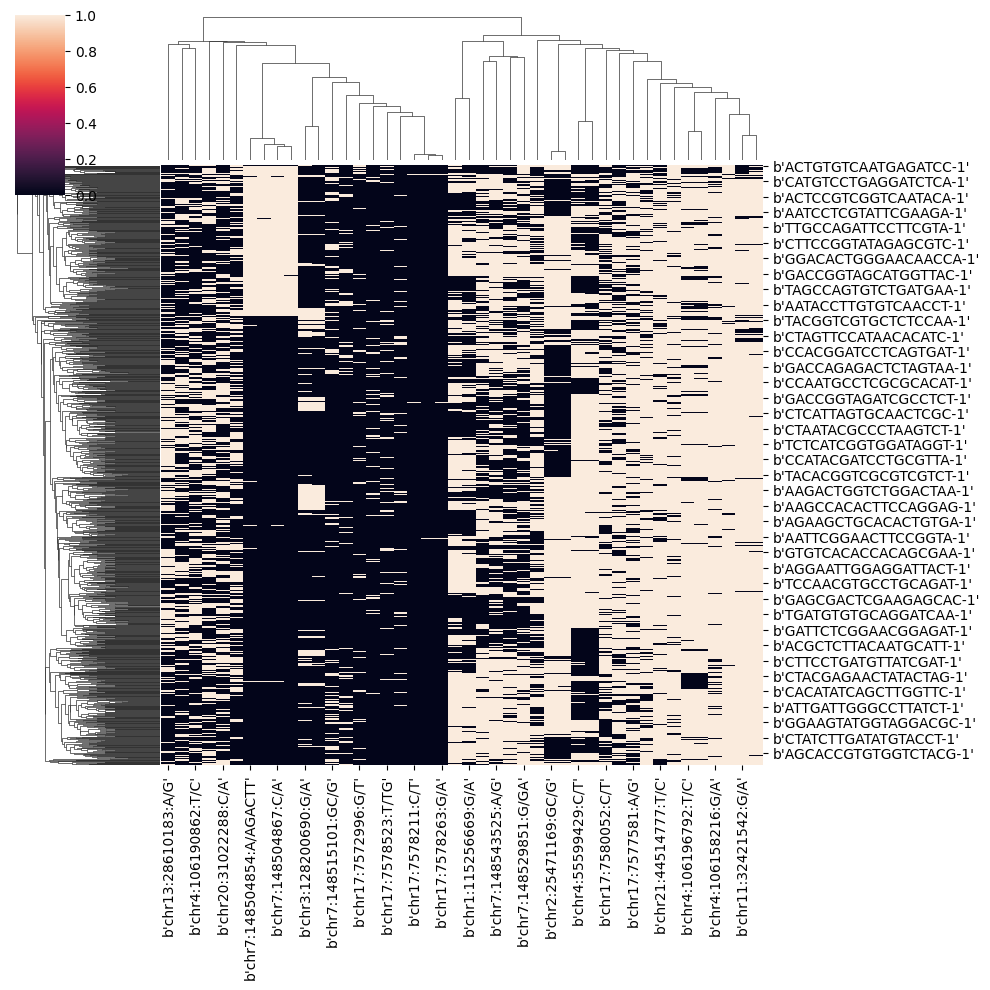

In [90]:
sns.clustermap(mutation_matrix)